In [1]:
import os
import glob
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

os.chdir("..")
from utils import *
from runDeepSurvModels import *

## Optuna

### Network Setup

In [2]:
# import os
# import time
# from datetime import datetime
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn_pandas import DataFrameMapper

# import torch
# import torchtuples as tt
# from utils import *
# from pycox.models.cox import CoxPH#, CoxPHStratified
# from pycox.evaluation.eval_surv import EvalSurv#, EvalurvStratified
# import optuna

# np.random.seed(123)
# torch.manual_seed(123)

# def parse_hyperparameters(trial, config=None):
#     """
#     Convert a dictionary of hyperparameter ranges into Optuna-compatible format.
    
#     Args:
#     - trial (optuna.trial.Trial): The Optuna trial object to sample parameters from.
#     - config (dict): A dictionary with hyperparameter names as keys. Values should be a dictionary specifying the type of parameter ('int', 'float', or 'categorical')
#     and the range or choices.
    
#     Returns:
#     - dict: A dictionary of sampled hyperparameters compatible with the given ranges.
#     """
#     params = {}
#     for param_name, param_info in config.items():
#         param_type = param_info.get("type")
#         if param_type == "int":
#             params[param_name] = trial.suggest_int(param_name, param_info["low"], param_info["high"])
#         elif param_type == "float":
#             params[param_name] = trial.suggest_float(param_name, param_info["low"], param_info["high"], log=param_info.get("log", False))
#         elif param_type == "categorical":
#             params[param_name] = trial.suggest_categorical(param_name, param_info["choices"])
#         else:
#             raise ValueError(f"Unsupported hyperparameter type: {param_type}")
#     return params


# def filter_hyperparams_by_size(config, n_samples, exclusion_dict):
#         exclude_keys = exclusion_dict.get(n_samples, [])
#         return {k: v for k, v in config.items() if k not in exclude_keys}


# class DeepSurvPipeline():
#     """_summary_
#     """
#     def __init__(
#         self,
#         train_df, 
#         test_df, 
#         test_size=1000,
#         time_col='time', status_col='status', batch_col="batch.id",
#         batchNormType=None,
#         dataName=None, 
#         hyperparameters=None, 
#         storage_url="sqlite:///deepsurv-torch-hp-log.db",
#         random_state=42
#     ):
#         self.train_df=train_df
#         self.test_df=test_df
#         self.n = train_df.shape[0]
#         self.test_size = test_size
#         self.time_col = time_col
#         self.status_col = status_col
#         self.batch_col = batch_col
#         self.batchNormType = batchNormType
#         self.dataName = dataName
#         self.hyperparameters = hyperparameters
#         self.storage_url = storage_url
#         self.random_state = random_state
#         self.best_params = None
#         self.model = None
#         self.modelString = 'deepsurv-torch'
#         self.patience = 30
#         self.min_delta = 1e-3
    
    
#     def _preprocess_data(self, df, mapper=None, fit_scaler=True):
#         """
#         Applies StandardScaler() to transform the input miRNAseq data frame.
        
#         Parameters:
#         df (pd.DataFrame): Input data.
#         mapper (DataFrameMapper or None): If provided, uses this mapper to transform data.
#         fit_scaler (bool): Whether to fit a new mapper on the current data.
        
#         Returns:
#         x (np.ndarray): Scaled features.
#         y (tuple): (time, event) tuple for survival modeling.
#         mapper (DataFrameMapper): The fitted mapper used for transformation.
#         """
#         survival_cols = [self.time_col, self.status_col]
#         covariate_cols = [col for col in df.columns if col not in survival_cols]
        
#         if fit_scaler or mapper is None:
#             standardize = [([col], StandardScaler()) for col in covariate_cols]
#             mapper = DataFrameMapper(standardize)
#             # Transform features (miRNA expression)
#             x = mapper.fit_transform(df[covariate_cols]).astype('float32')
#         else:
#             x = mapper.transform(df[covariate_cols]).astype('float32')
        
#         # Prepare labels (survival data)
#         y = (df[self.time_col].values, df[self.status_col].values)
        
#         return x, y, mapper
    
    
#     def train_mlp(self, 
#                 train_df=None,
#                 val_df=None, 
#                 params=None,
#                 patience=None, 
#                 min_delta=None, 
#                 verbose=False, 
#                 is_tuning=False,
#                 calculate_brier=True):
#         """Training function that works for both tuning and main training.
        
#         Args:
#             x_train (pandas.DataFrame): _description_
#             y_train (pandas.DataFrame): _description_
#             params (dict): neural network training parameters
#                 - batch_size (int): default = 32
#                     Number of samples used for calculating loss and updating weights.  
#                 - epochs (int): default = 500 
#                     Number of times the entire dataset is being processed.
#                 - num_nodes (list): default = [32,32]
#                     Number of hidden layers and nodes in each layer. 
#                 - learning_rate (float): default = 0.001
#                     The rate at which weights are updated.
#                 - weight_decay (float): default = 0.0001
#                     Regularization parameter applied to the loss function. 
#                 - dropout (float): range 0-1, default = 0.1 
#                     Drop out rate.
#                 - activation (str): {'ReLU', 'LeakyReLU', 'SELU'}, default = "ReLU" 
#                     Activation function applied the hidden layers.
#                 - batch_norm (bool): default = True
#                     ...
#                 - output_bias (bool): default = True
#                     ...
#             patience (int): The number of epochs allowed for no improvement in loss before stopping the network training.
#             min_delta (float): Minimum improvement for early stopping.
#             verbose (bool): Whether to print training logs.
#             is_tuning (bool): Whether to skip saving model.
#             calculate_brier (bool): Whether to compute Brier score.
            
#         Returns:
#             duration: float 
#                 Training time in seconds.
#             tr_c_index, val_c_index: float
#                 Harrell's concordance index scores.
#             tr_brier, val_brier: float 
#                 Integrated Brier scores calculated at 50 time points
#                 selected evenly throughout min and max survival time in the train and test data.
#         """
#         # ================== Prepare data ===================
#         train_df = train_df if train_df is not None else self.train_df
#         val_df  = val_df if val_df is not None else self.test_df
#         if self.batch_col in train_df.columns:
#             train_df = train_df.drop(columns=self.batch_col)
#         if self.batch_col in val_df.columns:
#             val_df = val_df.drop(columns=self.batch_col)
        
#         x_train, y_train, mapper = self._preprocess_data(train_df, fit_scaler=True)
#         x_val, y_val, _ = self._preprocess_data(val_df, mapper=mapper, fit_scaler=False)
        
#         # ============== GPU integration ============
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
#         # Convert numpy arrays to torch tensors and move to GPU
#         x_train = torch.from_numpy(x_train).to(device)
#         x_val = torch.from_numpy(x_val).to(device)
        
#         # Unpack and convert y = (time, event)
#         durations_train = torch.from_numpy(y_train[0]).float().to(device)
#         events_train = torch.from_numpy(y_train[1]).float().to(device)
#         durations_val = torch.from_numpy(y_val[0]).float().to(device)
#         events_val = torch.from_numpy(y_val[1]).float().to(device)
        
#         y_train = (durations_train, events_train)
#         y_val = (durations_val, events_val)
        
#         input_size = x_train.shape[1]
#         output_size = 1
        
#         # Set hyperparameters with input / default values
#         if params is None and self.best_params is None:
#             print("No hyperparameters provided. Training with defaults.")
#             params = {}
#         elif params is None:
#             params = self.best_params
        
#         num_nodes = params.get("num_nodes", [32,32])            # Default # layers & nodes
#         dropout = params.get("dropout", 0.1)                    # Default dropout rate
#         learning_rate = params.get("learning_rate", 1e-4)       # Default learning rate
#         batch_size = params.get("batch_size", 64)               # Default batch size
#         epochs = params.get("epochs", 500)                      # Default number of epochs
#         batch_norm = params.get("batch_norm", True)             # Default batch normalization
#         output_bias = params.get("output_bias", True)           # Default output bias
#         weight_decay = params.get("weight_decay", 1e-4)         # Default weight decay
#         activation_map = {
#             "ReLU": torch.nn.ReLU,
#             "LeakyReLU": torch.nn.LeakyReLU,
#             "SELU": torch.nn.SELU
#         } # Activation function
#         activation = activation_map.get(params.get("activation", "ReLU")) # Default output bias
        
#         # =================== Build Neural Net ===================
#         # Define network
#         net = tt.practical.MLPVanilla(
#             in_features=input_size,
#             out_features=output_size,
#             num_nodes=num_nodes,
#             dropout=dropout, 
#             batch_norm=batch_norm,
#             activation=activation,
#             output_bias=output_bias
#         )
#         net = net.to(device) # send to GPU
        
#         # Define optimizer 
#         optimizer = tt.optim.Adam(weight_decay=weight_decay, lr=learning_rate)
#         model = CoxPH(net, optimizer)
        
#         # =================== Train Model ====================
#         # Get default early stopping settings if not defined 
#         patience = self.patience if patience is None else patience
#         min_delta = self.min_delta if min_delta is None else min_delta
        
#         callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
#         start = time.time() # Record iteration start time
#         log = model.fit(
#             x_train, y_train,
#             batch_size=batch_size,
#             epochs=epochs,
#             callbacks=callbacks, 
#             verbose=verbose,
#             val_data=(x_val, y_val),
#             val_batch_size=batch_size
#         )
#         stop = time.time() # Record time when training finished
#         duration = round(stop - start, 2)
        
#         # ==================== Evaluation ====================
#         _ = model.compute_baseline_hazards()
        
#         # Convert torch tensors back to numpy objects for evaluation
#         x_train_np = x_train.detach().cpu().numpy()
#         x_val_np = x_val.detach().cpu().numpy()
        
#         durations_train_np = durations_train.detach().cpu().numpy()
#         events_train_np    = events_train.detach().cpu().numpy()
#         durations_val_np   = durations_val.detach().cpu().numpy()
#         events_val_np      = events_val.detach().cpu().numpy()
        
#         # Initialize EvalSurv objects 
#         tr_surv  = model.predict_surv_df(x_train_np)
#         val_surv = model.predict_surv_df(x_val_np)
        
#         tr_ev = EvalSurv(tr_surv, durations_train_np, events_train_np, censor_surv='km')
#         val_ev = EvalSurv(val_surv, durations_val_np, events_val_np, censor_surv='km')
        
#         # Concordance index ----------------
#         tr_c_index  = tr_ev.concordance_td() 
#         val_c_index = val_ev.concordance_td() 
        
#         # Integrated Brier score -----------
#         min_surv = np.ceil(max(np.min(durations_train_np), np.min(durations_val_np)))
#         max_surv = np.floor(min(np.max(durations_train_np), np.max(durations_val_np)))
#         times = np.linspace(min_surv, max_surv, 20)
        
#         if calculate_brier:
#             tr_brier  = tr_ev.integrated_brier_score(time_grid=times) 
#             val_brier = val_ev.integrated_brier_score(time_grid=times) 
#         else:
#             tr_brier = val_brier = np.nan
        
#         if not is_tuning:
#             self.model = model
#             self.optimizer = optimizer
            
#         # print(
#         #     f"""
#         #     N={self.n} Training time: ({duration}s)
#         #         C index:  Train ({round(tr_c_index, 3)})  |  Test ({round(val_c_index, 3)})
#         #         Brier score:  Train ({round(tr_brier, 3)})  |  Test ({round(val_brier, 3)})
#         #     """ 
#         # )  
#         return duration, tr_brier, val_brier, tr_c_index, val_c_index
    
    
#     def _objective(self, trial, train_df, config, n_splits, fixed_params=None):
#         """Perform K-Fold CV and return the average validation loss across folds.""" 
        
#         tunable_params = parse_hyperparameters(trial, config=config)
        
#         full_params = {**fixed_params, **tunable_params} if fixed_params else tunable_params
        
#         kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
#         stratify_labels = train_df[self.status_col].astype(str) #+ "_" + train_df[self.batch_col].astype(str)
        
#         val_c_indexes = []
#         for train_index, val_index in kf.split(train_df, stratify_labels):
#             tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

#             # Train and evaluate on the current fold -- validation score
#             *_, val_c_index = self.train_mlp(tr_df, val_df,
#                                             params=full_params,
#                                             patience=self.patience, 
#                                             min_delta=self.min_delta,
#                                             verbose=False,
#                                             is_tuning=True)
#             val_c_indexes.append(val_c_index)
        
#         return np.mean(val_c_indexes)
    
    
#     def tune_hyperparameters(self, 
#                             train_df, 
#                             n_samples=None,
#                             config=None,
#                             storage_url=None, 
#                             study_name=None,
#                             n_splits=10,
#                             trial_threshold=30,
#                             n_trials=30,
#                             n_jobs=1, 
#                             timeout=2400):
#         """
#         Perform hyperparameter tuning within the K-fold CV framework using the Optuna library.
#         Provides option to store tuning results and retrieve from existing studies to avoid duplicate optimization processes. 
#         Studies are designed to maximize the average validation Harrell's concordance index (C-index) scores.  
        
#         Args:
#             train_df: Training dataset.
#             n_samples: default = None
#             config: Search grid for hyperparameter tuning.
#             storage_url: URL for Optuna storage.
#             study_name: Name of the study.
#             n_splits: Number of splits for cross-validation.
#             n_trials: Number of trials to run for tuning.
#             n_jobs: Number of parallel jobs for tuning.
#             trial_threshold: Minimum number of trials required to skip tuning.
#         """
#         n_samples = n_samples if n_samples is not None else train_df.shape[0]
#         study_name = f"{self.batchNormType}-{self.dataName}-{n_samples}" if study_name is None else study_name
#         storage_url = self.storage_url if storage_url is None else storage_url
        
#         # Create an Optuna study for hyperparameter optimization
#         study = optuna.create_study(direction='maximize',
#                                     storage=storage_url, 
#                                     study_name=study_name, 
#                                     load_if_exists=True)
        
#         # Define search space
#         config = self.hyperparameters if config is None else config
#         if config is None:
#             raise ValueError("No hyperparameter search space provided. Set `config` or `self.hyperparameters`.")
        
#         # Extract already optimized hyperparameters and prepare new hyperparameter search grid
#         successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
#         fixed_params = study.best_params if len(successful_trials) >= trial_threshold else {}
#         new_config = {k: v for k, v in config.items() if k not in fixed_params}
        
#         if len(new_config) == 0:
#             self.best_params = fixed_params
#             print(f"All hyperparameters already tuned: {self.best_params}\nSkipping optimization...")
#             return study
        
#         # @TODO: selectively drop hyperparameters
#         # excluded_params_by_size = {
#         #     100: ["batch_size", "dropout", "activation"],
#         #     500: ["batch_size"]
#         # } --> add to class attribute
#         # filtered_config = filter_hyperparams_by_size(new_config, n_samples, self.exclusion_dict)
        
#         # Optimize the study using the objective function
#         print(f"Starting hyperparam tuning: {list(new_config.keys())}")
        
#         study.optimize(
#             lambda trial: self._objective(trial,
#                                         train_df=train_df,
#                                         config=new_config,
#                                         fixed_params=fixed_params,
#                                         n_splits=n_splits),
#             n_trials=n_trials, 
#             n_jobs=n_jobs,
#             timeout=timeout
#         )
        
#         # Ensure not all trals failed
#         successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
#         if len(successful_trials) == 0:
#             raise ValueError("All trials failed. Consider changing the hyperparameter grid and retrying.")
        
#         # Save the best hyperparameters
#         self.best_params = {**fixed_params, **study.best_params}
#         print(f"Found best hyperparameters: {self.best_params}")
        
#         return study
    
    
#     def write(self, model_results, out_dir=None, fileName=None):
        
#         out_dir=os.path.join('models', self.batchNormType, self.dataName, self.modelString) if out_dir is None else out_dir
#         os.makedirs(out_dir, exist_ok=True)
        
#         # save results as txt or csv file
#         today = datetime.now().strftime("%Y%m%d")
#         fileName = f'model_results_{today}.csv' if fileName is None else fileName
        
#         if 'txt' in fileName:
#             model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
#         elif 'csv' in fileName:
#             model_results.to_csv(os.path.join(out_dir,fileName), index=False)
#         else:
#             print('Please specify a file name with either a txt or csv extension.')
    
    
#     def train_over_subsets(self,
#                            subset_sizes=[100, 500, 1000, 2000, 5000],
#                            runs_per_size=[20,20,20,20,20],
#                            splits_per_size=[3,5,5,10,10],
#                            trials_per_size=[30,30,30,30,30],
#                            trial_threshold=30,
#                            n_jobs=1,
#                            is_tune=True,
#                            is_save=False,
#                            fileName="model.results.txt"):
        
#         n_train, model_time, model_train_cind, model_test_cind, model_train_brier, model_test_brier = [],[],[],[],[],[]
        
#         for (n, n_run, n_splits, n_trials) in zip(subset_sizes, runs_per_size, splits_per_size, trials_per_size): 
            
#             run_time, run_train_cind, run_test_cind, run_train_brier, run_test_brier = [],[],[],[],[]
            
#             print(f"Running for N={n}...")
            
#             # Apply early stopping based on training sample size
#             if hasattr(self, "early_stop_per_size"):
#                 stop_params = self.early_stop_per_size.get(str(n), {})
#                 self.patience = stop_params.get("patience", 30)
#                 self.min_delta = stop_params.get("min_delta", 1e-3)
            
#             for run in range(n_run):
#                 if n < self.train_df.shape[0]:
#                     train_sub, _ = train_test_split(self.train_df,
#                                                     train_size=n, # train_size= n/self.train_df.shape[0], 
#                                                     shuffle=True,
#                                                     random_state=run,
#                                                     stratify=self.train_df[[self.status_col, self.batch_col]])
#                 else:
#                     train_sub = self.train_df
                
#                 ## update 6/3/2025: vary test set across iterations
#                 if self.test_size < self.test_df.shape[0]:
#                     test_sub, _ = train_test_split(self.test_df,
#                                                 train_size=self.test_size, # train_size= n/self.train_df.shape[0], 
#                                                 shuffle=True,
#                                                 random_state=run,
#                                                 stratify=self.test_df[[self.status_col, self.batch_col]])
#                 else:
#                     test_sub = self.test_df
                
#                 if run == 0:
#                     if is_tune:     
#                         self.tune_hyperparameters(
#                             train_sub, n_splits=n_splits, n_samples=n, n_trials=n_trials, n_jobs=n_jobs, trial_threshold=trial_threshold
#                         )
#                         best_params = self.best_params
                    
#                     else:
#                         try:
#                             study_name = f"{self.batchNormType}-{self.dataName}-{n}"
#                             study = optuna.load_study(study_name=study_name, storage=self.storage_url)
#                             best_params = study.best_params
#                             print(f"Retrieved best hyperparameters from {study_name}: {best_params}")
#                         except Exception as e:
#                             print(f"⚠️No Optuna study found for '{study_name}'. Fall back to hyperparameters from config.")
#                             best_params = {}
#                             for key, val in self.hyperparameters.items():
#                                 if isinstance(val, dict) and "choices" in val:
#                                     best_params[key] = val["choices"][0]  # Pick first default choice
#                                 elif isinstance(val, dict) and "low" in val and "high" in val:
#                                     best_params[key] = val["low"]  # Pick lower bound as default
#                                 else:
#                                     best_params[key] = val  # directly use the value
                    
#                     # Apply override if defined in self
#                     if hasattr(self, "param_override") and self.param_override:
#                         best_params.update(self.param_override)
#                         print(f"Final parameter set after override: %s", best_params)
                    
                    
#                 duration, train_brier, test_brier, train_c, test_c = self.train_mlp(
#                     train_df=train_sub, val_df=test_sub, params=best_params, verbose=False, calculate_brier=True
#                 )
                
#                 n_train.append(n)
#                 model_time.append(duration)
#                 model_train_cind.append(train_c)
#                 model_test_cind.append(test_c)
#                 model_train_brier.append(train_brier)
#                 model_test_brier.append(test_brier)
                
#                 run_train_cind.append(train_c)
#                 run_test_cind.append(test_c)
#                 run_train_brier.append(train_brier)
#                 run_test_brier.append(test_brier)
#                 run_time.append(duration)
            
#             print(
#                 f"(Avg. runtime: {np.mean(run_time):.2f}s)   |\
#                 (C-index)  Train: {round(np.mean(run_train_cind),3)}, Test: {round(np.mean(run_test_cind),3)}   |\
#                 (Brier)  Train: {round(np.nanmean(run_train_brier),3)}, Test: {round(np.nanmean(run_test_brier),3)} (Mean)\n"
#             )                
            
#         model_results = pd.DataFrame({
#             'n train': n_train, 
#             'train time': model_time,
#             'train C': model_train_cind, 
#             'test C': model_test_cind,
#             'train brier': model_train_brier,
#             'test brier': model_test_brier
#         })
        
#         if is_save:
#             self.write(model_results=model_results, fileName=fileName)
            
#         return model_results

### Check Optuna Storage Status

In [7]:
optuna.get_all_study_names(storage="sqlite:///deepsurv-torch-hp-log-1.db")

# study = optuna.load_study(storage="sqlite:///deepsurv-torch-hp-log-1.db", study_name="BE00Asso00_normUQ-linear-moderate-5000")
# study.trials

# for n in [100,500]:#,1000,2000,5000]:
    # optuna.delete_study(storage="sqlite:///deepsurv-torch-hp-log-1.db", study_name=f"BE00Asso00_normNone--{}")

['BE00Asso00_normUQ-linear-moderate-100',
 'BE00Asso00_normUQ-linear-moderate-500',
 'BE00Asso00_normUQ-linear-moderate-1000',
 'BE00Asso00_normUQ-linear-moderate-2000',
 'BE00Asso00_normUQ-linear-moderate-5000',
 'BE00Asso00_normNone-linear-moderate-100',
 'BE00Asso00_normNone-linear-weak-100',
 'BE00Asso00_normNone-linear-weak-500',
 'BE00Asso00_normNone-linear-moderate-500',
 'BE00Asso00_normNone-linear-weak-1000',
 'BE00Asso00_normNone-linear-moderate-1000',
 'BE00Asso00_normNone-linear-weak-2000',
 'BE00Asso00_normNone-linear-moderate-2000',
 'BE00Asso00_normNone-linear-moderate-5000',
 'BE00Asso00_normNone-linear-weak-5000',
 'BE00Asso00_normNone-nl-quadratic-100',
 'BE00Asso00_normNone-nl-quadratic-500',
 'BE00Asso00_normNone-nl-quadratic-1000',
 'BE00Asso00_normNone-nl-quadratic-2000',
 'BE00Asso00_normNone-nl-quadratic-5000',
 'BE00Asso00_normTC-linear-weak-100',
 'BE00Asso00_normTC-nl-quadratic-100',
 'BE00Asso00_normTC-linear-weak-500',
 'BE00Asso00_normTC-nl-quadratic-500',

### *Train-Test Split (For the first time only)*

In [ ]:
# batchNormType='BE00Asso00_normNone'
# dataType = 'linear-moderate'
# keywords = ['050725']
# test_size=10000
# random_state=42
# time_col='time'
# status_col='status'
# batch_col='batch.id'

# # load survival data for all samples
# data_df = pd.read_csv(os.path.join('data', 'simSurvival_Batch_100000.csv'))

# # FIRST TIME: re-split data into train and test set with desired sample sizes
# train_df, test_df = train_test_split(data_df, 
#                                     test_size=test_size,
#                                     shuffle=True, random_state=random_state,
#                                     stratify=data_df[[status_col, batch_col]])
# pd.DataFrame(pd.DataFrame({'id':test_df.sort_index().index+1})).to_csv(os.path.join('data', f'test_ids_{test_size}.txt'), sep='\t', index=False)

# train_df = train_df.reset_index(drop=True)
# test_df  = test_df.reset_index(drop=True)
# # test_df = test_df.drop(columns='batch.id')

# # observe data
# print(f"Training data dimensions: {train_df.shape[0]}")
# print(f"Testing data dimensions:  {test_df.shape[0]}")

Training data dimensions: (90000, 541)
Testing data dimensions:  (10000, 541)
Event rate in train set: 0.752856
Event rate in test set: 0.749300
Survival time distribution:


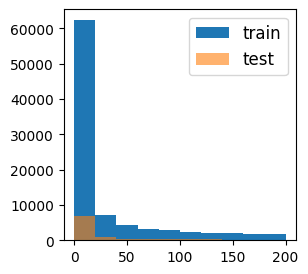

In [3]:
hyperparameters = {
    "num_nodes": {"type": "categorical", "choices": [[64, 64], [32, 32], [16,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True}
}

batchNormType='BE00Asso00_normMed'
dataName = 'linear-moderate'
keywords = ['061825']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
plot_simulation_data(train_df, test_df)

In [4]:
ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)

# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=[500],#subset_sizes, 
                                runs_per_size=[20],#runs_per_size, 
                                splits_per_size=[10],#splits_per_size,
                                trials_per_size=[25],#trails_per_size,
                                is_tune=True, 
                                is_save=False, 
                                n_jobs=1,
                                trial_threshold=10                                                          
)
# ds.write(model_results)
model_results

Running for N=500...


[I 2025-07-03 10:25:14,925] Using an existing study with name 'BE00Asso00_normMed-linear-moderate-500' instead of creating a new one.


Starting hyperparam tuning: ['num_nodes', 'dropout', 'learning_rate', 'weight_decay']


[I 2025-07-03 10:25:24,686] Trial 10 finished with value: 0.609507183812405 and parameters: {'num_nodes': [32, 32], 'dropout': 0.30283343765394743, 'learning_rate': 0.0010205312517346827, 'weight_decay': 2.6358117942518857e-05}. Best is trial 6 with value: 0.6697264328053589.
[I 2025-07-03 10:25:32,077] Trial 11 finished with value: 0.6266793418013388 and parameters: {'num_nodes': [16, 16], 'dropout': 0.4610081843656354, 'learning_rate': 0.008706565935479648, 'weight_decay': 0.0001263674369730101}. Best is trial 6 with value: 0.6697264328053589.
[I 2025-07-03 10:25:39,017] Trial 12 finished with value: 0.6509036867879143 and parameters: {'num_nodes': [16, 16], 'dropout': 0.11074297352549939, 'learning_rate': 0.009476089370791866, 'weight_decay': 0.00010889441616788607}. Best is trial 6 with value: 0.6697264328053589.
[I 2025-07-03 10:25:46,293] Trial 13 finished with value: 0.6830731489023727 and parameters: {'num_nodes': [16, 16], 'dropout': 0.10285000981889467, 'learning_rate': 0.003

Found best hyperparameters: {'num_nodes': [64, 64], 'dropout': 0.41417150384436574, 'learning_rate': 0.0031502263683810313, 'weight_decay': 0.005746517741685022}
(Avg. runtime: 0.61s)   |                (C-index)  Train: 0.887, Test: 0.707   |                (Brier)  Train: 0.059, Test: 0.154 (Mean)



n train  train time   train C    test C  train brier  test brier
0       500        0.63  0.890234  0.714226     0.059566    0.145650
1       500        0.65  0.913817  0.728245     0.033931    0.151116
2       500        0.64  0.896847  0.734578     0.057182    0.162102
3       500        0.54  0.845998  0.684192     0.082660    0.154765
4       500        0.59  0.891340  0.696338     0.055670    0.149256
5       500        0.61  0.877249  0.709890     0.069670    0.158582
6       500        0.57  0.886548  0.700671     0.062574    0.155342
7       500        0.63  0.889587  0.711833     0.057572    0.148373
8       500        0.57  0.874799  0.698196     0.061955    0.165140
9       500        0.72  0.923233  0.716320     0.035292    0.152576
10      500        0.55  0.873885  0.697844     0.079186    0.156197
11      500        0.61  0.898863  0.702556     0.047588    0.155425
12      500        0.64  0.907797  0.721374     0.051493    0.156233
13      500        0.63  0.906803  0.727123     0.049141    0.148304
14      500        0.58  0.870053  0.672471     0.072881    0.143748
15      500        0.57  0.880415  0.707720     0.054799    0.149213
16      500        0.60  0.890357  0.690571     0.058091    0.166363
17      500        0.59  0.889672  0.724610     0.059096    0.147727
18      500        0.65  0.866356  0.683854     0.074222    0.167305
19      500        0.57  0.875865  0.720692     0.061445    0.153456

### *Test: Expand network training process*

In [ ]:
# Prepare data 
n=5000
train_sub,_ = train_test_split(train_df,
                            train_size=n, 
                            shuffle=True, random_state=42,
                            stratify=train_df[[status_col, batch_id]])
train_sub = train_sub.drop(columns='batch.id')


survival_cols = [time_col, status_col]
covariate_cols = [col for col in train_sub.columns if col not in survival_cols]

standardize = [([col], StandardScaler()) for col in covariate_cols]
x_mapper = DataFrameMapper(standardize)

# transform features (miRNA expression)
x_train = x_mapper.fit_transform(train_sub[covariate_cols]).astype('float32')
x_val = x_mapper.transform(test_df[covariate_cols]).astype('float32')

y_train = (train_sub[time_col].values, train_sub[status_col].values)
y_val =(test_df[time_col].values, test_df[status_col].values)
input_size = x_train.shape[1]
output_size = 1

params = {'num_nodes': [64, 64], 'dropout': 0.39098343438204586, 'learning_rate': 0.00764219610256268, 'weight_decay': 1.9302399045779133e-05, 'batch_size': 64}
num_nodes = params.get("num_nodes", [32,32])            # Default # layers & nodes
dropout = params.get("dropout", 0.1)                    # Default dropout rate
learning_rate = params.get("learning_rate", 1e-3)       # Default learning rate
batch_size = params.get("batch_size", 64)               # Default batch size
epochs = params.get("epochs", 500)                      # Default number of epochs
batch_norm = params.get("batch_norm", True)             # Default batch normalization
output_bias = params.get("output_bias", True)           # Default output bias
weight_decay = params.get("weight_decay", 1e-4)         # Default weight decay
activation_map = {
    "ReLU": torch.nn.ReLU,
    "LeakyReLU": torch.nn.LeakyReLU,
    "SELU": torch.nn.SELU
} # Activation function
activation = activation_map.get(params.get("activation", "ReLU")) # Default output bias

In [ ]:
# =================== Build Neural Net ===================
## define network
net = tt.practical.MLPVanilla(
    in_features=input_size,
    out_features=output_size,
    num_nodes=num_nodes,
    dropout=dropout, 
    batch_norm=batch_norm,
    activation=activation,
    output_bias=output_bias
)
# define optimizer 
optimizer = tt.optim.Adam(weight_decay=weight_decay, lr=learning_rate)
model = CoxPH(net, optimizer)

# =================== Train Model ====================
callbacks = [tt.callbacks.EarlyStopping(patience=30, min_delta=1e-2)]

start = time.time() # Record iteration start time
log = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks, 
    verbose=True,
    val_data=(x_val, y_val),
    val_batch_size=batch_size
)
stop = time.time() # Record time when training finished
duration = round(stop - start, 2)
print(duration)


0:	[0s / 0s],		train_loss: 3.3709
1:	[0s / 0s],		train_loss: 3.1824
2:	[0s / 0s],		train_loss: 3.0364
3:	[0s / 0s],		train_loss: 2.9436
4:	[0s / 0s],		train_loss: 2.8485
5:	[0s / 0s],		train_loss: 2.8135
6:	[0s / 0s],		train_loss: 2.7744
7:	[0s / 0s],		train_loss: 2.7299
8:	[0s / 1s],		train_loss: 2.7442
9:	[0s / 1s],		train_loss: 2.6943
10:	[0s / 1s],		train_loss: 2.6782
11:	[0s / 1s],		train_loss: 2.6498
12:	[0s / 1s],		train_loss: 2.6543
13:	[0s / 1s],		train_loss: 2.6524
14:	[0s / 1s],		train_loss: 2.6665
15:	[0s / 1s],		train_loss: 2.6512
16:	[0s / 1s],		train_loss: 2.6036
17:	[0s / 2s],		train_loss: 2.5934
18:	[0s / 2s],		train_loss: 2.5752
19:	[0s / 2s],		train_loss: 2.6001
20:	[0s / 2s],		train_loss: 2.5865
21:	[0s / 2s],		train_loss: 2.5720
22:	[0s / 2s],		train_loss: 2.5413
23:	[0s / 2s],		train_loss: 2.5651
24:	[0s / 2s],		train_loss: 2.5689
25:	[0s / 2s],		train_loss: 2.5635
26:	[0s / 3s],		train_loss: 2.5709
27:	[0s / 3s],		train_loss: 2.5210
28:	[0s / 3s],		train_loss: 2.

In [ ]:
# ==================== Evaluation ====================
_ = model.compute_baseline_hazards()
tr_surv  = model.predict_surv_df(x_train)
val_surv = model.predict_surv_df(x_val)

tr_ev  = EvalSurv(tr_surv, durations=y_train[0], events=y_train[1], censor_surv='km')
val_ev = EvalSurv(val_surv, durations=y_val[0], events=y_val[1], censor_surv='km')

tr_ev.concordance_td(), val_ev.concordance_td()

(0.45978876935693425, 0.45600156085916116)

In [ ]:
tr_ev  = EvalSurv(tr_surv, durations=y_train[0], events=y_train[1], censor_surv='km')
val_ev = EvalSurv(val_surv, durations=y_val[0], events=y_val[1], censor_surv='km')

# Concordance index 
tr_c_index  = tr_ev.concordance_td() 
val_c_index = val_ev.concordance_td() 

# Integrated Brier score 
min_surv = np.ceil(max(np.min(y_train[0]), np.min(y_val[0])))
max_surv = np.floor(min(np.max(y_train[0]), np.max(y_val[0])))
times = np.linspace(min_surv, max_surv, 20)

tr_brier  = tr_ev.integrated_brier_score(time_grid=times) 
val_brier = val_ev.integrated_brier_score(time_grid=times) 


print(
    f"N={n} Training time: ({duration}s)\
        C index:  Train ({round(tr_c_index, 3)})  |  Test ({round(val_c_index, 3)})\
        Brier score:  Train ({round(tr_brier, 3)})  |  Test ({round(val_brier, 3)})"
)  


N=5000 Training time: (3.35s)        C index:  Train (0.46)  |  Test (0.456)        Brier score:  Train (0.195)  |  Test (0.197)


### *Test: Optimize and train various training sizes*

In [ ]:
subset = [100,500]
trials = [10,10]
runs = [3,3]
splits = [3,5]
ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)
results = ds.train_over_subsets(subset_sizes=subset, 
                                runs_per_size=runs, 
                                trials_per_size=trials,
                                splits_per_size=splits,
                                is_tune=True, 
                                is_save=False,
                                n_jobs=8)
results

Running for N=100...


[I 2025-04-28 23:08:30,904] Using an existing study with name 'BE00Asso00_normNone-linear-moderate-100' instead of creating a new one.


Starting hyperparam tuning: ['num_nodes', 'dropout', 'learning_rate', 'weight_decay']


[I 2025-04-28 23:08:50,927] Trial 26 finished with value: 0.6225728500355366 and parameters: {'num_nodes': [64, 64], 'dropout': 0.10329819120701439, 'learning_rate': 0.004349381882024664, 'weight_decay': 0.006715517426685997}. Best is trial 19 with value: 0.6547119831180582.
[I 2025-04-28 23:08:50,999] Trial 25 finished with value: 0.6779517239526472 and parameters: {'num_nodes': [64, 64], 'dropout': 0.10657826900100889, 'learning_rate': 0.003869109597377033, 'weight_decay': 0.00853859335778513}. Best is trial 25 with value: 0.6779517239526472.
[I 2025-04-28 23:08:52,663] Trial 27 finished with value: 0.6235552722396852 and parameters: {'num_nodes': [64, 64], 'dropout': 0.4446308908187949, 'learning_rate': 0.00316733751377427, 'weight_decay': 0.007059967100235671}. Best is trial 25 with value: 0.6779517239526472.
[I 2025-04-28 23:08:52,823] Trial 20 finished with value: 0.6428092233970061 and parameters: {'num_nodes': [64, 64], 'dropout': 0.4472703316668714, 'learning_rate': 0.00374755

Found best hyperparameters: {'num_nodes': [64, 64], 'dropout': 0.10657826900100889, 'learning_rate': 0.003869109597377033, 'weight_decay': 0.00853859335778513}
(Avg. runtime: 0.47s)   |                (C-index)  Train: 0.815, Test: 0.639   |                (Brier)  Train: 0.093, Test: 0.154 (Mean)

Running for N=500...


[I 2025-04-28 23:08:59,458] Using an existing study with name 'BE00Asso00_normNone-linear-moderate-500' instead of creating a new one.


Starting hyperparam tuning: ['num_nodes', 'dropout', 'learning_rate', 'weight_decay']


[I 2025-04-28 23:10:09,220] Trial 24 finished with value: 0.7313290707237879 and parameters: {'num_nodes': [32, 32], 'dropout': 0.30544853640512976, 'learning_rate': 0.008219017658943402, 'weight_decay': 0.0002469968850846076}. Best is trial 9 with value: 0.7846466281510993.
[I 2025-04-28 23:10:12,119] Trial 27 finished with value: 0.7452036117066998 and parameters: {'num_nodes': [32, 32], 'dropout': 0.3153035543311585, 'learning_rate': 0.008888192833099487, 'weight_decay': 0.00025327063872667923}. Best is trial 9 with value: 0.7846466281510993.
[I 2025-04-28 23:10:15,364] Trial 26 finished with value: 0.7210650194641242 and parameters: {'num_nodes': [32, 32], 'dropout': 0.30343078000234297, 'learning_rate': 0.0018754267497984945, 'weight_decay': 0.00023573158262745654}. Best is trial 9 with value: 0.7846466281510993.
[I 2025-04-28 23:10:16,215] Trial 25 finished with value: 0.7370796611048528 and parameters: {'num_nodes': [32, 32], 'dropout': 0.3119184340030535, 'learning_rate': 0.009

Found best hyperparameters: {'num_nodes': [16, 16], 'dropout': 0.44456114648893286, 'learning_rate': 0.001520830452256609, 'weight_decay': 0.00014830001664608352, 'batch_size': 32}
(Avg. runtime: 2.32s)   |                (C-index)  Train: 0.898, Test: 0.745   |                (Brier)  Train: 0.068, Test: 0.127 (Mean)



n train  train time   train C    test C  train brier  test brier
0      100        0.46  0.782301  0.647444     0.105815    0.151656
1      100        0.49  0.867096  0.640255     0.065727    0.151107
2      100        0.46  0.796248  0.629260     0.106058    0.158121
3      500        2.31  0.897320  0.750723     0.074707    0.127403
4      500        2.51  0.912451  0.748449     0.056037    0.121645
5      500        2.14  0.884217  0.734893     0.071788    0.131576

### *Test: Hyperparameter Search - Linear Moderate; N=500* 

Training data dimensions: (98000, 541)
Testing data dimensions:  (2000, 541)
Event rate in train set: 0.753051
Event rate in test set: 0.765000
Survival time distribution:


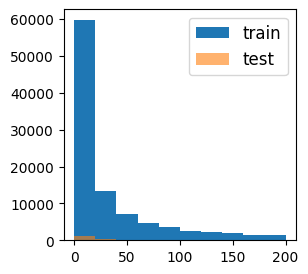

In [2]:
## Parameter setup
# Load data
batchNormType='BE00Asso00_normNone'
dataName='linear-moderate'
keywords = ['050725']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)


# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

plot_simulation_data(train_df, test_df)

## Ray Tune
### Network Setup

In [4]:
def to_tune_config(hyperparams):
    """
    Convert a normal dictionary of hyperparameter values to Ray Tune-compatible formats.

    Args:
        hyperparams (dict): Dictionary of hyperparameters with values as single values, ranges, or lists. Examples:

    Returns:
        dict: Ray Tune-compatible search space.
    """
    if hyperparams is None:
        raise ValueError("No hyperparameters given. Input parameter values to convert into Tune compatible format.")

    tune_config = {}
    for key, value in hyperparams.items():
        # Check if value is a list: Use tune.choice
        if isinstance(value, list):
            tune_config[key] = tune.choice(value)
        
        # Check if value is a tuple with two values: Use tune.uniform or tune.randint
        elif isinstance(value, tuple) and len(value) == 2:
            if all(isinstance(v, int) for v in value):  # Integers: use randint
                tune_config[key] = tune.randint(value[0], value[1])
            else:  # Floats: use uniform
                tune_config[key] = tune.uniform(value[0], value[1])
        
        # Check if value is a tuple with "log" indicator: Use tune.loguniform
        elif isinstance(value, tuple) and len(value) == 3 and value[2] == "log":
            tune_config[key] = tune.loguniform(value[0], value[1])
        
        # Single value: Keep as-is (constant)
        else:
            tune_config[key] = value

    return tune_config

In [10]:
from abc import ABC, abstractmethod

class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, 
                time_col='time', status_col='status',
                dataName=None, hyperparameters=None, random_state=42):
        self.train_df=train_df
        self.test_df=test_df
        self.n = train_df.shape[0]
        self.time_col = time_col
        self.status_col = status_col
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.random_state = random_state
        self.model = None
        self.modelString = 'deepsurv-torch'
    
    def _preprocess_data(self, df):
        """Use StandardScaler() to transform input miRNA data.
        Return transformed features and labels (survival time and censor status) separately.
        """
        survival_cols = [self.time_col, self.status_col]
        covariate_cols = [col for col in df.columns if col not in survival_cols]
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        x_mapper = DataFrameMapper(standardize)

        # transform features (miRNA expression)
        x = x_mapper.fit_transform(df[covariate_cols]).astype('float32')
        # prepare labels (survival data)
        get_target = lambda df: (df[self.time_col].values, df[self.status_col].values)
        y = get_target(df)
        
        return x, y
    
    def _train_mlp(self, train_df, val_df, config, patience, min_delta, verbose=False, is_tuning=False):
        """Training function that works for both tuning and main training.

        Args:
            x_train (pandas DataFrame): _description_
            y_train (pandas DataFrame): _description_
            config (dictionary): neural network training parameters
                - 'batch_size': batch size
                - 'epochs': number of training epochs
                - 'num_nodes': hidden layer size
                - 'learning_rate'
                - 'dropout'
                - ...
        """
        output_size   = 1 
        num_nodes     = [32, 32] if 'num_nodes' not in config.keys() else config['num_nodes']
        batch_norm    = True if 'batch_norm' not in config.keys() else config['batch_norm'] 
        output_bias   = True if 'output_bias' not in config.keys() else config['output_bias']
        dropout       = 0.2 if 'dropout' not in config.keys() else config['dropout']
        learning_rate = 1e-3 if 'learning_rate' not in config.keys() else config['learning_rate']
        batch_size    = 32 if 'batch_size' not in config.keys() else config['batch_size']
        epochs        = 100 if 'epochs' not in config.keys() else config['epochs']
        
        # Prepare data 
        x_train, y_train = self._preprocess_data(train_df)
        val = self._preprocess_data(val_df)
        x_val, y_val = val
        input_size = x_train.shape[1]

        
        # =================== Build Neural Net ===================
        ## define network
        net = tt.practical.MLPVanilla(in_features=input_size,
                                    out_features=output_size,
                                    num_nodes=num_nodes,
                                    dropout=dropout, 
                                    batch_norm=batch_norm,
                                    output_bias=output_bias)
        # define optimizer 
        optimizer = tt.optim.Adam(weight_decay=0.01)
        model = CoxPH(net, optimizer)
        model.optimizer.set_lr(learning_rate)

        # =================== Train Model =====================
        callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
        start = time.time() # Record iteration start time
        log = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks, 
                        verbose=False if is_tuning else verbose, # print training steps
                        val_data=val, val_batch_size=batch_size
                        )
        stop = time.time() # Record time when training finished
        duration = round(stop - start, 2)
        
        # =================== Evaluation ===================
        _ = model.compute_baseline_hazards()
        val_surv = model.predict_surv_df(x_val)
        val_c_index  = EvalSurv(val_surv, y_val[0], y_val[1], censor_surv='km').concordance_td() 
        
        tr_surv = model.predict_surv_df(x_train)
        tr_c_index  = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km').concordance_td() 
        
        if not is_tuning:
            self.model = model
            self.optimizer = optimizer
            
        return duration, tr_c_index, val_c_index
    
    
    def _objective_with_cv(self, train_df, config, n_splits):
        """Perform K-Fold CV and return the average validation loss across folds.""" 
                
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        val_c_indexes = []

        for train_index, val_index in kf.split(train_df, train_df[self.status_col]):
            tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

            # Train and evaluate on the current fold -- validation score
            *_, val_c_index = self._train_mlp(tr_df, val_df,
                                            config=config,
                                            patience=10, min_delta=1e-2,
                                            verbose=False,
                                            is_tuning=True)
            val_c_indexes.append(val_c_index)

        # Calculate average validation c index score across folds
        tune.report(c_index=np.mean(val_c_indexes))
    
    
    def tune_hyperparameters(self, train_df,
                            config=None, n_splits=5,
                            num_samples=10, max_t=20, grace_period=1,
                            n_cpu=2, n_gpu=0):
        """Method to perform hyperparameter tuning with K-Fold CV."""
        
        # Define search space
        self.hyperparameters = config if config is not None else self.hyperparameters
        if self.hyperparameters is None:
            config = {
                "num_nodes": tune.choice([[32, 32], [16, 16]]),
                "dropout": tune.choice([0.1, 0.5]),
                "learning_rate": tune.loguniform(1e-5, 1e-3),
                "epochs": tune.choice([20]),  # Can also tune epochs if desired
                "batch_size": tune.choice([16, 32, 64])  # Optional: tune batch size
            }
        else:
            config = to_tune_config(self.hyperparameters)

        # Run tuning with the cross-validation objective
        scheduler = ASHAScheduler(metric="c_index", 
                                mode="max", 
                                max_t=max_t, 
                                grace_period=grace_period)
        tuner = tune.run(
            lambda cfg: self._objective_with_cv(train_df, cfg, n_splits=n_splits),
            config=config,
            scheduler=scheduler,
            num_samples=num_samples,
            resources_per_trial={"cpu": n_cpu, "gpu": n_gpu}
        )
        
        # Save the best hyperparameters
        self.best_params = tuner.get_best_config(metric="c_index", mode='max')
        print(f"Best trial parameters: {self.best_params.config}")
        
        
    def train_with_best_params(self, val_size=0.2, 
                            kwargs=None, 
                            patience=25, min_delta=1e-2,
                            verbose=True, print_scores=False):
        """
        Args:
            subset (_type_): _description_
            batch_sizes (_type_): _description_
            val_size (float, optional): _description_. Defaults to 0.2.
            kwargs (_type_, optional): _description_. Defaults to None.
            time_col (str, optional): _description_. Defaults to 'time'.
            status_col (str, optional): _description_. Defaults to 'status'.
            verbose (bool, optional): _description_. Defaults to True.
            print_scores (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if kwargs is None and self.best_params is None:
            raise ValueError("No hyperparameters found. Run tune_hyperparameters() first or define them manually.")
        elif kwargs is None:
            kwargs = self.best_params
        
        # ===================== Prepare Data =======================
        tr_df, val_df = train_test_split(self.train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=self.random_state,
                                        stratify=self.train_df[self.status_col])
        
        # ===================== Train Model =====================
        duration, train_c, _ = self._train_mlp(tr_df, val_df, config=kwargs, 
                                            patience=patience, min_delta=min_delta,
                                            verbose=verbose, is_tuning=False)

        # ===================== Evaluation =====================
        x_test, y_test = self._preprocess_data(self.test_df)
        te_surv = self.model.predict_surv_df(x_test)
        test_c  = EvalSurv(te_surv, y_test[0], y_test[1], censor_surv='km').concordance_td()
        
        if print_scores:
            print(f"N={self.n} Training time ({duration}s): Train C-Index: {round(train_c,3)} | Test C-index: {round(test_c,3)}")
            
        return duration, train_c, test_c
    
    
    def write(self, model_results, out_dir=None, fileName='model.results.txt'):
        out_dir=os.path.join('models', self.dataName, self.modelString) if out_dir is None else out_dir
        os.makedirs(out_dir, exist_ok=True)
        
        # save results as txt or csv file
        if 'txt' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
        elif 'csv' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), index=False)
        else:
            print('Please specify a file name with either a txt or csv extension.')  


In [6]:
## Function to plot simulated data -- later add to utils!!
def plot_simulation_data(train_df, test_df):
    # observe data
    print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
    print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
    print('Survival time distribution:')
    _, ax = plt.subplots(figsize=(3,3))
    ax.hist(train_df['time'], label='train')
    # ax.hist(val_df['time'],   label='val', alpha=.8)
    ax.hist(test_df['time'], label='test', alpha=0.6)
    ax.legend(fontsize=12)
    plt.show()

### Parameter Setup

In [6]:
# subset = [50, 500, 1000, 2000, 5000, 8000]
# batch_sizes = [8, 16, 16, 32, 64, 128] #[8, 16, 16, 32, 32, 64]

parameters = {
    'num_nodes': [32, 32],
    'batch_norm': True,
    'output_bias': True,
    'dropout': 0.2,
    'batch_size': 64,
    'learning_rate': 1e-3
}

hyperparams =  {
        "num_nodes": [[32, 32], [16, 16]],       # list for tune.choice
        "dropout": [0.1, 0.5]                    # tuple for tune.uniform
        # "learning_rate": (1e-5, 1e-3, "log"),  # tuple with "log" for tune.loguniform
        # "batch_size": [32, 64]                 # single value, unchanged
    }
to_tune_config(hyperparams)

{'num_nodes': <ray.tune.search.sample.Categorical at 0x7f4c15d130a0>,
 'dropout': <ray.tune.search.sample.Categorical at 0x7f4c15d134c0>}

In [7]:
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (8000, 1035)
Testing data dimensions:  (2000, 1035)


In [ ]:
import ray
ray.shutdown()
ray.init()

2024-11-15 09:47:29,805	INFO worker.py:1752 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.8.10', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

In [15]:
hyperparams = {"num_nodes": [[32, 32], [16, 16]]}
ds = DeepSurvPipeline(train_df, test_df, hyperparameters=hyperparams)
ds.tune_hyperparameters(train_df, n_cpu=2)
ds.best_params
# ds.train_with_best_params(subset, time_col='t', status_col='delta',
#                             batch_sizes=[8],
#                             patience=25, min_delta=1e-2, 
#                             kwargs=parameters, verbose=False, print_scores=True)

2024-11-15 09:52:20,493	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-11-15 09:52:20,704	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


2024-11-15 09:55:28,149	WARNING tune.py:229 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-15 09:55:28,162	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20' in 0.0114s.
2024-11-15 09:55:28,186	INFO tune.py:1048 -- Total run time: 187.69 seconds (187.44 seconds for the tuning loop).
2024-11-15 09:55:28,188	WARNING tune.py:1063 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-11-15 09:55:28,207	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 10 trial(s):
- lambda_3751e_00000: FileNotFoundError('Could not fetch metrics for lambda_3751e_00000: both result.json and progress.csv were not found at /home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20/

AttributeError: 'NoneType' object has no attribute 'config'

In [ ]:
ray.nodes()

# Train on Data with Batch

## TCGA real world data

In [ ]:
brca_clin  = pd.read_csv(os.path.join("data", "batch", "TCGA_miRNA_clinical.csv"))
brca_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-BRCA-3.csv"), index_col=0)

brca_clin = brca_clin.rename(columns={'bcr_patient_barcode':'Sample'})

brca = pd.merge(brca_mirna, brca_clin, on='Sample', how = 'left')
brca_df = brca.loc[:, ['days_to_death', 
                       'days_to_last_followup'] +
                    [col for col in brca.columns if 'hsa' in col]]

Number of events: 102
Number of censored cases: 912


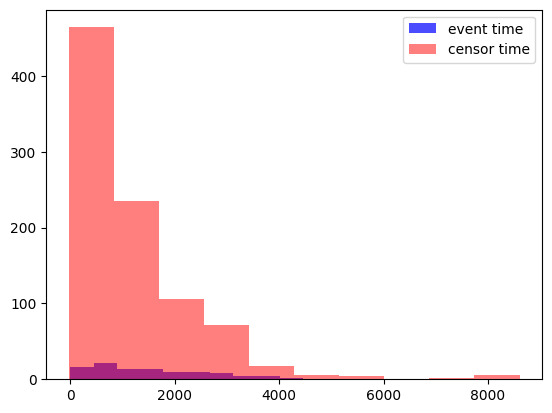

In [ ]:
deathtt = brca_df['days_to_death'][~np.isnan(brca_df['days_to_death'])]
censortt = brca_df['days_to_last_followup'][~np.isnan(brca_df['days_to_last_followup'])]
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# get censoring status and survival time
brca_df['status'] = [int(i) for i in ~np.isnan(brca_df['days_to_death'])]

brca_df['time'] = brca_df['days_to_death']
brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]

/tmp/ipykernel_777201/4163331497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]


In [ ]:
brca_df = brca_df.drop(columns=['days_to_death',"days_to_last_followup"])
brca_df = brca_df.dropna().reset_index(drop=True)

In [ ]:
print("Event rate in the TCGA BRCA data: %f" % (sum(brca_df['status']) / brca_df.shape[0]))

Event rate in the TCGA BRCA data: 0.100592


In [ ]:
learning_rate = 1e-4
parameters = {
    'num_nodes': [64, 32, 32],
    'out_features': 1,
    'batch_norm' :True,
    'dropout' : 0.2,
    'output_bias' : True
}

In [ ]:
train_df, test_df = train_test_split(brca_df, test_size=0.2, random_state=42, stratify=brca_df['status'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="tcga-brca")
ds_results = ds.run_deepsurv(subset,
                            batch_sizes=[32],
                            patience=25, min_delta=1e-3,
                            kwargs=parameters, verbose=True, print_scores=False)
ds_results

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
10:	[0s / 0s],	
11:	[0s / 0s],	
12:	[0s / 0s],	
13:	[0s / 0s],	
14:	[0s / 0s],	
15:	[0s / 1s],	
16:	[0s / 1s],	
17:	[0s / 1s],	
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 1s],	


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

n train  train time  train score  test score
0      811        1.68     0.437989     0.51035

## Simulated data with batch

In [20]:
# load simulated data
df_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_withBatch.csv")).iloc[:, 1:]
df_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_noBatch.csv")).iloc[:, 1:]

df_withBatch.head()

t  delta  A_25_P00010019  A_25_P00010020  A_25_P00010021  \
0  54.77      0        5.414510        5.361662        5.310293   
1   9.63      1        5.645660        5.628909        5.428349   
2  35.93      0        5.556705        5.498588        5.415355   
3  71.84      0        5.107029        4.998545        5.001954   
4  20.52      1        5.715634        5.554129        5.560682   

   A_25_P00010023  A_25_P00010041  A_25_P00010042  A_25_P00010043  \
0        5.324175        5.303017        5.280794        5.155670   
1        5.476566        5.651610        5.433626        5.502592   
2        5.568460        5.446503        5.393021        5.474867   
3        4.976329        5.009803        4.983482        4.873145   
4        5.429897        5.525073        5.539028        5.455037   

   A_25_P00010044  ...  A_25_P00016269  A_25_P00016270  A_25_P00016271  \
0        5.133808  ...        5.464329        5.540626        5.496476   
1        5.512356  ...        6.003386        6.206899        6.001569   
2        5.342807  ...        5.669618        5.745632        5.669056   
3        4.878836  ...        5.203232        5.211459        5.179419   
4        5.461786  ...        6.043570        6.009590        6.041434   

   A_38_P00018874  A_38_P00018875  A_38_P00018876  A_38_P00018877  \
0        5.476537        5.370435        5.593264        5.664620   
1        5.825270        5.861964        6.057292        6.187139   
2        5.699790        5.704279        5.976060        5.899931   
3        4.940771        4.868911        5.083392        5.119356   
4        5.494935        5.562034        5.585995        5.702457   

   A_38_P00018878  A_38_P00018879  batch_id  
0        5.554928        5.877363         1  
1        6.776756        7.332764         1  
2        6.011728        6.423470         1  
3        5.026625        5.225131         1  
4        5.546448        5.863067         1  

[5 rows x 3526 columns]

In [ ]:
train_df, test_df = train_test_split(df_withBatch, test_size=0.2, random_state=42, stratify=df_withBatch['delta'])

# subset = [train_df.shape[0]]
# ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
# ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
#                             batch_sizes=[8],
#                             patience=25, min_delta=1e-2, 
#                             kwargs=parameters, verbose=False, print_scores=True)
# ds_results

NameError: name 'df_withBatch' is not defined

In [ ]:
train_df, test_df = train_test_split(df_noBatch, test_size=0.2, random_state=42, stratify=df_noBatch['delta'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
                            batch_sizes=[8],
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=True, print_scores=True)

0:	[0s / 0s],		train_loss: 1.4430,	val_loss: 2.2770
1:	[0s / 0s],		train_loss: 1.2151,	val_loss: 1.8226
2:	[0s / 0s],		train_loss: 1.1575,	val_loss: 1.6374
3:	[0s / 0s],		train_loss: 1.1089,	val_loss: 1.5421
4:	[0s / 0s],		train_loss: 1.1016,	val_loss: 1.4289
5:	[0s / 0s],		train_loss: 1.0703,	val_loss: 1.3313
6:	[0s / 0s],		train_loss: 1.0573,	val_loss: 1.3368
7:	[0s / 0s],		train_loss: 1.0322,	val_loss: 1.3628
8:	[0s / 0s],		train_loss: 1.0965,	val_loss: 1.1529
9:	[0s / 0s],		train_loss: 0.9755,	val_loss: 1.1564
10:	[0s / 0s],		train_loss: 1.0619,	val_loss: 1.2399
11:	[0s / 0s],		train_loss: 0.9085,	val_loss: 1.2943
12:	[0s / 0s],		train_loss: 0.9006,	val_loss: 1.3940
13:	[0s / 0s],		train_loss: 0.8678,	val_loss: 1.2190
14:	[0s / 0s],		train_loss: 0.8291,	val_loss: 1.1011
15:	[0s / 0s],		train_loss: 0.9967,	val_loss: 1.1122
16:	[0s / 0s],		train_loss: 0.8468,	val_loss: 1.2879
17:	[0s / 0s],		train_loss: 0.8151,	val_loss: 1.4811
18:	[0s / 0s],		train_loss: 0.9106,	val_loss: 1.2335
19:

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

# Train on Simulation Data

In [ ]:
subset_sizes=[100, 500, 1000, 2000, 5000, 10000]
runs_per_size=[20,20,20,20,20,20]
splits_per_size=[3,5,5,10,10,10]
trials_per_size=[25,25,25,25,25,25]
hyperparameters = {
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "batch_size": {"type": "categorical", "choices": [128, 64, 32, 16]}
}

## BE00Asso00normNone

### Linear: Moderate

In [108]:
# dataNames = ['linear-moderate', 'linear-weak','nl-quadratic','nl-interaction','nl-sine']

# for name in dataNames:

#     optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name=f"BE00Asso00_normNone-{name}-100")
#     optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name=f"BE00Asso00_normNone-{name}-500")
#     optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name=f"BE00Asso00_normNone-{name}-1000")
#     optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name=f"BE00Asso00_normNone-{name}-2000")
#     optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name=f"BE00Asso00_normNone-{name}-5000")

In [ ]:
# Load data
batchNormType='BE00Asso00_normNone'
dataName='nl-shiftquad'
keywords = ['061125']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
plot_simulation_data(train_df, test_df)

In [5]:
ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)

# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=[2000],#subset_sizes, 
                                runs_per_size=[20],#runs_per_size, 
                                splits_per_size=[10],#splits_per_size,
                                trials_per_size=[5],#trails_per_size,
                                is_tune=True, 
                                is_save=False, 
                                n_jobs=-1,
                                trial_threshold=50,
                                fileName='model.results.test.txt'                                
)
# ds.write(model_results)
model_results

Running for N=2000...


[I 2025-06-11 12:39:18,514] A new study created in RDB with name: BE00Asso00_normNone-nl-shiftquad-2000


Starting hyperparam tuning: ['num_nodes', 'dropout', 'weight_decay', 'learning_rate', 'batch_size']


[I 2025-06-11 12:42:05,562] Trial 1 finished with value: 0.6436353849151364 and parameters: {'num_nodes': [64, 64], 'dropout': 0.26179654050733536, 'weight_decay': 0.0012910731863902925, 'learning_rate': 0.0006718511446410147, 'batch_size': 128}. Best is trial 1 with value: 0.6436353849151364.
[I 2025-06-11 12:42:43,460] Trial 2 finished with value: 0.6471862140249123 and parameters: {'num_nodes': [32, 32], 'dropout': 0.15722191703192237, 'weight_decay': 0.001022464944771599, 'learning_rate': 0.008500389442915922, 'batch_size': 64}. Best is trial 2 with value: 0.6471862140249123.
[I 2025-06-11 12:43:00,665] Trial 3 finished with value: 0.6351764826266928 and parameters: {'num_nodes': [16, 16], 'dropout': 0.19260513253887362, 'weight_decay': 0.001682515652029702, 'learning_rate': 0.0013604865413879986, 'batch_size': 64}. Best is trial 2 with value: 0.6471862140249123.
[I 2025-06-11 12:44:26,430] Trial 0 finished with value: 0.6541553962417549 and parameters: {'num_nodes': [64, 64], 'dro

Found best hyperparameters: {'num_nodes': [32, 32], 'dropout': 0.3982553088141435, 'weight_decay': 6.601169046362002e-05, 'learning_rate': 0.0007099041822497433, 'batch_size': 16}
(Avg. runtime: 14.10s)   |                (C-index)  Train: 0.786, Test: 0.647   |                (Brier)  Train: 0.092, Test: 0.14 (Mean)



n train  train time   train C    test C  train brier  test brier
0      2000       14.88  0.807668  0.655071     0.085376    0.136749
1      2000       13.97  0.789160  0.644055     0.088904    0.139621
2      2000       13.58  0.782010  0.648907     0.093491    0.137657
3      2000       16.04  0.806131  0.657213     0.080934    0.140080
4      2000       13.76  0.783975  0.647518     0.090842    0.141043
5      2000       13.30  0.771296  0.644607     0.097525    0.140199
6      2000       12.87  0.768755  0.642702     0.103159    0.140532
7      2000       13.71  0.797126  0.650832     0.085338    0.142755
8      2000       13.81  0.772996  0.638785     0.101070    0.139865
9      2000       14.34  0.791080  0.651026     0.084315    0.141193
10     2000       13.87  0.781195  0.643873     0.088989    0.141829
11     2000       15.15  0.795091  0.645433     0.091054    0.141378
12     2000       14.00  0.791414  0.650934     0.092818    0.141084
13     2000       14.71  0.795702  0.652154     0.089074    0.140417
14     2000       12.87  0.776504  0.649353     0.097439    0.140317
15     2000       14.14  0.782024  0.644544     0.093991    0.139101
16     2000       13.72  0.771890  0.643452     0.096757    0.142327
17     2000       14.60  0.792795  0.650555     0.088273    0.139747
18     2000       14.71  0.792585  0.647054     0.084839    0.141482
19     2000       14.04  0.776884  0.640157     0.096452    0.140861

In [33]:
study=optuna.load_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name="BE00Asso00_normNone-linear-moderate-100")
print(f"Sampler is {study.sampler.__class__.__name__}")
optuna.visualization.plot_optimization_history(study).show() # Optimization records
optuna.visualization.plot_param_importances(study).show()  # Hyperparam importance

Sampler is TPESampler


In [20]:
# {'learning_rate': 0.0026546611830762187, 'dropout': 0.5} \
# N=50 Training time (5.182s): Train C-Index: 0.692 | Test C-index: 0.536 (Mean)\
# {'learning_rate': 0.0008244158673895692, 'dropout': 0.5}\
# N=500 Training time (63.790000000000006s): Train C-Index: 0.884 | Test C-index: 0.7 (Mean)\
# {'learning_rate': 0.0007641732585905166}\
# N=1000 Training time (11.64s): Train C-Index: 0.903 | Test C-index: 0.771 (Mean)\
# {'dropout': 0.5}\
# N=2000 Training time (4.886s): Train C-Index: 0.891 | Test C-index: 0.809 (Mean)\
# {'dropout': 0.1}\
# N=5000 Training time (6.782000000000001s): Train C-Index: 0.884 | Test C-index: 0.832 (Mean)

### Linear: Weak

Training data dimensions: (98000, 541)
Testing data dimensions:  (2000, 540)
Event rate in train set: 0.745704
Event rate in test set: 0.750000
Survival time distribution:


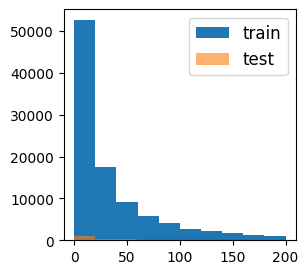

In [10]:
# Load data
batchNormType='BE00Asso00_normNone'
dataName='linear-weak'
keywords = ['042925']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)

# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
plot_simulation_data(train_df, test_df)

In [ ]:
subset_sizes=[100, 500, 1000, 2000, 5000]
runs_per_size=[20,20,20,20,20]
splits_per_size=[3,5,5,10,10]
trials_per_size=[20,20,20,20,20]
hyperparameters = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1, 0.5]},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)
# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=subset_sizes, 
                                runs_per_size=runs_per_size, 
                                splits_per_size=splits_per_size,
                                trials_per_size=[10,10,10,10,10],
                                is_tune=True, 
                                is_save=True, 
                                n_jobs=16,
                                trial_threshold=20
)
# ds.write(model_results)
model_results

Running for N=100...


[I 2025-04-24 17:26:31,450] Using an existing study with name 'BE00Asso00_normNone-linear-weak-100' instead of creating a new one.


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 17:27:07,389] Trial 19 finished with value: 0.6554249152672078 and parameters: {'learning_rate': 0.009942335691976686, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.00027228844685696065}. Best is trial 3 with value: 0.6960659884103721.
[I 2025-04-24 17:27:07,433] Trial 11 finished with value: 0.56323984533637 and parameters: {'learning_rate': 0.00043793638695293724, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.00022920535405748137}. Best is trial 3 with value: 0.6960659884103721.
[I 2025-04-24 17:27:07,931] Trial 15 finished with value: 0.6409080997487636 and parameters: {'learning_rate': 0.009453625540435056, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.0002797638622277682}. Best is trial 3 with value: 0.6960659884103721.
[I 2025-04-24 17:27:08,236] Trial 13 finished with value: 0.6687265946375146 and parameters: {'learning_rate': 0.00973556551999458, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.0003313957645417985}. Best is

Found best hyperparameters: {'learning_rate': 0.009272573605247076, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.001129933411803386}
(Avg. runtime: 0.47s)   |                (C-index)  Train: 0.787, Test: 0.588   |                (Brier)  Train: 0.135, Test: 0.178 (Mean)

Running for N=500...


[I 2025-04-24 17:27:38,944] Using an existing study with name 'BE00Asso00_normNone-linear-weak-500' instead of creating a new one.


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 17:29:01,251] Trial 16 finished with value: 0.6842857375071867 and parameters: {'learning_rate': 0.009802304987182823, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.0015101436510883877}. Best is trial 16 with value: 0.6842857375071867.
[I 2025-04-24 17:29:01,313] Trial 18 finished with value: 0.675689075876629 and parameters: {'learning_rate': 0.008101975076742688, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.00134774153827111}. Best is trial 16 with value: 0.6842857375071867.
[I 2025-04-24 17:29:03,170] Trial 17 finished with value: 0.6849494485349195 and parameters: {'learning_rate': 0.00792627835790344, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.0015792395488589159}. Best is trial 17 with value: 0.6849494485349195.
[I 2025-04-24 17:29:03,320] Trial 15 finished with value: 0.6928025679079853 and parameters: {'learning_rate': 0.009500564070934147, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.00112935472705179}. Best is tri

Found best hyperparameters: {'learning_rate': 0.007730549040631597, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.0010111051064241186}
(Avg. runtime: 0.77s)   |                (C-index)  Train: 0.768, Test: 0.636   |                (Brier)  Train: 0.145, Test: 0.184 (Mean)

Running for N=1000...


[I 2025-04-24 17:29:41,399] A new study created in RDB with name: BE00Asso00_normNone-linear-weak-1000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 17:31:09,967] Trial 8 finished with value: 0.6726067314328334 and parameters: {'learning_rate': 0.004728871113080312, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 1.3123531384736592e-05}. Best is trial 8 with value: 0.6726067314328334.
[I 2025-04-24 17:31:14,991] Trial 3 finished with value: 0.6689519423764191 and parameters: {'learning_rate': 0.002266537622851718, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 0.0003758596030673717}. Best is trial 8 with value: 0.6726067314328334.
[I 2025-04-24 17:31:24,326] Trial 1 finished with value: 0.6417280889488974 and parameters: {'learning_rate': 0.0009045551792515649, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 1.4135891108710096e-05}. Best is trial 8 with value: 0.6726067314328334.
[I 2025-04-24 17:31:31,976] Trial 4 finished with value: 0.6302184116553443 and parameters: {'learning_rate': 0.00018541831072650336, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 1.3671607599213705e-05}. Best i

Found best hyperparameters: {'learning_rate': 0.002369289731519491, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 0.0004311975584248432}
(Avg. runtime: 1.01s)   |                (C-index)  Train: 0.754, Test: 0.652   |                (Brier)  Train: 0.134, Test: 0.157 (Mean)

Running for N=2000...


[I 2025-04-24 17:32:20,973] A new study created in RDB with name: BE00Asso00_normNone-linear-weak-2000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 17:36:10,147] Trial 6 finished with value: 0.6847299176231603 and parameters: {'learning_rate': 0.003515448310859883, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.00030540334864295076}. Best is trial 6 with value: 0.6847299176231603.
[I 2025-04-24 17:36:32,642] Trial 2 finished with value: 0.6524996557360268 and parameters: {'learning_rate': 0.000475371904082213, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.00013391112380562803}. Best is trial 6 with value: 0.6847299176231603.
[I 2025-04-24 17:36:57,703] Trial 9 finished with value: 0.6567724550404093 and parameters: {'learning_rate': 0.0005248948011381326, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 1.9087172154375606e-05}. Best is trial 6 with value: 0.6847299176231603.
[I 2025-04-24 17:37:28,883] Trial 3 finished with value: 0.6917906309630479 and parameters: {'learning_rate': 0.008212699758992737, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.009552766946078815}. Best is t

Found best hyperparameters: {'learning_rate': 0.008212699758992737, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.009552766946078815}
(Avg. runtime: 1.68s)   |                (C-index)  Train: 0.751, Test: 0.674   |                (Brier)  Train: 0.146, Test: 0.167 (Mean)

Running for N=5000...


[I 2025-04-24 17:39:20,177] A new study created in RDB with name: BE00Asso00_normNone-linear-weak-5000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 17:46:09,973] Trial 1 finished with value: 0.6996846052727781 and parameters: {'learning_rate': 0.0030367504897220693, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.0029026950508803566}. Best is trial 1 with value: 0.6996846052727781.
[I 2025-04-24 17:46:17,256] Trial 3 finished with value: 0.6923203577124394 and parameters: {'learning_rate': 0.001337535977264488, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.0002641590225417784}. Best is trial 1 with value: 0.6996846052727781.
[I 2025-04-24 17:46:41,304] Trial 4 finished with value: 0.6947988557803066 and parameters: {'learning_rate': 0.0012971926719946975, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.0007682741542761834}. Best is trial 1 with value: 0.6996846052727781.
[I 2025-04-24 17:47:01,416] Trial 5 finished with value: 0.6804991670442454 and parameters: {'learning_rate': 0.0004951081361161364, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.00013213302640163973}. Best is 

Found best hyperparameters: {'learning_rate': 0.006681146433338697, 'num_nodes': [32, 32], 'dropout': 0.5, 'weight_decay': 0.00031126056075662955}
(Avg. runtime: 3.55s)   |                (C-index)  Train: 0.755, Test: 0.696   |                (Brier)  Train: 0.141, Test: 0.16 (Mean)



n train  train time   train C    test C  train brier  test brier
0       100        0.48  0.782479  0.625375     0.062124    0.086006
1       100        0.43  0.741481  0.568684     0.179939    0.224314
2       100        0.49  0.820407  0.592440     0.155248    0.218425
3       100        0.45  0.745783  0.577408     0.173561    0.225392
4       100        0.45  0.780451  0.574633     0.173038    0.222698
..      ...         ...       ...       ...          ...         ...
95     5000        3.26  0.733546  0.692385          NaN         NaN
96     5000        3.46  0.768207  0.695839     0.143187    0.169377
97     5000        3.27  0.729960  0.697994     0.168167    0.179987
98     5000        3.26  0.731591  0.693675     0.164179    0.176848
99     5000        3.37  0.753005  0.694845     0.072770    0.081326

[100 rows x 6 columns]

### Nonlinear: Quadratic

Training data dimensions: (98000, 541)
Testing data dimensions:  (2000, 540)
Event rate in train set: 0.752112
Event rate in test set: 0.747000
Survival time distribution:
Event rate in train set: 0.752112
Event rate in test set: 0.747000
Survival time distribution:


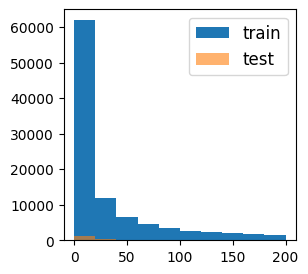

In [ ]:
# Load data
batchNormType='BE00Asso00_normNone'
dataName='nl-quadratic'
keywords = ['042325']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                initial_split=False,
                                                keep_batch=True)

# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
print('Survival time distribution:')
plot_simulation_data(train_df, test_df)

In [ ]:
subset_sizes=[100, 500, 1000, 2000, 5000]
runs_per_size=[20,20,20,20,20]
splits_per_size=[3,5,5,10,10]
trials_per_size=[20,20,20,20,20]
hyperparameters = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1, 0.5]},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)
# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=subset_sizes, 
                                runs_per_size=runs_per_size, 
                                splits_per_size=splits_per_size,
                                trials_per_size=trials_per_size,
                                is_tune=True, 
                                is_save=True, 
                                n_jobs=16,
                                trial_threshold=20
)
# ds.write(model_results)
model_results

Running for N=100...


[I 2025-04-24 18:29:12,686] A new study created in RDB with name: BE00Asso00_normNone-nl-quadratic-100


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 18:30:25,242] Trial 0 finished with value: 0.4956813262235362 and parameters: {'learning_rate': 0.0008107115177636908, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 1.2394758703387212e-05}. Best is trial 0 with value: 0.4956813262235362.
[I 2025-04-24 18:30:27,262] Trial 3 finished with value: 0.5979585731129999 and parameters: {'learning_rate': 0.005784799730255221, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.001554539108661454}. Best is trial 3 with value: 0.5979585731129999.
[I 2025-04-24 18:30:27,272] Trial 11 finished with value: 0.513400584332203 and parameters: {'learning_rate': 0.005079205144215312, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.0027817226950626016}. Best is trial 3 with value: 0.5979585731129999.
[I 2025-04-24 18:30:32,072] Trial 5 finished with value: 0.5054235513109191 and parameters: {'learning_rate': 0.00021328979692283612, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.0075298436234190885}. Best is t

Found best hyperparameters: {'learning_rate': 0.0028659432618361883, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.009173750394075648}
(Avg. runtime: 0.49s)   |                (C-index)  Train: 0.664, Test: 0.518   |                (Brier)  Train: 0.182, Test: 0.214 (Mean)

Running for N=500...


[I 2025-04-24 18:31:17,495] A new study created in RDB with name: BE00Asso00_normNone-nl-quadratic-500


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 18:32:58,826] Trial 8 finished with value: 0.5713699918905621 and parameters: {'learning_rate': 0.006852965486972058, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.0020778978513991794}. Best is trial 8 with value: 0.5713699918905621.
[I 2025-04-24 18:33:00,956] Trial 2 finished with value: 0.5539882489242183 and parameters: {'learning_rate': 0.0010257075196167045, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.000981713097161682}. Best is trial 8 with value: 0.5713699918905621.
[I 2025-04-24 18:33:12,596] Trial 12 finished with value: 0.6134491561949216 and parameters: {'learning_rate': 0.005550944786187949, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.006290873539487694}. Best is trial 12 with value: 0.6134491561949216.
[I 2025-04-24 18:33:30,180] Trial 10 finished with value: 0.5703453980598131 and parameters: {'learning_rate': 0.0018766777214225846, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 0.00030280943737170756}. Best is 

Found best hyperparameters: {'learning_rate': 0.005550944786187949, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.006290873539487694}
(Avg. runtime: 0.74s)   |                (C-index)  Train: 0.724, Test: 0.561   |                (Brier)  Train: 0.176, Test: 0.214 (Mean)

Running for N=1000...


[I 2025-04-24 18:34:52,839] A new study created in RDB with name: BE00Asso00_normNone-nl-quadratic-1000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 18:37:14,385] Trial 7 finished with value: 0.6123753304343659 and parameters: {'learning_rate': 0.005985027853074082, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 4.3118939303025635e-05}. Best is trial 7 with value: 0.6123753304343659.
[I 2025-04-24 18:37:15,363] Trial 5 finished with value: 0.6068852869011667 and parameters: {'learning_rate': 0.00958864341308241, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 2.6499614880557167e-05}. Best is trial 7 with value: 0.6123753304343659.
[I 2025-04-24 18:37:19,685] Trial 9 finished with value: 0.6052767915048032 and parameters: {'learning_rate': 0.002310866267474196, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 1.1500069592199743e-05}. Best is trial 7 with value: 0.6123753304343659.
[I 2025-04-24 18:37:25,149] Trial 1 finished with value: 0.6013419159540379 and parameters: {'learning_rate': 0.0028141001849628015, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.00014549992861950838}. Best is 

Found best hyperparameters: {'learning_rate': 0.0025298996558349362, 'num_nodes': [64, 64], 'dropout': 0.5, 'weight_decay': 0.0004036031007012204}
(Avg. runtime: 1.13s)   |                (C-index)  Train: 0.708, Test: 0.58   |                (Brier)  Train: 0.184, Test: 0.212 (Mean)

Running for N=2000...


[I 2025-04-24 18:40:02,057] A new study created in RDB with name: BE00Asso00_normNone-nl-quadratic-2000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 18:46:15,013] Trial 12 finished with value: 0.6216178964525442 and parameters: {'learning_rate': 0.0020825659416353593, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.000505267738962287}. Best is trial 12 with value: 0.6216178964525442.
[I 2025-04-24 18:46:26,739] Trial 1 finished with value: 0.6291825036460568 and parameters: {'learning_rate': 0.0034656934862596555, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.00023802465580977276}. Best is trial 1 with value: 0.6291825036460568.
[I 2025-04-24 18:46:36,266] Trial 13 finished with value: 0.606142579294133 and parameters: {'learning_rate': 0.001785236145327149, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 0.00011522600207942337}. Best is trial 1 with value: 0.6291825036460568.
[I 2025-04-24 18:46:46,729] Trial 4 finished with value: 0.6201034291605725 and parameters: {'learning_rate': 0.001143699207781983, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 4.9739330026622546e-05}. Best i

Found best hyperparameters: {'learning_rate': 0.0028935614461513557, 'num_nodes': [32, 32], 'dropout': 0.5, 'weight_decay': 8.826714584712424e-05}
(Avg. runtime: 1.71s)   |                (C-index)  Train: 0.73, Test: 0.613   |                (Brier)  Train: 0.171, Test: 0.199 (Mean)

Running for N=5000...


[I 2025-04-24 18:53:10,320] A new study created in RDB with name: BE00Asso00_normNone-nl-quadratic-5000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 19:04:30,728] Trial 12 finished with value: 0.6655142070239036 and parameters: {'learning_rate': 0.007351420840042944, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 4.079292996200317e-05}. Best is trial 12 with value: 0.6655142070239036.
[I 2025-04-24 19:05:00,272] Trial 4 finished with value: 0.6628756582859793 and parameters: {'learning_rate': 0.0022096450033145345, 'num_nodes': [32, 32], 'dropout': 0.1, 'weight_decay': 1.3044315839569998e-05}. Best is trial 12 with value: 0.6655142070239036.
[I 2025-04-24 19:05:15,045] Trial 0 finished with value: 0.6673911081795871 and parameters: {'learning_rate': 0.0071543409072705, 'num_nodes': [16, 16], 'dropout': 0.1, 'weight_decay': 0.002524269988732223}. Best is trial 0 with value: 0.6673911081795871.
[I 2025-04-24 19:05:44,462] Trial 8 finished with value: 0.6690702684871392 and parameters: {'learning_rate': 0.007435195426377352, 'num_nodes': [64, 64], 'dropout': 0.1, 'weight_decay': 0.0019113021863749952}. Best is tr

Found best hyperparameters: {'learning_rate': 0.004868162326496549, 'num_nodes': [16, 16], 'dropout': 0.5, 'weight_decay': 1.5236896575323784e-05}
(Avg. runtime: 3.50s)   |                (C-index)  Train: 0.743, Test: 0.655   |                (Brier)  Train: 0.16, Test: 0.188 (Mean)



n train  train time   train C    test C  train brier  test brier
0       100        0.69  0.862423  0.552554     0.093293    0.184923
1       100        0.54  0.842283  0.546243          NaN         NaN
2       100        0.42  0.640770  0.516631          NaN         NaN
3       100        0.42  0.604779  0.509040          NaN         NaN
4       100        0.54  0.604081  0.484707     0.158860    0.205356
..      ...         ...       ...       ...          ...         ...
95     5000        3.38  0.735798  0.651753     0.168106    0.193132
96     5000        3.38  0.734007  0.656552     0.165355    0.187679
97     5000        3.77  0.779593  0.673583     0.144769    0.183756
98     5000        3.37  0.735544  0.656968     0.166771    0.190595
99     5000        3.68  0.792688  0.667611     0.143165    0.186294

[100 rows x 6 columns]

In [ ]:
# {'learning_rate': 0.0015890814833935034, 'dropout': 0.1}
# N=50 Training time (0.11833333333333335s): Train C-Index: 0.755 | Test C-index: 0.507 (Mean)
# {'learning_rate': 0.004437688519422004, 'num_nodes': [32, 32], 'dropout': 0.1}
# N=500 Training time (0.4383333333333333s): Train C-Index: 0.736 | Test C-index: 0.585 (Mean)
# {'learning_rate': 0.005240711451605818, 'dropout': 0.1}
# N=1000 Training time (1.035s): Train C-Index: 0.691 | Test C-index: 0.583 (Mean)
# {'learning_rate': 0.0014286264369105714, 'dropout': 0.1}
# N=2000 Training time (1.9366666666666668s): Train C-Index: 0.777 | Test C-index: 0.634 (Mean)
# {'learning_rate': 0.0006976857427331728, 'num_nodes': [16, 16], 'dropout': 0.1}
# N=5000 Training time (4.76s): Train C-Index: 0.785 | Test C-index: 0.683 (Mean)

### Nonlinear: Interaction

Training data dimensions: (98000, 541)
Testing data dimensions:  (2000, 540)
Survival time distribution:
Event rate in train set: 0.753806
Event rate in test set: 0.752500
Survival time distribution:


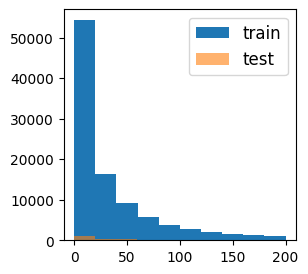

In [ ]:
# prepare data
# Load data
batchNormType='BE00Asso00_normNone'
dataName='nl-interaction'
keywords = ''
train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                initial_split=False,
                                                keep_batch=True)

# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
print('Survival time distribution:')
plot_simulation_data(train_df, test_df)

In [ ]:
# optuna.study.delete_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name="BE00Asso00_normNone-nl-interaction-100")

In [ ]:
subset_sizes=[100, 500, 1000, 2000, 5000]
runs_per_size=[20,20,20,20,20]
splits_per_size=[3,5,5,10,10]
trials_per_size=[20,20,20,20,20]
hyperparameters = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)
# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=subset_sizes, 
                                runs_per_size=runs_per_size, 
                                splits_per_size=splits_per_size,
                                trials_per_size=trials_per_size,
                                is_tune=True, 
                                is_save=True, 
                                n_jobs=20,
                                trial_threshold=30
)
# ds.write(model_results)
model_results

Running for N=100...


[I 2025-04-24 20:53:45,963] A new study created in RDB with name: BE00Asso00_normNone-nl-interaction-100


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 20:55:10,724] Trial 1 finished with value: 0.533568121148421 and parameters: {'learning_rate': 0.00020636289152100462, 'num_nodes': [16, 16], 'dropout': 0.17263275923036953, 'weight_decay': 0.0036722694328008617}. Best is trial 1 with value: 0.533568121148421.
[I 2025-04-24 20:55:15,613] Trial 7 finished with value: 0.4239207081284169 and parameters: {'learning_rate': 0.00016839215611284556, 'num_nodes': [16, 16], 'dropout': 0.33720168553916896, 'weight_decay': 1.2221453576022909e-05}. Best is trial 1 with value: 0.533568121148421.
[I 2025-04-24 20:55:17,541] Trial 4 finished with value: 0.46439539523051304 and parameters: {'learning_rate': 0.0002930017946583047, 'num_nodes': [32, 32], 'dropout': 0.4092746738051313, 'weight_decay': 0.00016143397431965593}. Best is trial 1 with value: 0.533568121148421.
[I 2025-04-24 20:55:17,776] Trial 5 finished with value: 0.44815246217815813 and parameters: {'learning_rate': 0.008580446123993835, 'num_nodes': [64, 64], 'dropout': 0.116

Found best hyperparameters: {'learning_rate': 0.0009348657581631831, 'num_nodes': [64, 64], 'dropout': 0.26952538727558395, 'weight_decay': 0.007794288314300399}
(Avg. runtime: 0.44s)   |                (C-index)  Train: 0.647, Test: 0.502   |                (Brier)  Train: 0.189, Test: 0.227 (Mean)

Running for N=500...


[I 2025-04-24 20:55:47,814] Using an existing study with name 'BE00Asso00_normNone-nl-interaction-500' instead of creating a new one.


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[W 2025-04-24 20:55:48,880] Trial 20 failed with parameters: {'learning_rate': 0.0018009244811264173, 'num_nodes': [16, 16]} because of the following error: ValueError('Cannot set different distribution kind to the same parameter name.').
Traceback (most recent call last):
  File "/home/nfs/dengy/dl-env/lib/python3.8/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/nfs/dengy/dl-survival-miRNA/runDeepSurvModels.py", line 337, in <lambda>
    lambda trial: self._objective(trial,
  File "/home/nfs/dengy/dl-survival-miRNA/runDeepSurvModels.py", line 251, in _objective
    tunable_params = parse_hyperparameters(trial, config=config)
  File "/home/nfs/dengy/dl-survival-miRNA/runDeepSurvModels.py", line 37, in parse_hyperparameters
    params[param_name] = trial.suggest_float(param_name, param_info["low"], param_info["high"], log=param_info.get("log", False))
  File "/home/nfs/dengy/dl-env/lib/python3.8/site-packages/optuna/tria

Found best hyperparameters: {'learning_rate': 0.0037124098356386952, 'num_nodes': [32, 32], 'dropout': 0.5, 'weight_decay': 0.002122166730223913}
(Avg. runtime: 0.65s)   |                (C-index)  Train: 0.659, Test: 0.509   |                (Brier)  Train: 0.192, Test: 0.232 (Mean)

Running for N=1000...


[I 2025-04-24 20:56:21,399] A new study created in RDB with name: BE00Asso00_normNone-nl-interaction-1000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 20:59:41,238] Trial 12 finished with value: 0.5122444611567027 and parameters: {'learning_rate': 0.00429862126054499, 'num_nodes': [16, 16], 'dropout': 0.28416349552295384, 'weight_decay': 0.000999520923659223}. Best is trial 12 with value: 0.5122444611567027.
[I 2025-04-24 20:59:43,292] Trial 10 finished with value: 0.5203530583441122 and parameters: {'learning_rate': 0.002119602625104039, 'num_nodes': [64, 64], 'dropout': 0.3178446264096326, 'weight_decay': 1.5935818723450647e-05}. Best is trial 10 with value: 0.5203530583441122.
[I 2025-04-24 20:59:46,853] Trial 6 finished with value: 0.5375996729704158 and parameters: {'learning_rate': 0.00858426836068949, 'num_nodes': [32, 32], 'dropout': 0.48090482822851355, 'weight_decay': 4.090512130474861e-05}. Best is trial 6 with value: 0.5375996729704158.
[I 2025-04-24 20:59:48,262] Trial 4 finished with value: 0.5156610612639975 and parameters: {'learning_rate': 0.003917803891521519, 'num_nodes': [32, 32], 'dropout': 0.313719

Found best hyperparameters: {'learning_rate': 0.009044376738257283, 'num_nodes': [16, 16], 'dropout': 0.3095798746866732, 'weight_decay': 0.0037648773858139644}
(Avg. runtime: 0.94s)   |                (C-index)  Train: 0.645, Test: 0.516   |                (Brier)  Train: 0.185, Test: 0.214 (Mean)

Running for N=2000...


[I 2025-04-24 21:00:42,132] A new study created in RDB with name: BE00Asso00_normNone-nl-interaction-2000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 21:08:50,488] Trial 13 finished with value: 0.5343585533632378 and parameters: {'learning_rate': 0.005276491402335034, 'num_nodes': [32, 32], 'dropout': 0.10911335954205442, 'weight_decay': 0.00010345233554489787}. Best is trial 13 with value: 0.5343585533632378.
[I 2025-04-24 21:09:17,938] Trial 6 finished with value: 0.5400630521950618 and parameters: {'learning_rate': 0.008602355198352549, 'num_nodes': [32, 32], 'dropout': 0.34414937362026, 'weight_decay': 1.9500539770173958e-05}. Best is trial 6 with value: 0.5400630521950618.
[I 2025-04-24 21:09:19,664] Trial 8 finished with value: 0.5424656533659296 and parameters: {'learning_rate': 0.0018768847327516002, 'num_nodes': [32, 32], 'dropout': 0.22762924440033286, 'weight_decay': 0.0001805087358803455}. Best is trial 8 with value: 0.5424656533659296.
[I 2025-04-24 21:09:39,488] Trial 14 finished with value: 0.5399172720180629 and parameters: {'learning_rate': 0.0035007762353492893, 'num_nodes': [32, 32], 'dropout': 0.327

Found best hyperparameters: {'learning_rate': 0.0016246539414104342, 'num_nodes': [32, 32], 'dropout': 0.45872063125447593, 'weight_decay': 0.006564050022711472}
(Avg. runtime: 1.49s)   |                (C-index)  Train: 0.619, Test: 0.525   |                (Brier)  Train: 0.188, Test: 0.206 (Mean)

Running for N=5000...


[I 2025-04-24 21:11:55,122] A new study created in RDB with name: BE00Asso00_normNone-nl-interaction-5000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay']


[I 2025-04-24 21:25:14,563] Trial 11 finished with value: 0.5483238842934004 and parameters: {'learning_rate': 0.0023479017892858883, 'num_nodes': [64, 64], 'dropout': 0.13759661325557648, 'weight_decay': 0.00013871599792530666}. Best is trial 11 with value: 0.5483238842934004.
[I 2025-04-24 21:25:52,801] Trial 2 finished with value: 0.5601897352308458 and parameters: {'learning_rate': 0.0020453555343588397, 'num_nodes': [64, 64], 'dropout': 0.21550687789826514, 'weight_decay': 5.164338142575825e-05}. Best is trial 2 with value: 0.5601897352308458.
[I 2025-04-24 21:26:00,947] Trial 13 finished with value: 0.5400818169573558 and parameters: {'learning_rate': 0.0009265231660976077, 'num_nodes': [16, 16], 'dropout': 0.13440772114994043, 'weight_decay': 0.002823157162244048}. Best is trial 2 with value: 0.5601897352308458.
[I 2025-04-24 21:26:27,445] Trial 19 finished with value: 0.5568177500118087 and parameters: {'learning_rate': 0.002860696502671692, 'num_nodes': [32, 32], 'dropout': 0.

Found best hyperparameters: {'learning_rate': 0.007208220631307991, 'num_nodes': [64, 64], 'dropout': 0.29108666781492065, 'weight_decay': 0.0016820589161547557}
(Avg. runtime: 3.35s)   |                (C-index)  Train: 0.633, Test: 0.551   |                (Brier)  Train: 0.193, Test: 0.208 (Mean)



n train  train time   train C    test C  train brier  test brier
0       100        0.46  0.572721  0.496784     0.188153    0.214781
1       100        0.41  0.611271  0.483039     0.189235    0.237813
2       100        0.41  0.585202  0.511091     0.205298    0.208947
3       100        0.41  0.536869  0.504063     0.153010    0.145637
4       100        0.41  0.493850  0.482020          NaN         NaN
..      ...         ...       ...       ...          ...         ...
95     5000        3.29  0.646198  0.549245          NaN         NaN
96     5000        3.29  0.633345  0.550225          NaN         NaN
97     5000        3.19  0.624983  0.556715          NaN         NaN
98     5000        3.29  0.639518  0.538024     0.183951    0.200316
99     5000        3.19  0.629028  0.557925     0.205321    0.218429

[100 rows x 6 columns]

In [ ]:
# {'learning_rate': 0.002899663561690444, 'dropout': 0.5}
# N=50 Training time (0.13833333333333334s): Train C-Index: 0.743 | Test C-index: 0.51 (Mean)
# {'learning_rate': 0.0017009794008026196, 'dropout': 0.1}
# N=500 Training time (0.43s): Train C-Index: 0.67 | Test C-index: 0.528 (Mean)
# {'learning_rate': 0.004912733538278034, 'dropout': 0.5}
# N=1000 Training time (1.03s): Train C-Index: 0.647 | Test C-index: 0.53 (Mean)
# {'learning_rate': 0.0007431981167338991, 'dropout': 0.5}
# N=2000 Training time (2.3966666666666665s): Train C-Index: 0.672 | Test C-index: 0.553 (Mean)
# {'learning_rate': 0.0010178200156848115, 'dropout': 0.1}
# N=5000 Training time (9.033333333333333s): Train C-Index: 0.85 | Test C-index: 0.725 (Mean)

### Nonlinear: Sine

Training data dimensions: (98000, 541)
Testing data dimensions:  (2000, 540)
Survival time distribution:
Event rate in train set: 0.747153
Event rate in test set: 0.738500
Survival time distribution:


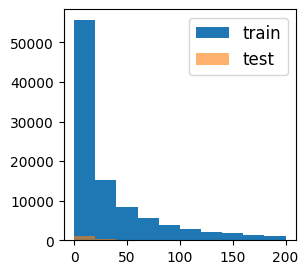

In [ ]:
# Load data
batchNormType='BE00Asso00_normNone'
dataName='nl-sine'
keywords = ['042225']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                initial_split=False,
                                                keep_batch=True)

# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
print('Survival time distribution:')
plot_simulation_data(train_df, test_df)

In [ ]:
subset_sizes=[100, 500, 1000, 2000, 5000]
runs_per_size=[20,20,20,20,20]
splits_per_size=[3,5,5,10,10]
trials_per_size=[20,20,20,30,30]
hyperparameters = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
    "batch_size": {"type": "categorical", "choices": [32,64,128]},
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters
)
# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=subset_sizes, 
                                runs_per_size=runs_per_size, 
                                splits_per_size=splits_per_size,
                                trials_per_size=trials_per_size,
                                is_tune=True, 
                                is_save=True, 
                                n_jobs=20,
                                trial_threshold=19
)
# ds.write(model_results)
model_results

Running for N=100...


[I 2025-04-24 22:57:24,838] Using an existing study with name 'BE00Asso00_normNone-nl-sine-100' instead of creating a new one.


All hyperparameters already tuned. Skipping optimization...
(Avg. runtime: 0.41s)   |                (C-index)  Train: 0.657, Test: 0.547   |                (Brier)  Train: 0.178, Test: 0.207 (Mean)

Running for N=500...


[I 2025-04-24 22:57:56,258] Using an existing study with name 'BE00Asso00_normNone-nl-sine-500' instead of creating a new one.


All hyperparameters already tuned. Skipping optimization...
(Avg. runtime: 0.67s)   |                (C-index)  Train: 0.701, Test: 0.579   |                (Brier)  Train: 0.166, Test: 0.196 (Mean)

Running for N=1000...


[I 2025-04-24 22:58:28,404] Using an existing study with name 'BE00Asso00_normNone-nl-sine-1000' instead of creating a new one.


All hyperparameters already tuned. Skipping optimization...
(Avg. runtime: 0.92s)   |                (C-index)  Train: 0.68, Test: 0.588   |                (Brier)  Train: 0.177, Test: 0.199 (Mean)

Running for N=2000...


[I 2025-04-24 22:59:05,933] Using an existing study with name 'BE00Asso00_normNone-nl-sine-2000' instead of creating a new one.


All hyperparameters already tuned. Skipping optimization...
(Avg. runtime: 1.49s)   |                (C-index)  Train: 0.67, Test: 0.601   |                (Brier)  Train: 0.168, Test: 0.182 (Mean)

Running for N=5000...


[I 2025-04-24 22:59:55,679] Using an existing study with name 'BE00Asso00_normNone-nl-sine-5000' instead of creating a new one.


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay', 'batch_size']


[I 2025-04-24 23:27:38,571] Trial 46 finished with value: 0.6247879370089714 and parameters: {'learning_rate': 0.0011493296468755687, 'num_nodes': [32, 32], 'dropout': 0.4143494920766254, 'weight_decay': 6.741271909841799e-05, 'batch_size': 32}. Best is trial 10 with value: 0.6291601140520839.
[I 2025-04-24 23:28:54,339] Trial 41 finished with value: 0.6248187768076028 and parameters: {'learning_rate': 0.0012244585799664268, 'num_nodes': [32, 32], 'dropout': 0.41022223715065387, 'weight_decay': 5.80478665545605e-05, 'batch_size': 32}. Best is trial 10 with value: 0.6291601140520839.
[I 2025-04-24 23:30:14,764] Trial 30 finished with value: 0.6256289365111873 and parameters: {'learning_rate': 0.0011989718608381662, 'num_nodes': [32, 32], 'dropout': 0.4081572160384565, 'weight_decay': 0.000833721166416508, 'batch_size': 32}. Best is trial 10 with value: 0.6291601140520839.
[I 2025-04-24 23:30:17,515] Trial 43 finished with value: 0.627595307980725 and parameters: {'learning_rate': 0.0012

Found best hyperparameters: {'learning_rate': 0.0011735534590920677, 'num_nodes': [32, 32], 'dropout': 0.4979328096567611, 'weight_decay': 6.341863410884617e-05, 'batch_size': 32}
(Avg. runtime: 3.47s)   |                (C-index)  Train: 0.671, Test: 0.616   |                (Brier)  Train: 0.17, Test: 0.182 (Mean)



n train  train time   train C    test C  train brier  test brier
0       100        0.26  0.590125  0.564806     0.209490    0.228295
1       100        0.41  0.601274  0.547614     0.110623    0.122174
2       100        0.44  0.740416  0.546613          NaN         NaN
3       100        0.40  0.632479  0.542548     0.205468    0.233278
4       100        0.42  0.731996  0.537541     0.168776    0.225339
..      ...         ...       ...       ...          ...         ...
95     5000        3.53  0.699603  0.632048     0.180299    0.194910
96     5000        3.31  0.673093  0.618568     0.122753    0.130875
97     5000        3.21  0.655769  0.609132     0.194614    0.203541
98     5000        3.32  0.690343  0.623806     0.109969    0.117105
99     5000        3.39  0.656633  0.610514     0.200594    0.213640

[100 rows x 6 columns]

In [5]:
# {'learning_rate': 0.00886724216079615, 'dropout': 0.1}
# N=50 Training time (0.08666666666666667s): Train C-Index: 0.66 | Test C-index: 0.51 (Mean)
# {'learning_rate': 0.004052497934739238, 'dropout': 0.5}
# N=500 Training time (0.7083333333333334s): Train C-Index: 0.709 | Test C-index: 0.529 (Mean)
# {'learning_rate': 0.0027288713850125833, 'dropout': 0.5}
# N=1000 Training time (1.02s): Train C-Index: 0.637 | Test C-index: 0.525 (Mean)
# {'learning_rate': 0.0023014017155613144, 'dropout': 0.5}
# N=2000 Training time (2.0549999999999997s): Train C-Index: 0.631 | Test C-index: 0.543 (Mean)
# {'learning_rate': 0.0011589206071232186, 'dropout': 0.1}
# N=5000 Training time (3.8683333333333336s): Train C-Index: 0.627 | Test C-index: 0.554 (Mean)

## Visualization

In [28]:
def plot_precisionSeq_results(batchNormType, ylim=[0.4,1]):
    
    # Initialize empty results data frame
    results = pd.DataFrame(columns=['n train', 
                                    'train time',
                                    'train C',
                                    'test C',
                                    'train brier',
                                    'test brier',
                                    'model type',
                                    'data type'])
    modelTypes = ['oracle-nl', 'oracle-linear', 'lasso', 'deepsurv-torch','rsf','svm','gb']
    dataNames = ['linear-moderate', 'linear-weak','nl-quadratic', 'nl-shiftquad', 'nl-sine', 'nl-interaction']
    
    # Read in performance scores
    for dataName in dataNames:
        for model in modelTypes:
            try:
                file_dir = glob.glob(
                    os.path.join('models', batchNormType, dataName, model, f"model_results_*.csv")
                    )[-1]
                result_df = pd.read_csv(file_dir)
            except: 
                continue
            if model in ['lasso','oracle-nl','oracle-linear']:
                result_df.columns = ["n train","train C","test C"]
            
            result_df['model type'] = model.upper() if model in ['svm','rsf','gb'] else 'oracle' if model=='oracle-nl' else model
            result_df['data type'] = dataName
            results = pd.concat([results, result_df], axis=0)
                
    # Set up facet grid
    sns.set_theme(style="whitegrid", font_scale=1)
    colors = {
        'oracle':  "#3E3E3E", #"#664848" # Brown
        'oracle-linear': "#3E3E3E",     # Medium gray
        'lasso': "#186fcc",             # Muted blue
        'deepsurv-torch': "#d01c43",    # Soft red
        'RSF': '#733381',
        'SVM': "#589C48",
        'GB': "#F58024"
        
    }
    linestyles = {
        'oracle':  "-",
        'oracle-linear': "--",
        'lasso': "-",  
        'deepsurv-torch': "-",
        'RSF': "-",
        'SVM': "-",  
        'GB': "-"
    }
    g = sns.FacetGrid(results, 
                    col="data type", col_wrap=2,
                    height=3.25, aspect=1.55, 
                    sharey=True, sharex=True
                    )
    
    # Plot individual lines and corresponding error bars
    for ax, dataName in zip(g.axes.flat, results['data type'].unique()):
        subset = (
            results[results['data type'] == dataName]
            .groupby(['data type', 'n train', 'model type'])
            .agg(mean=('test C', 'mean'),
                sd=('test C', 'std'))
            .reset_index()
        ) 
        for model in subset['model type'].unique():
            sub = subset[subset['model type'] == model]
            if sub['mean'].isna().all(): # skip oracle-nl for linear simulations
                continue 
            ax.errorbar(
                sub['n train'], sub['mean'], yerr=sub['sd'], label=model,
                color=colors[model], linestyle=linestyles[model],
                marker='o', markersize=5, linewidth=2
            )
            ax.set_ylim(ylim)
            ax.set_title(dataName)
            ax.set_xlabel("Training size")
            ax.set_ylabel("Test C-index")
            ax.set_xticks([100,500,1000,2000,5000,10000])
            ax.set_xticklabels(['100','500','1000','2000','5000','10000'])
            ax.tick_params(axis='x', rotation=40)
            if dataName == 'linear-moderate':
                handles, labels = ax.get_legend_handles_labels()
            
    g.figure.suptitle(batchNormType)
    g.set_titles("{col_name}")
    g.set_axis_labels("Training size", "Test C-index")
    g.figure.legend(
        handles, labels, 
        loc='lower left', bbox_to_anchor=(1, 0.75),
        ncol=1, frameon=True, fontsize=12, title="Model"
    )
    plt.tight_layout()
    plt.show()
    
    return results

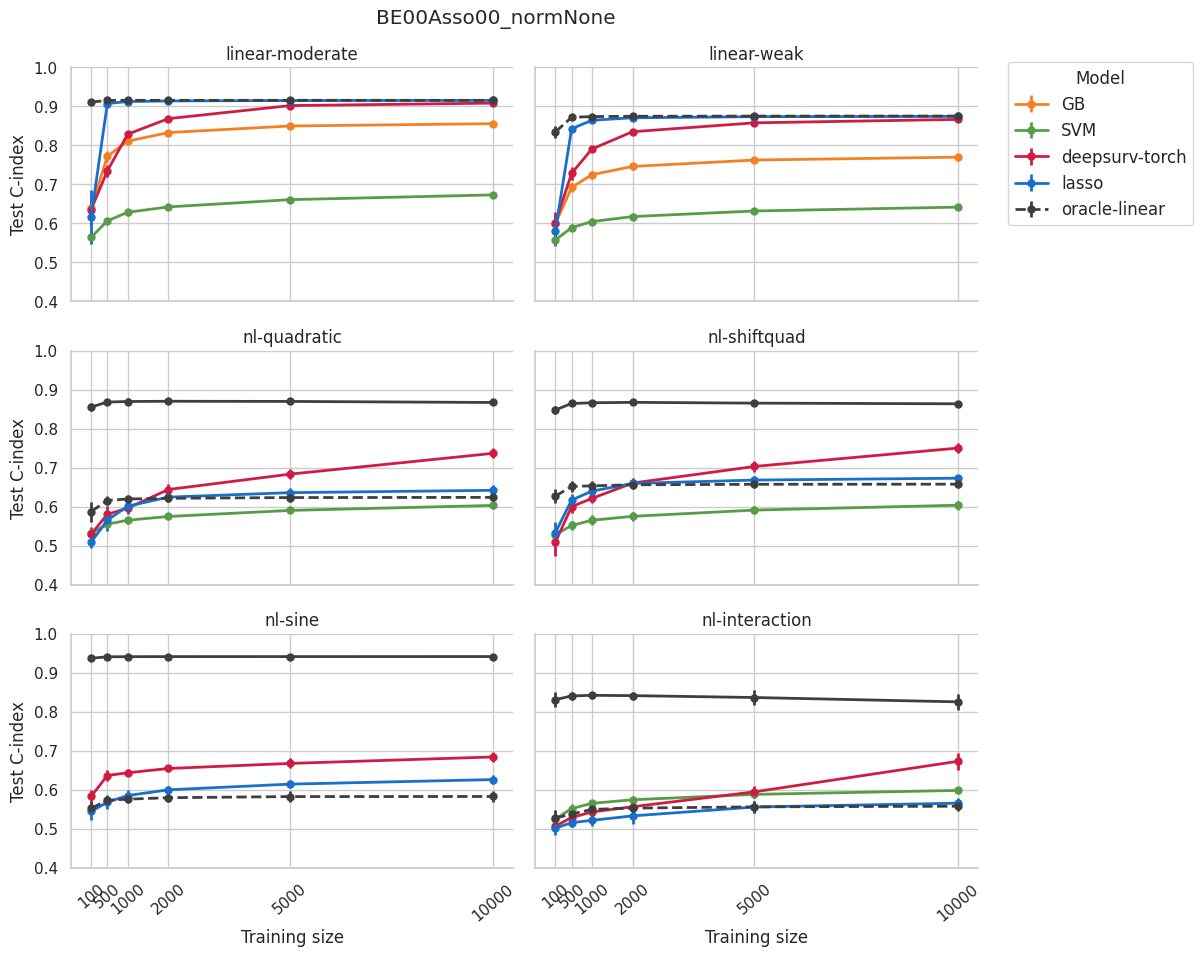

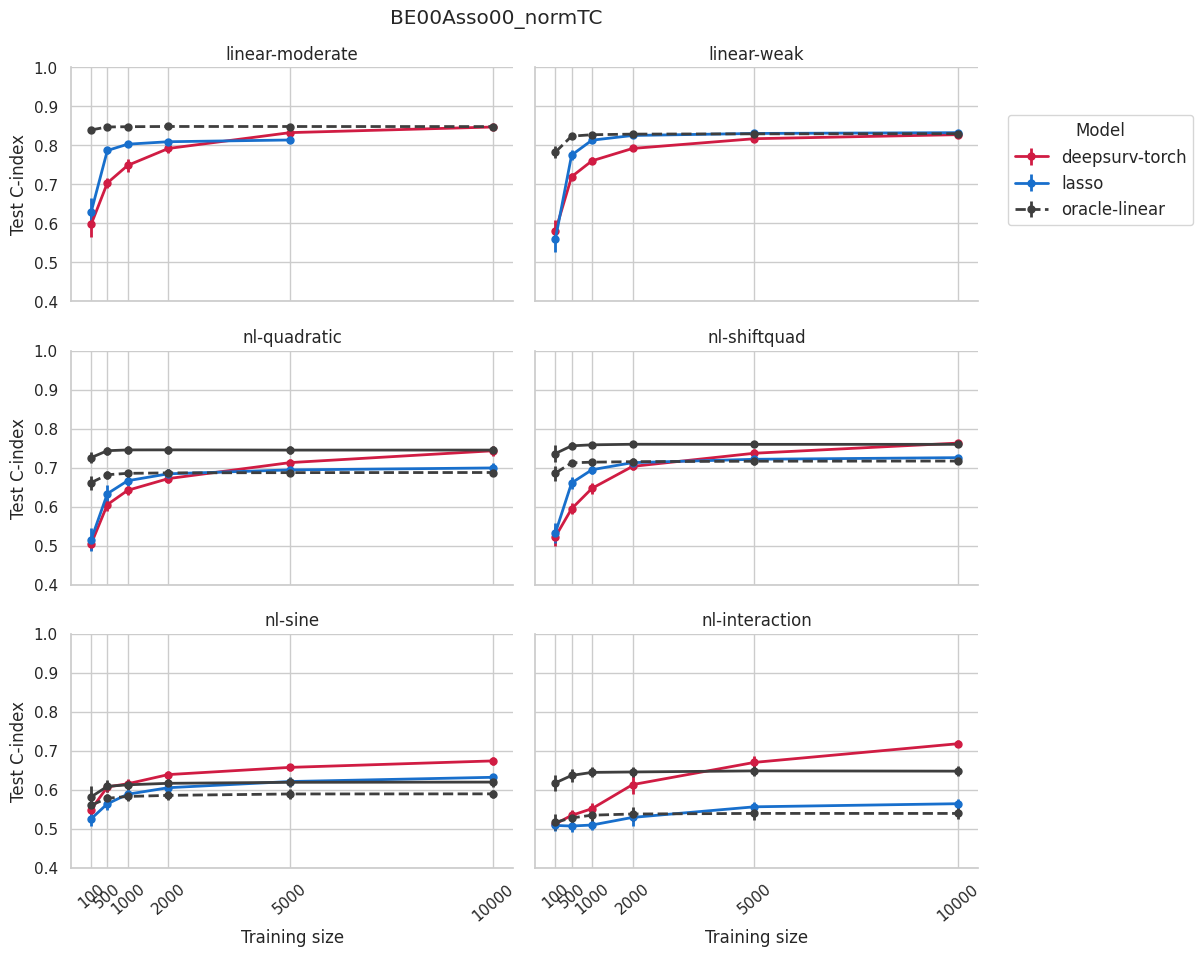

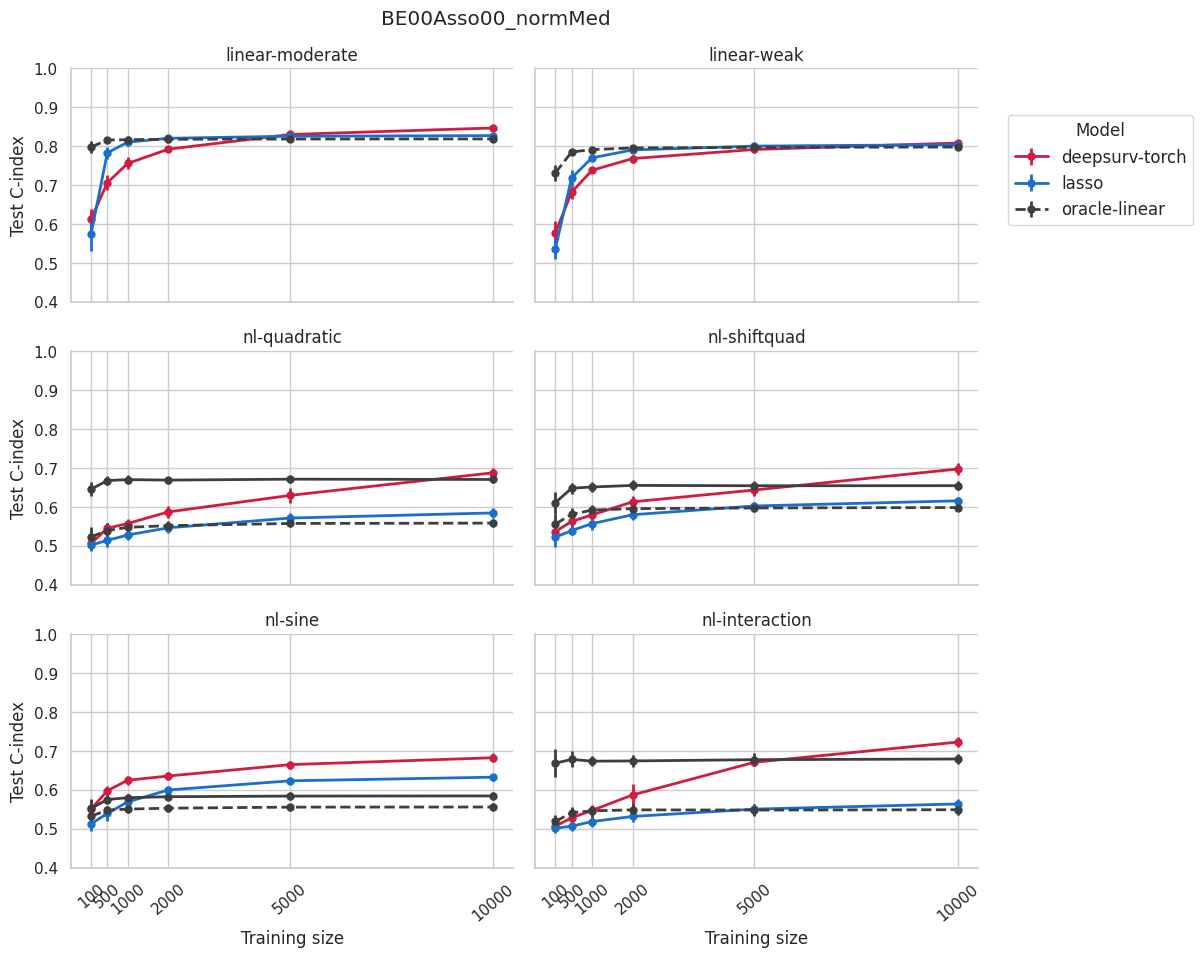

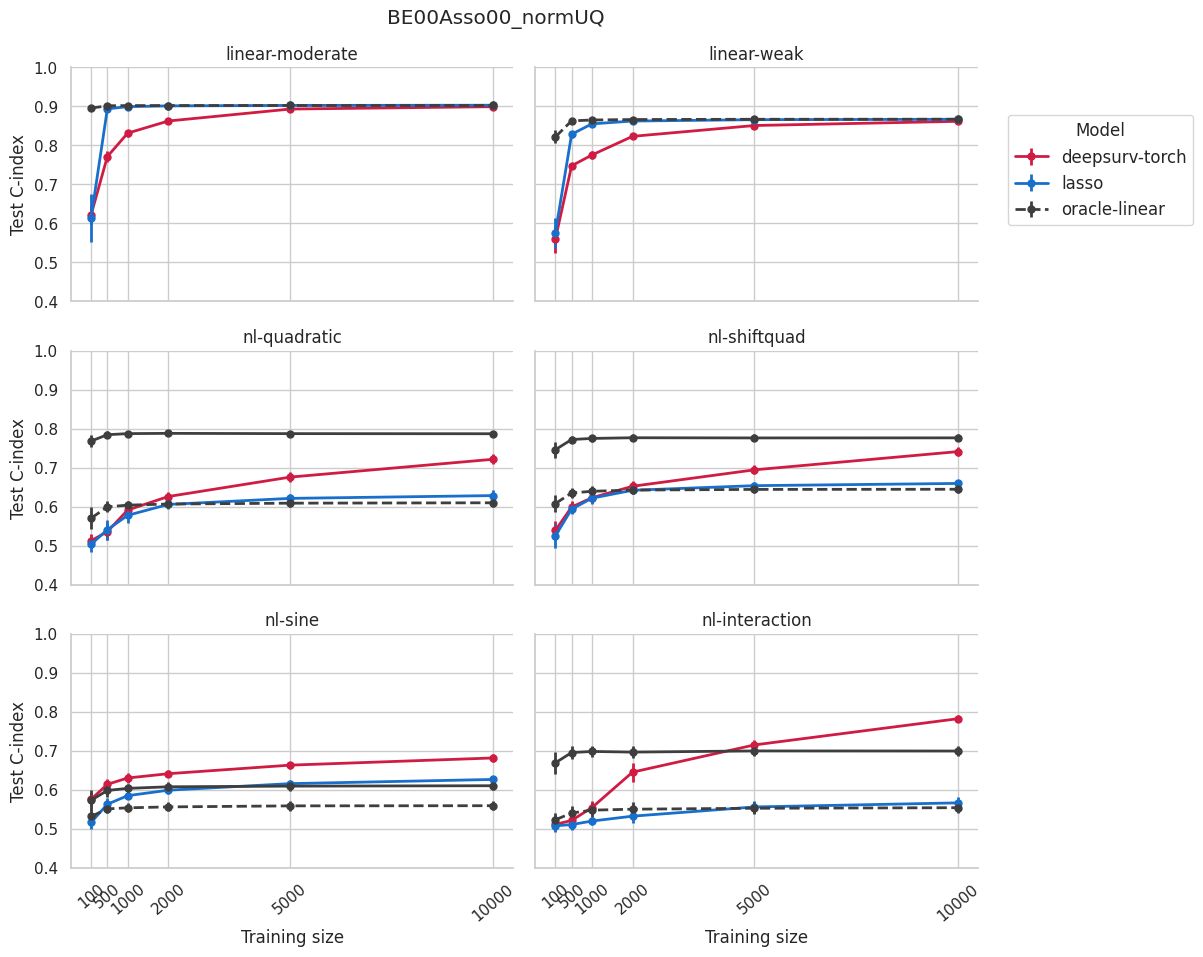

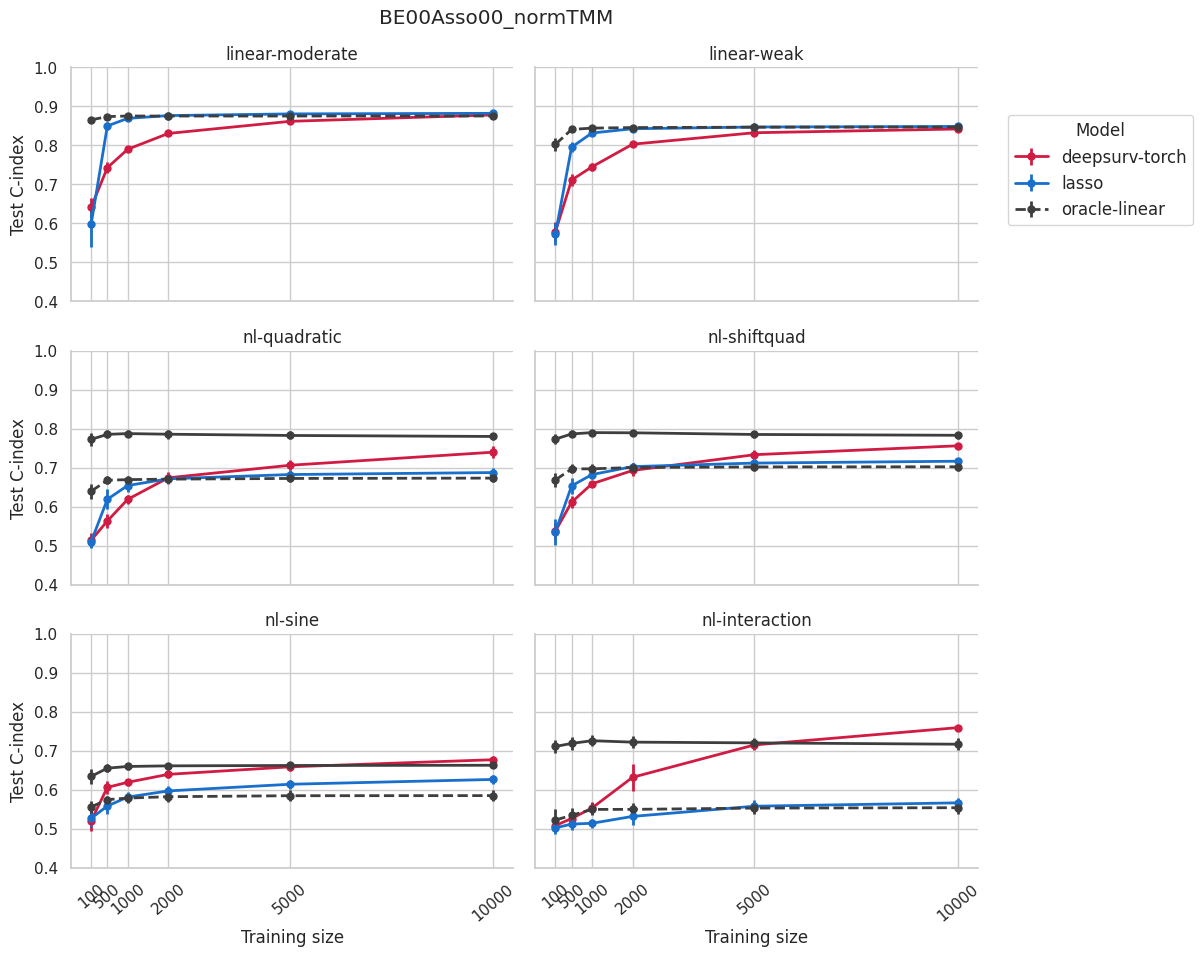

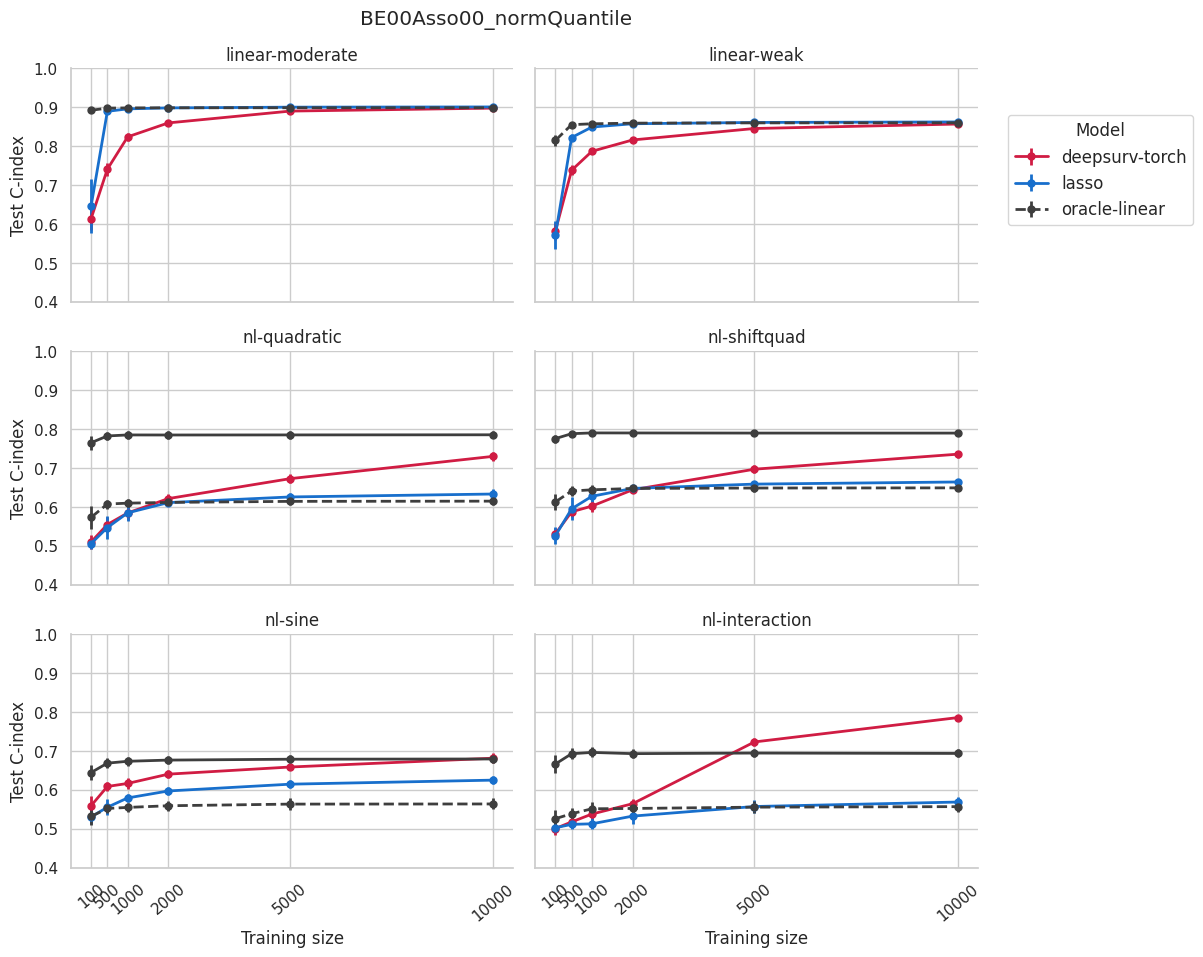

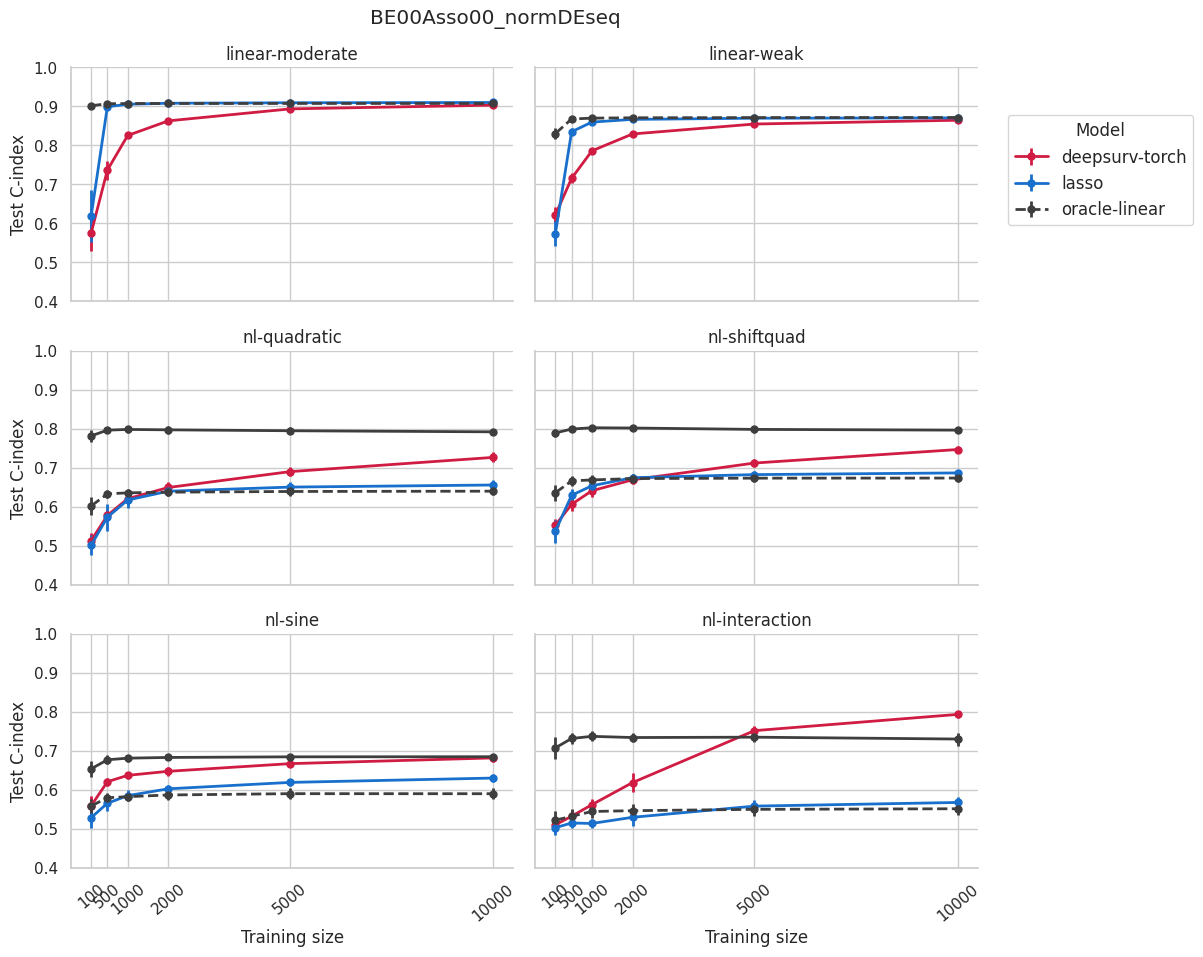

In [29]:
results_none = plot_precisionSeq_results(batchNormType='BE00Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normMed')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normDEseq')

### Jun19 2025

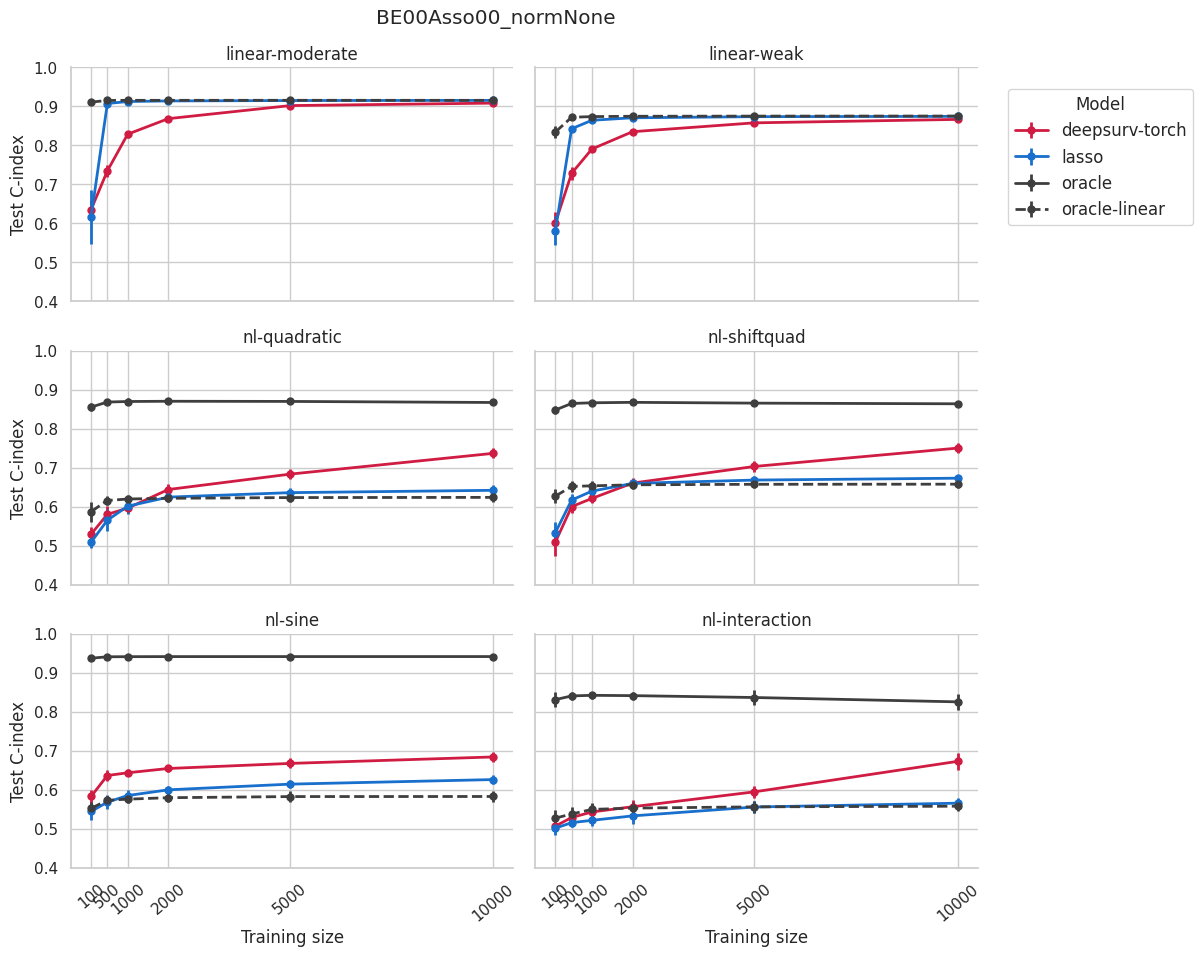

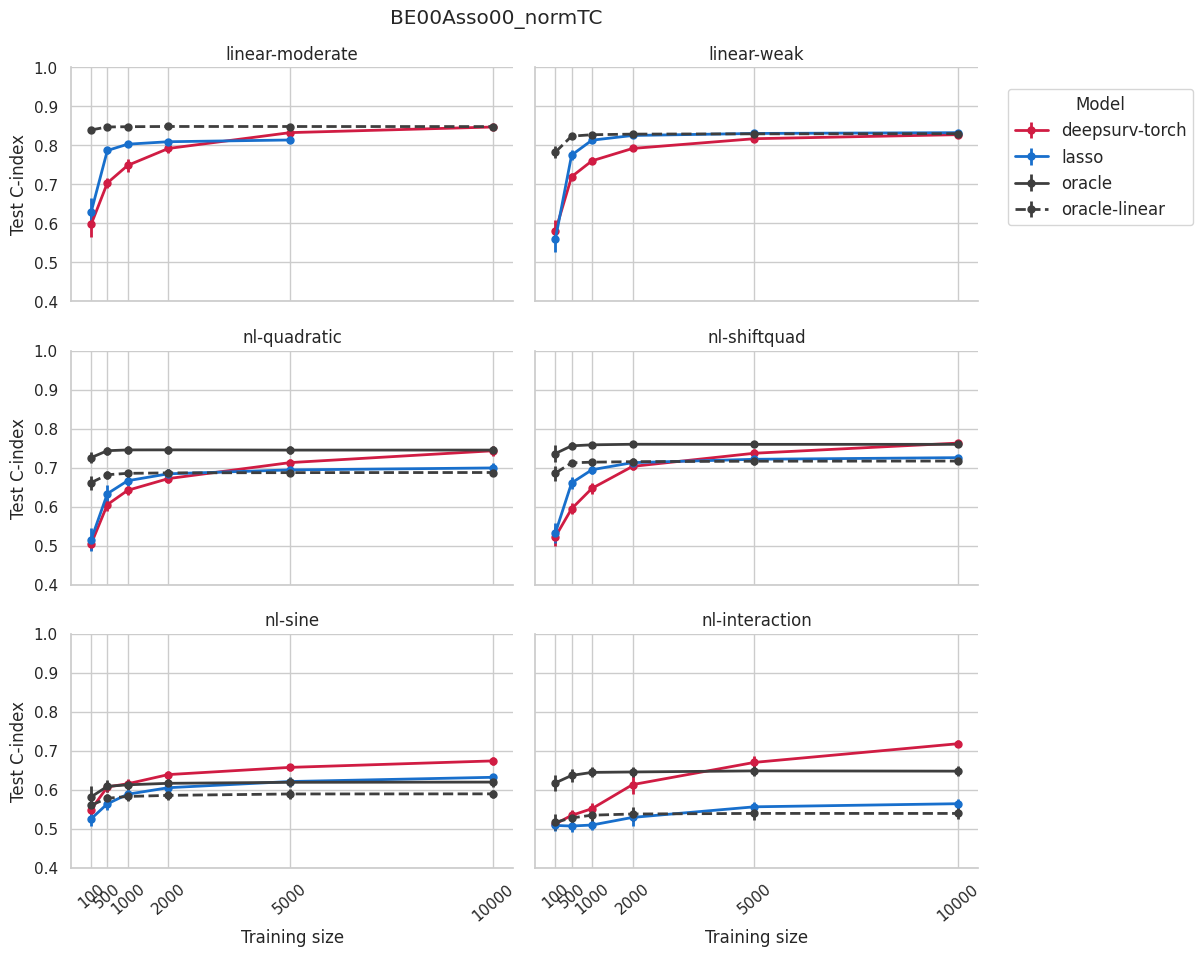

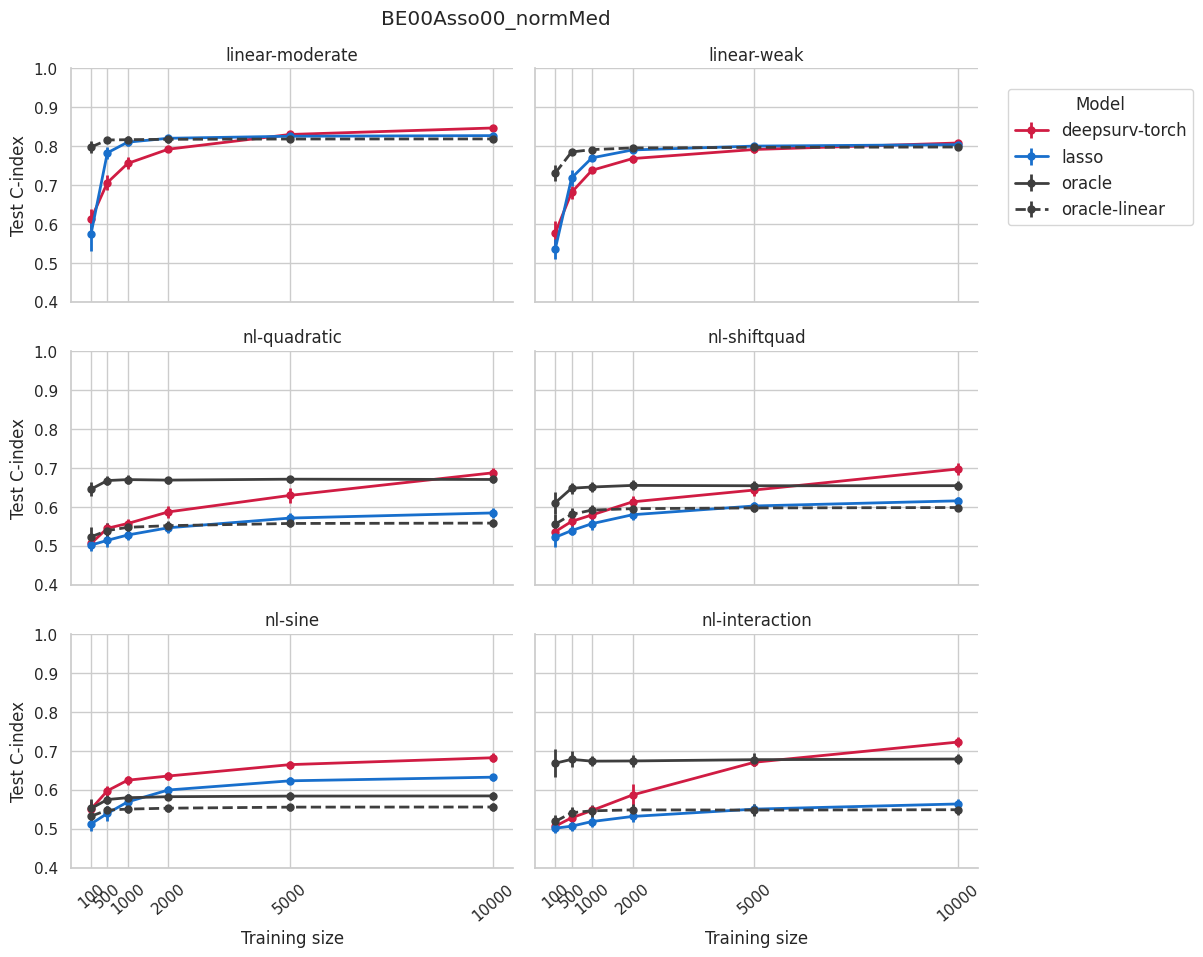

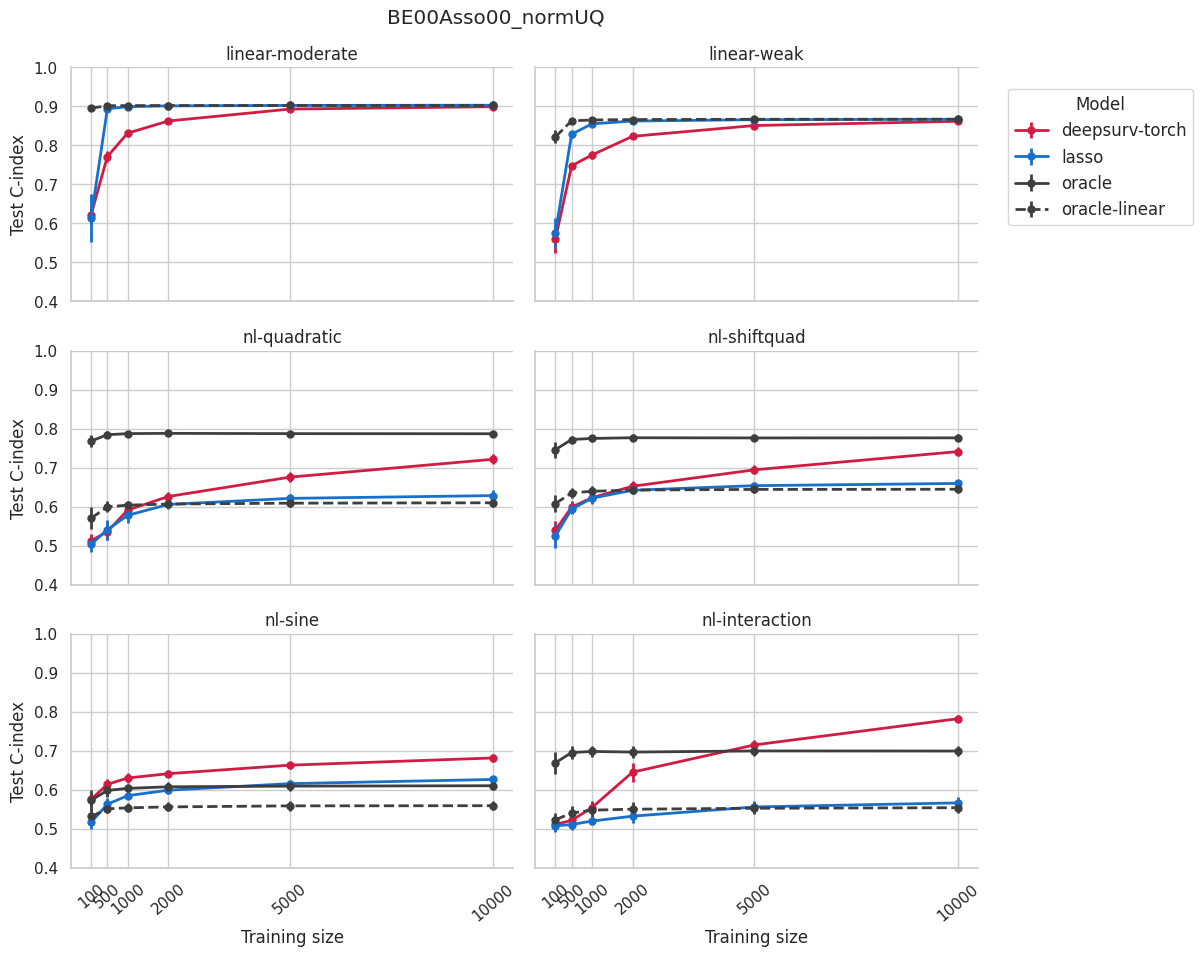

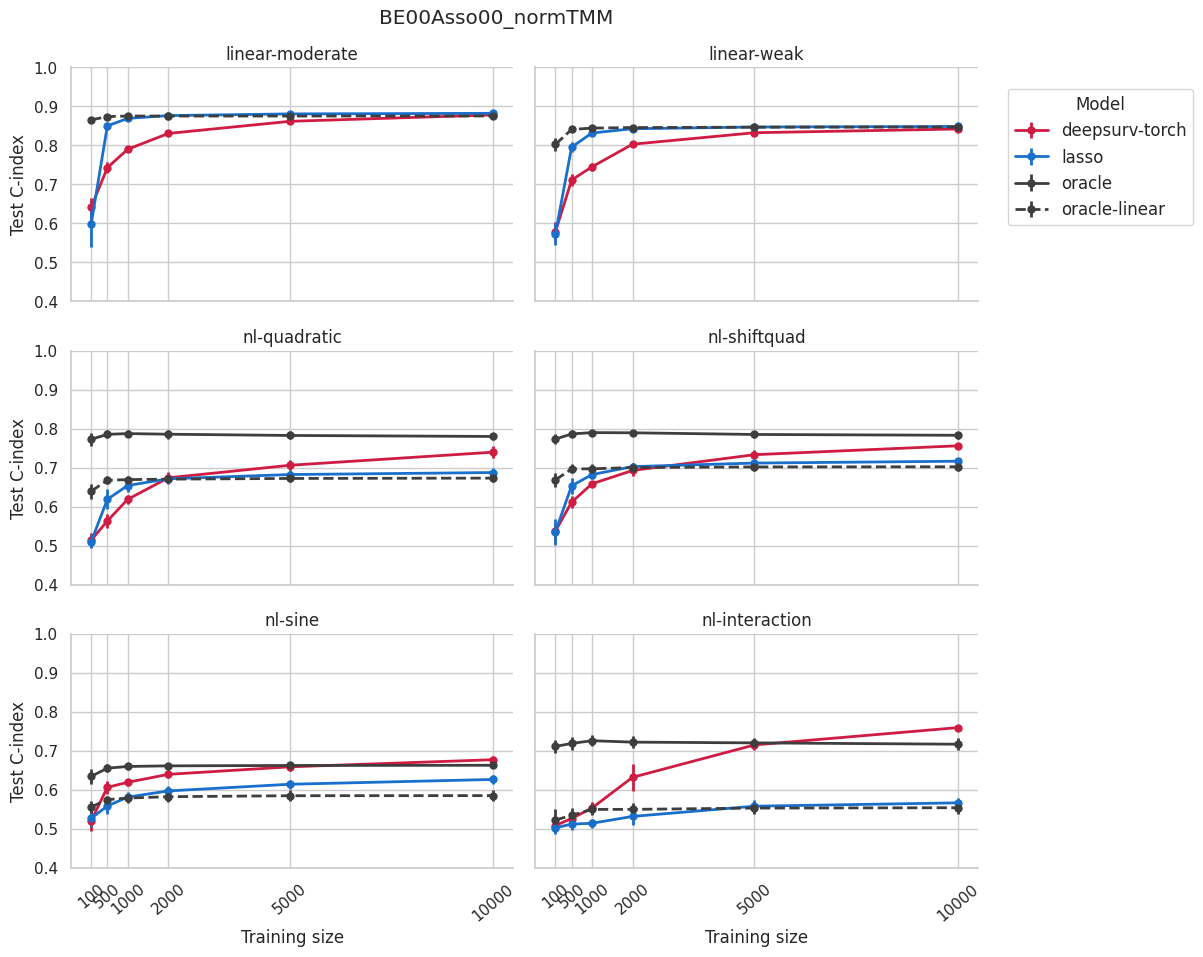

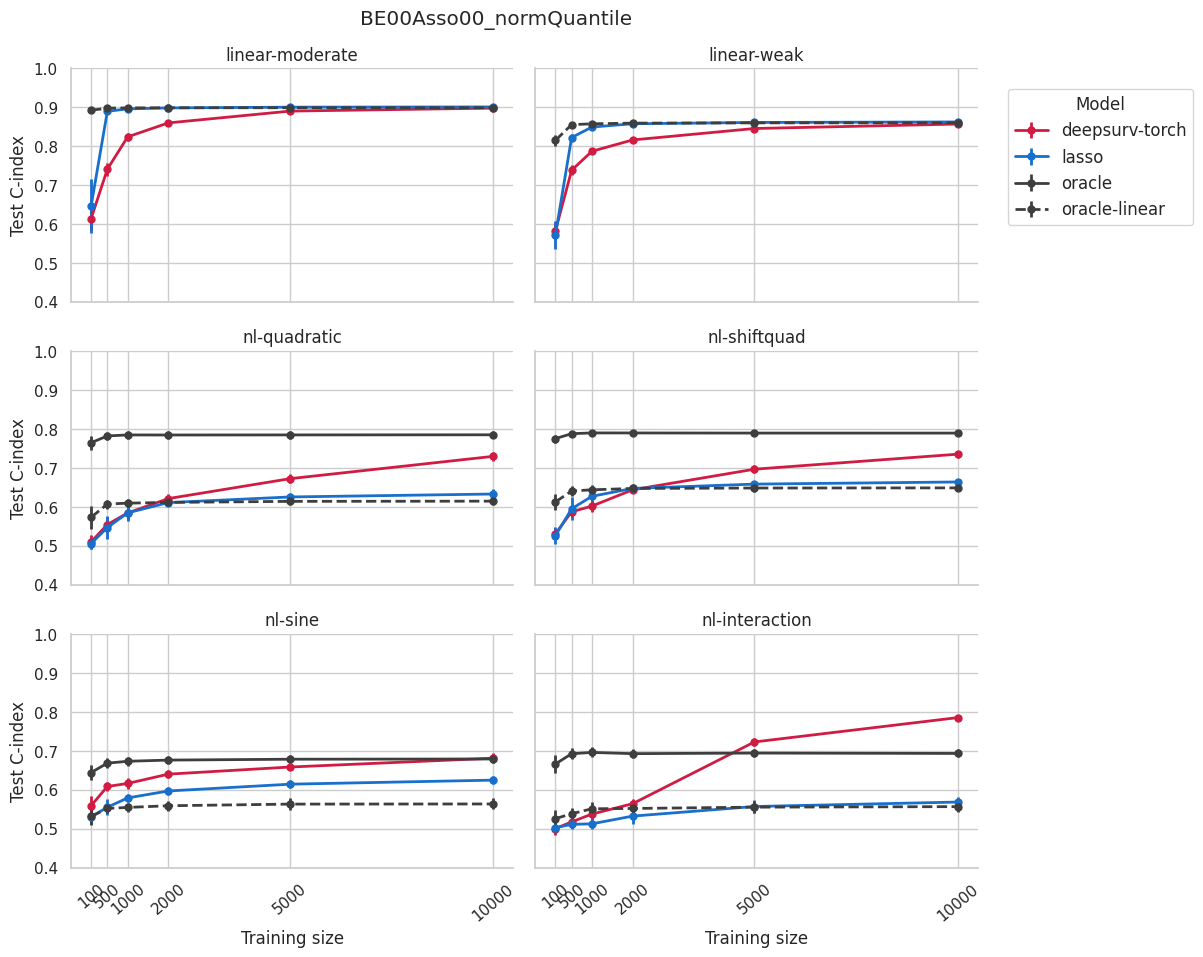

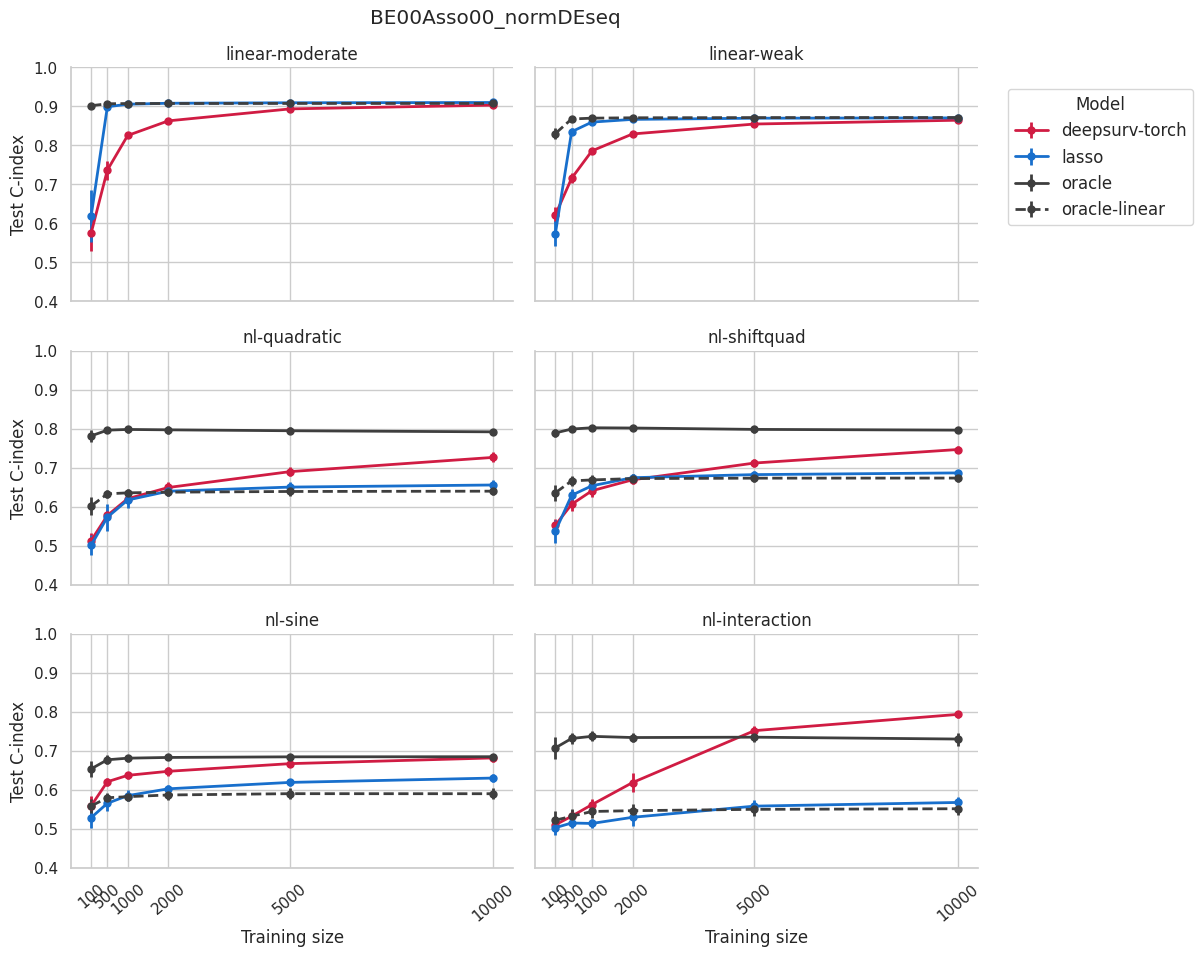

In [15]:
results_none = plot_precisionSeq_results(batchNormType='BE00Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normMed')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normDEseq')

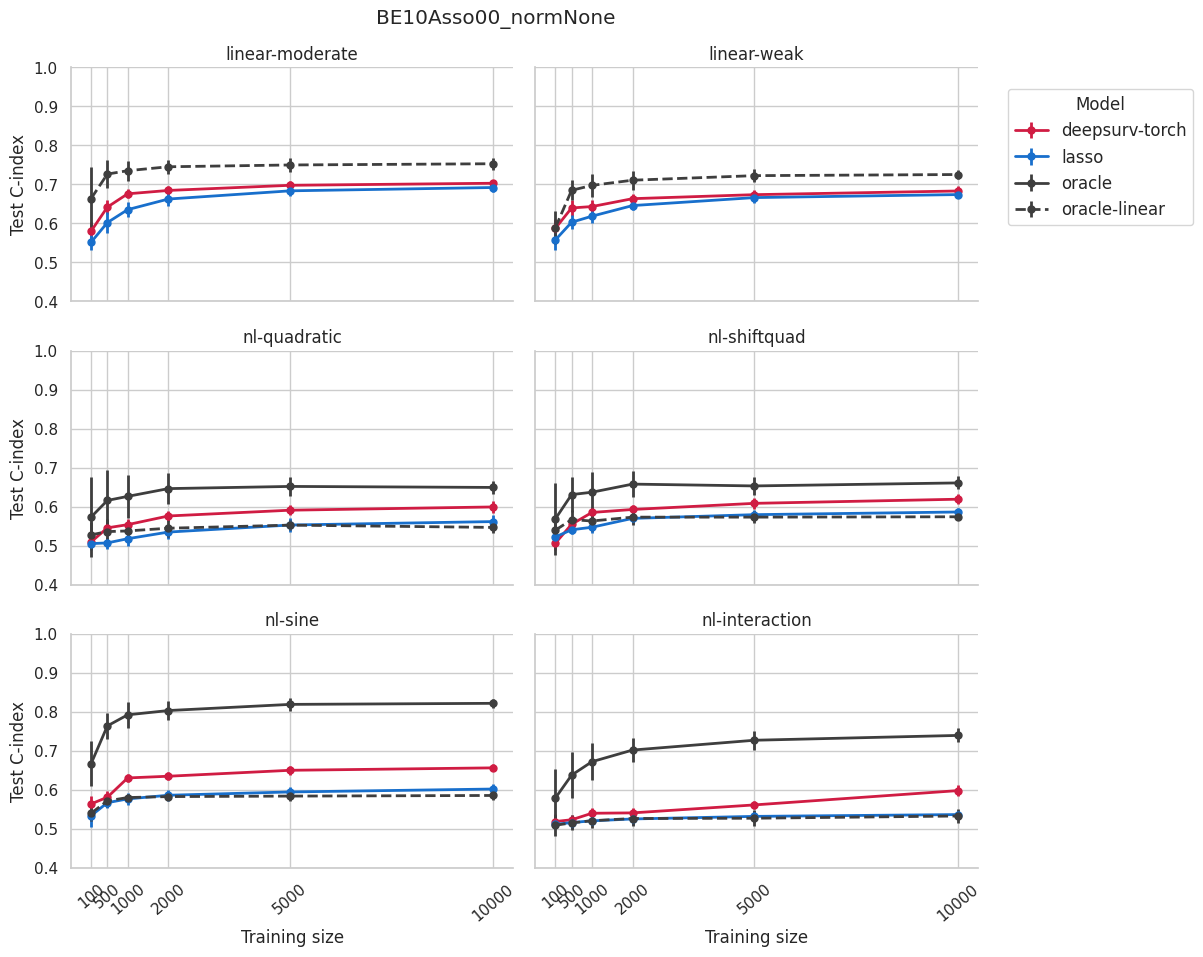

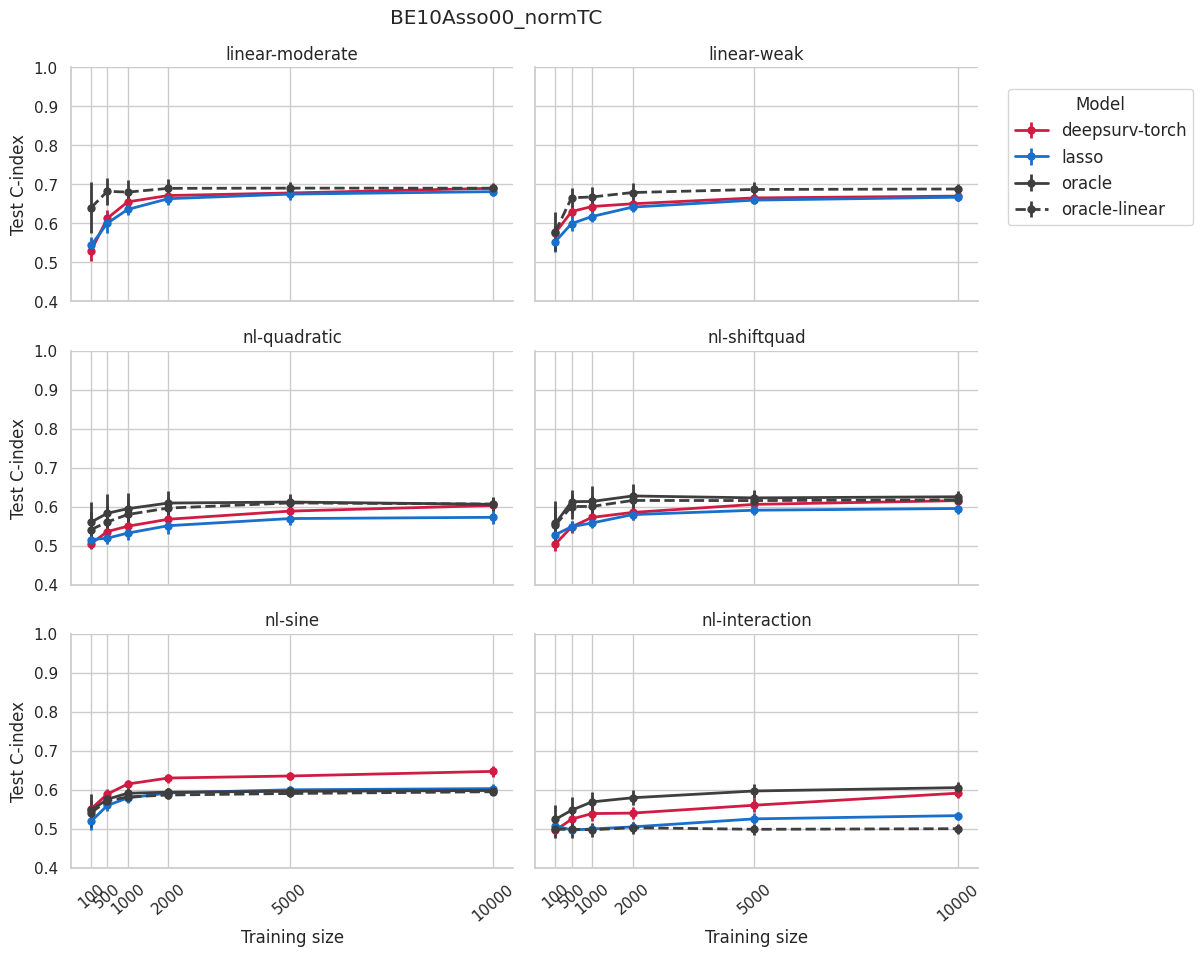

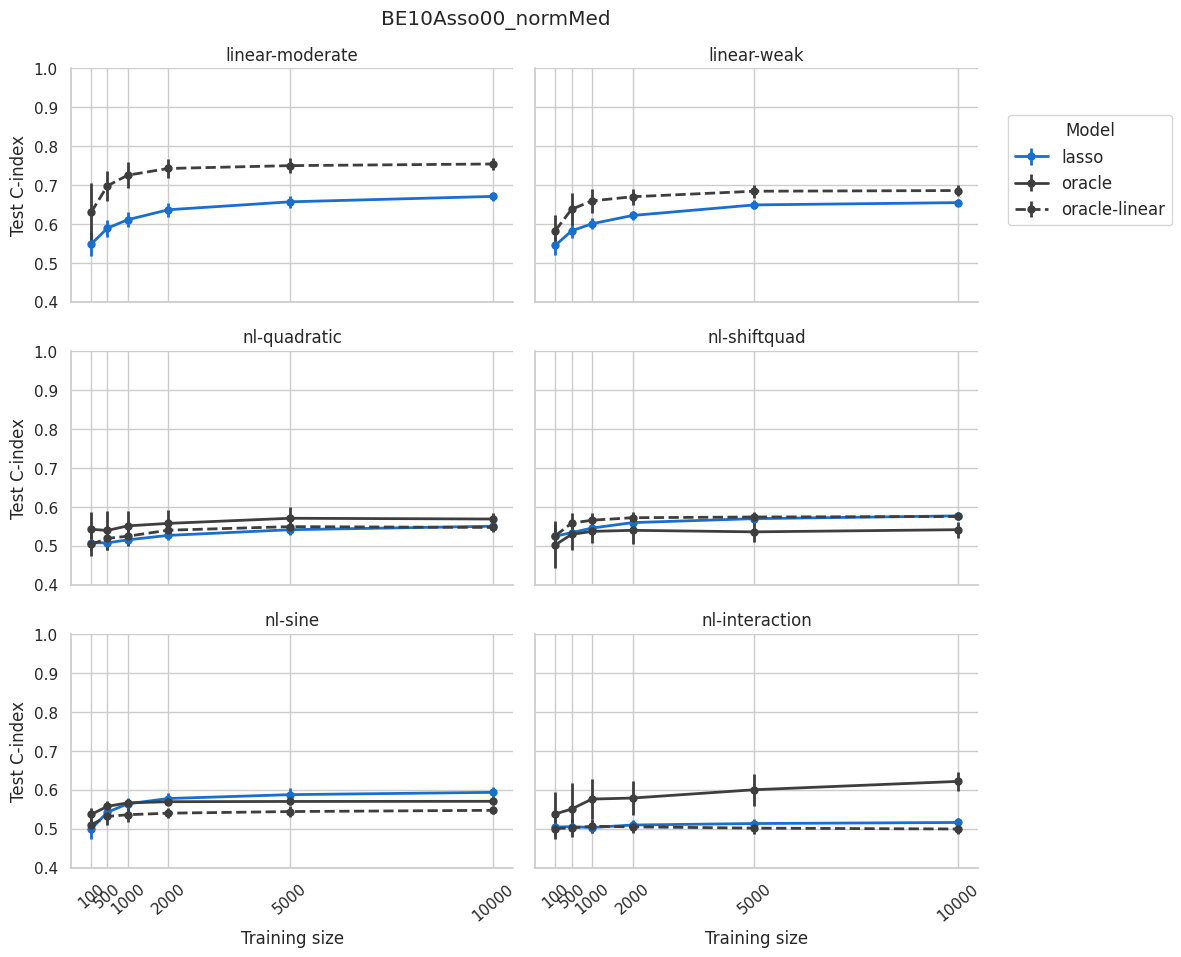

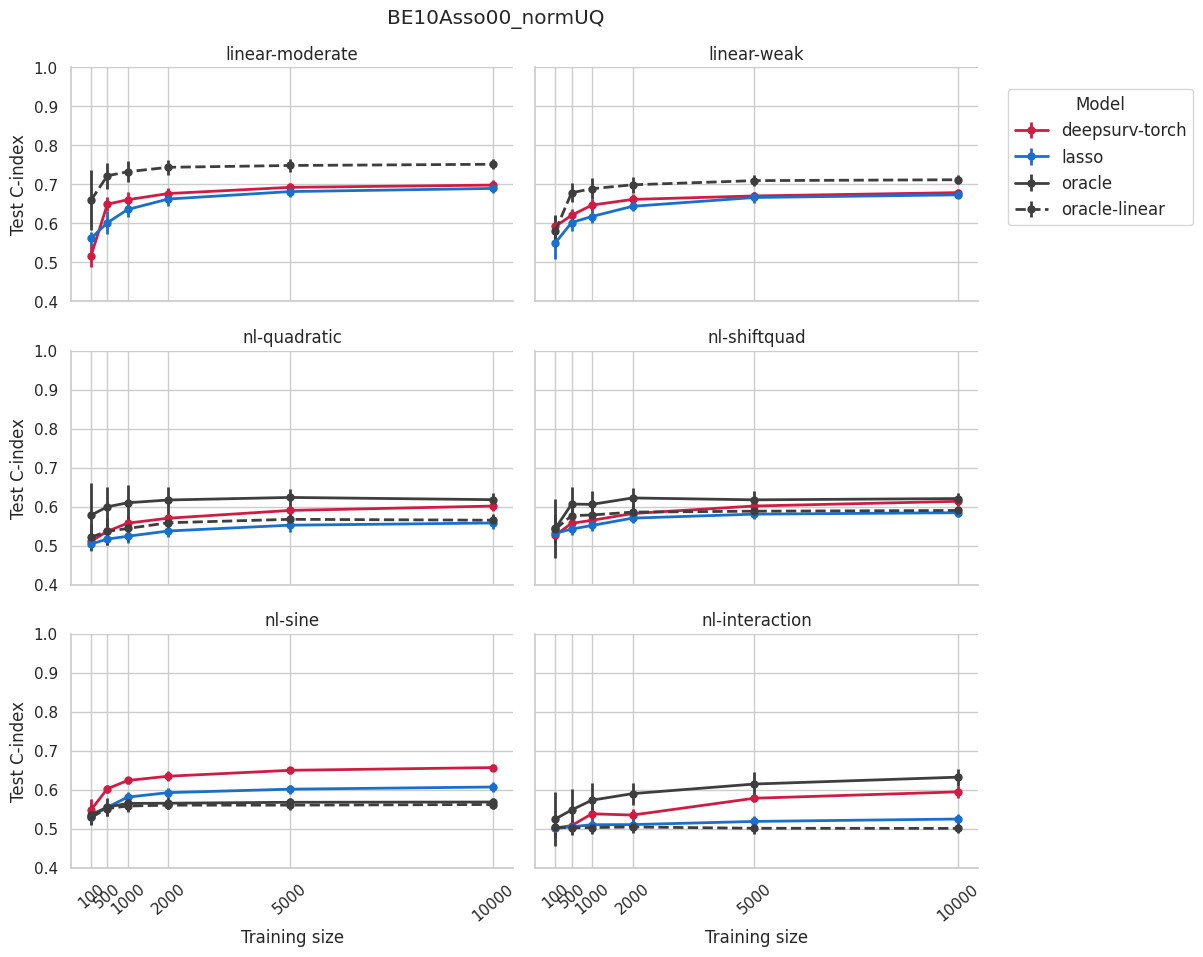

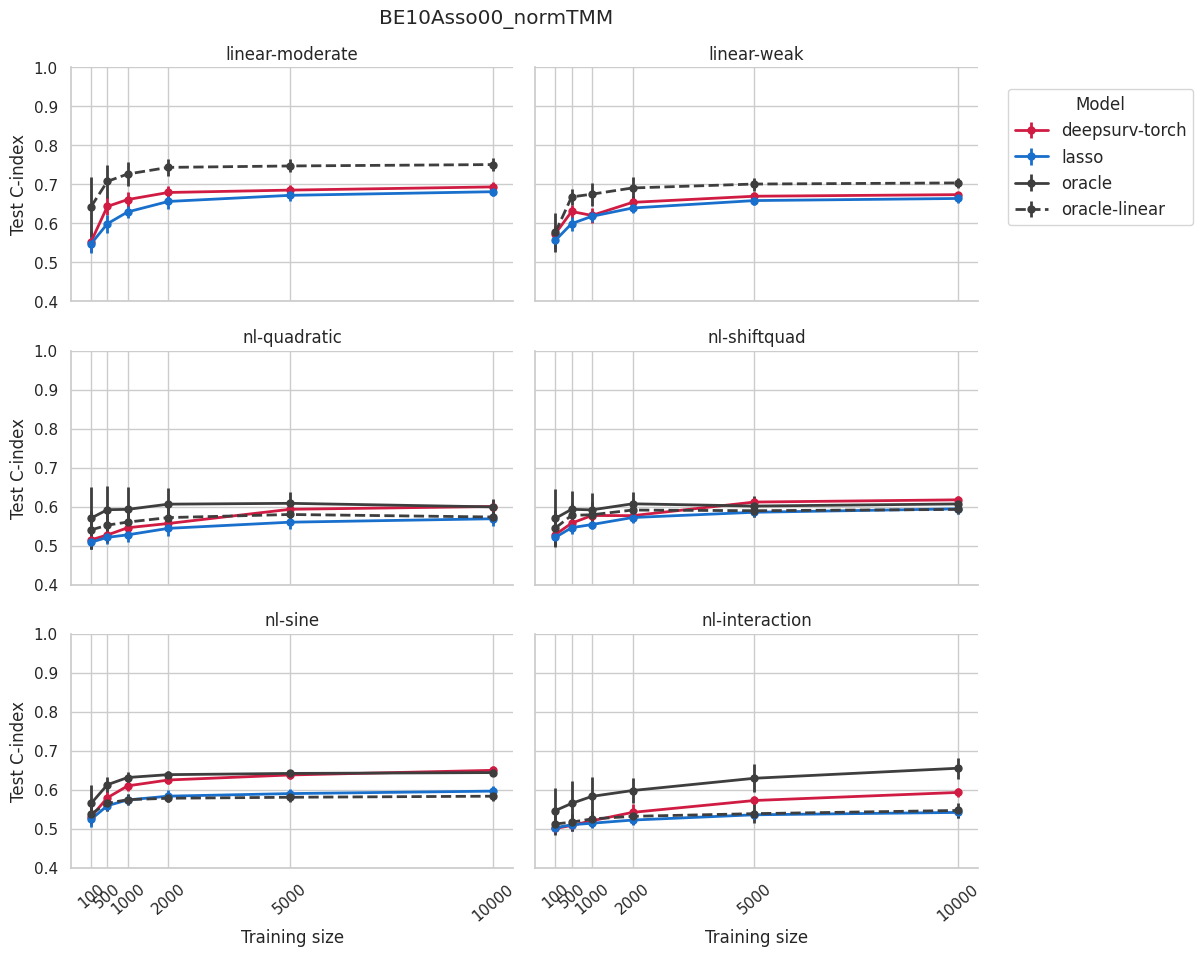

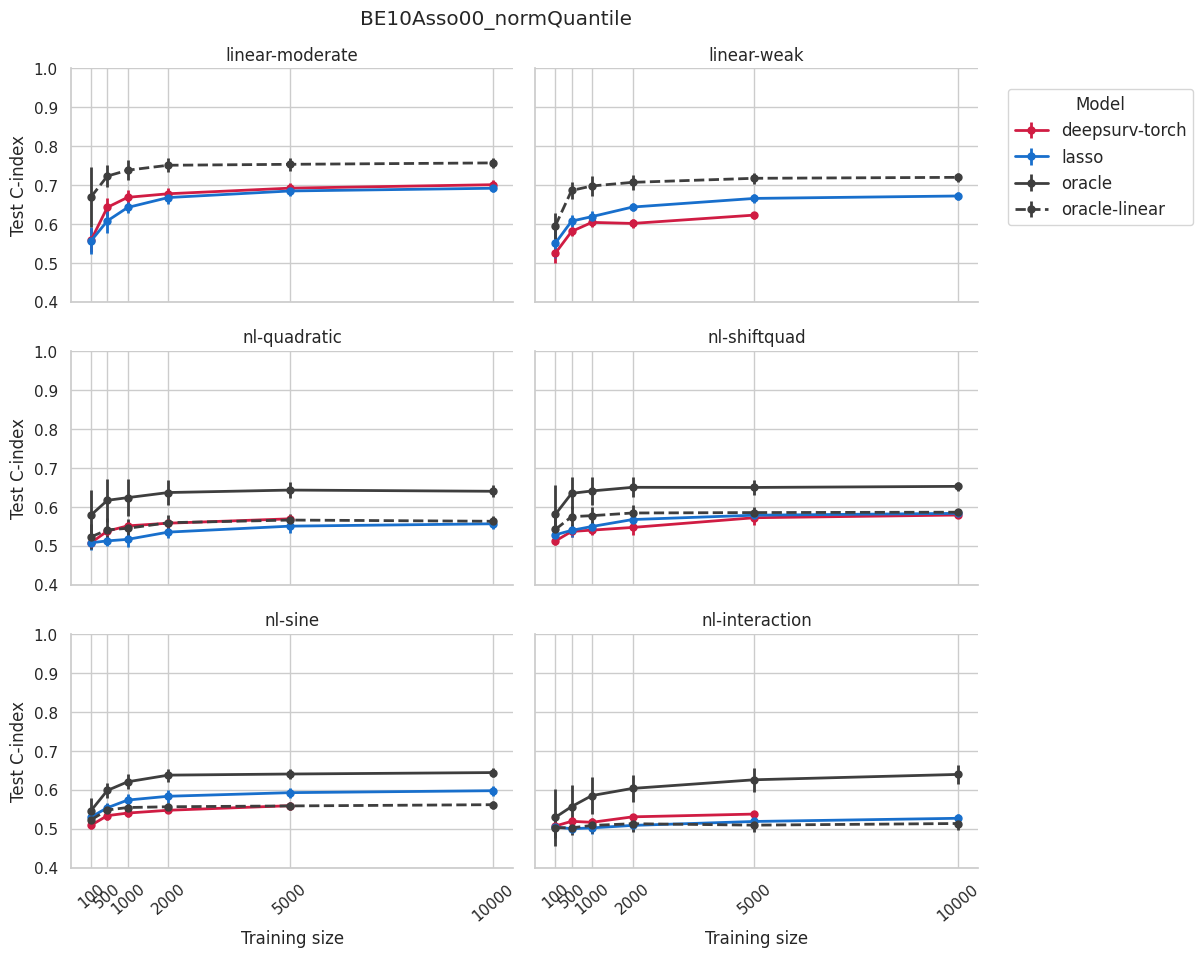

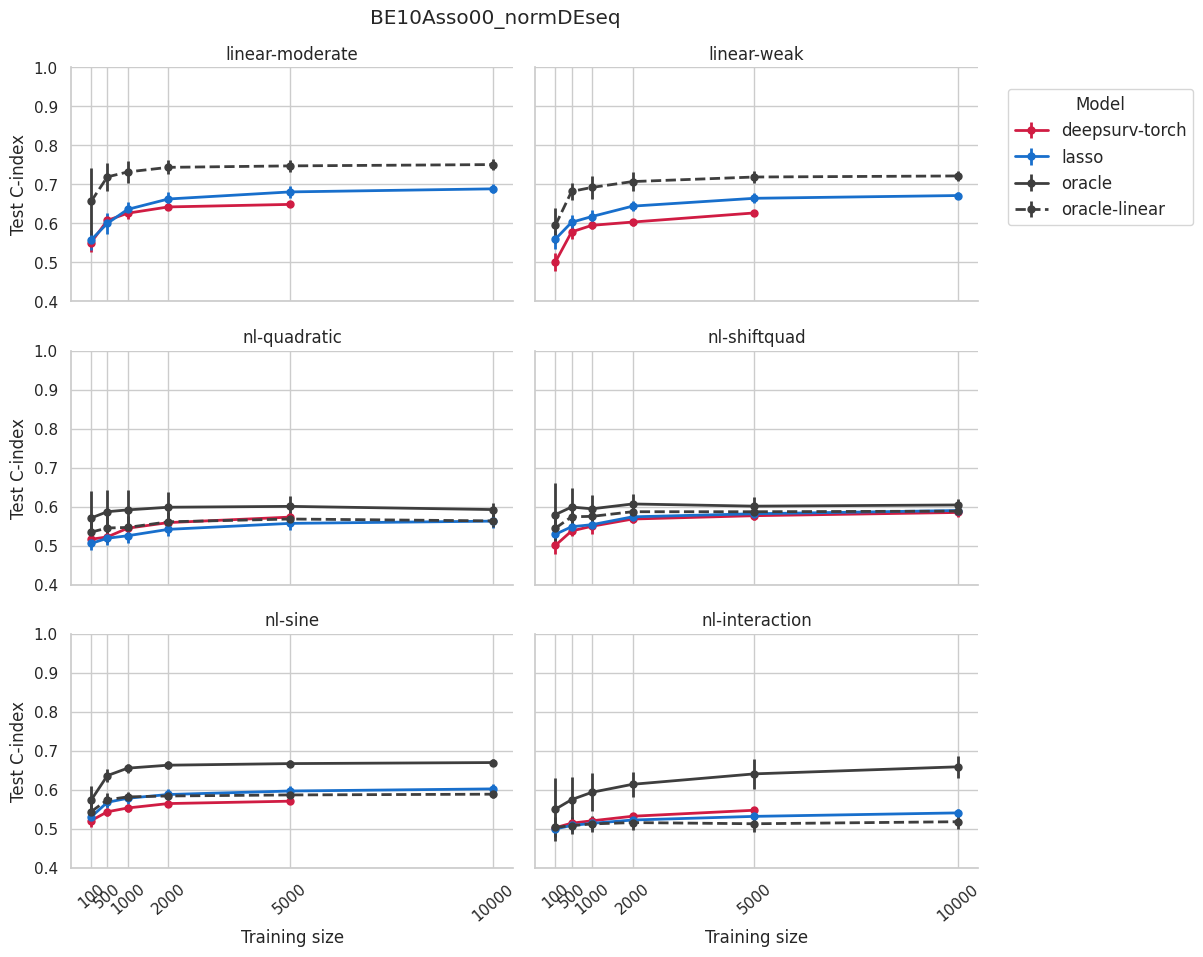

In [16]:
results_none = plot_precisionSeq_results(batchNormType='BE10Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normMed')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normDEseq')

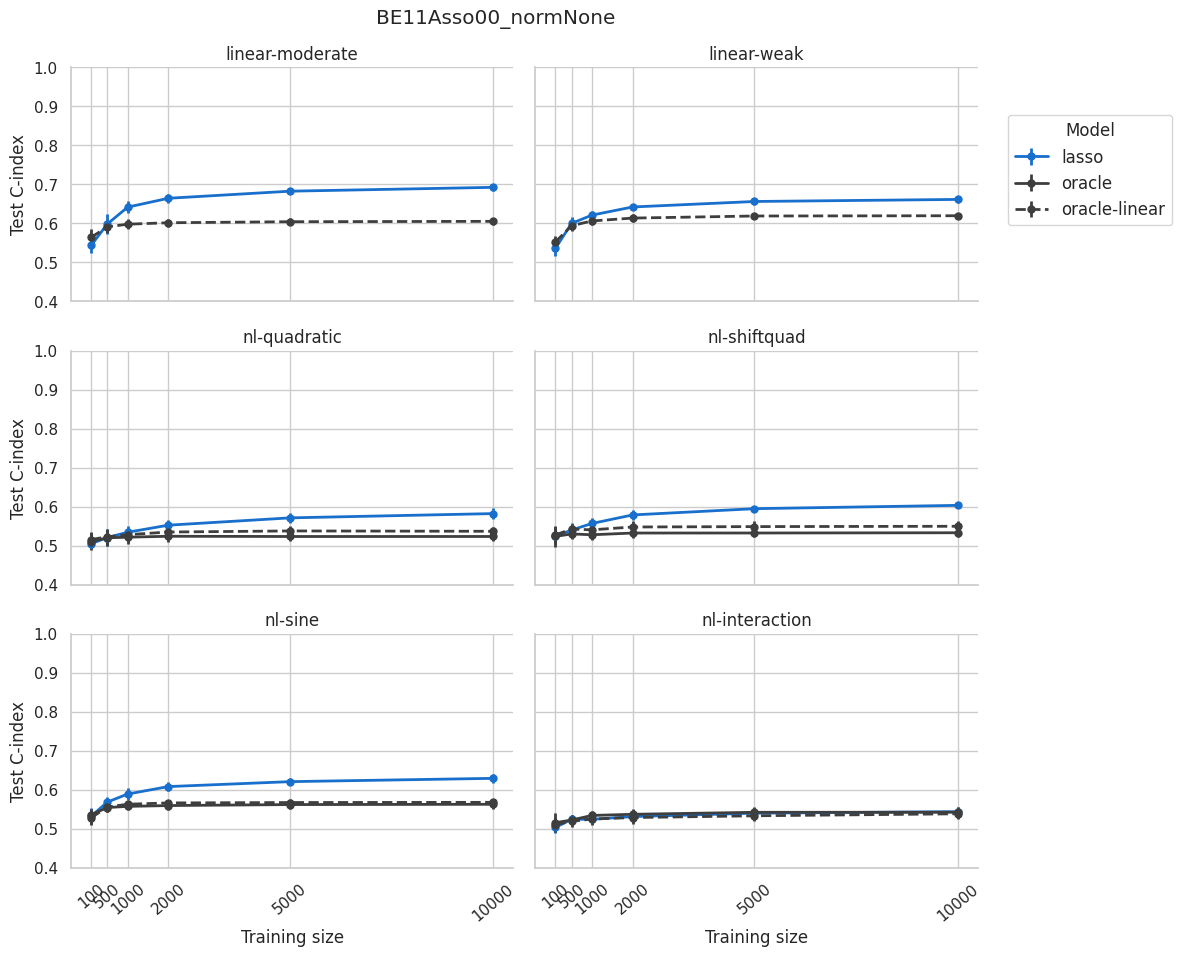

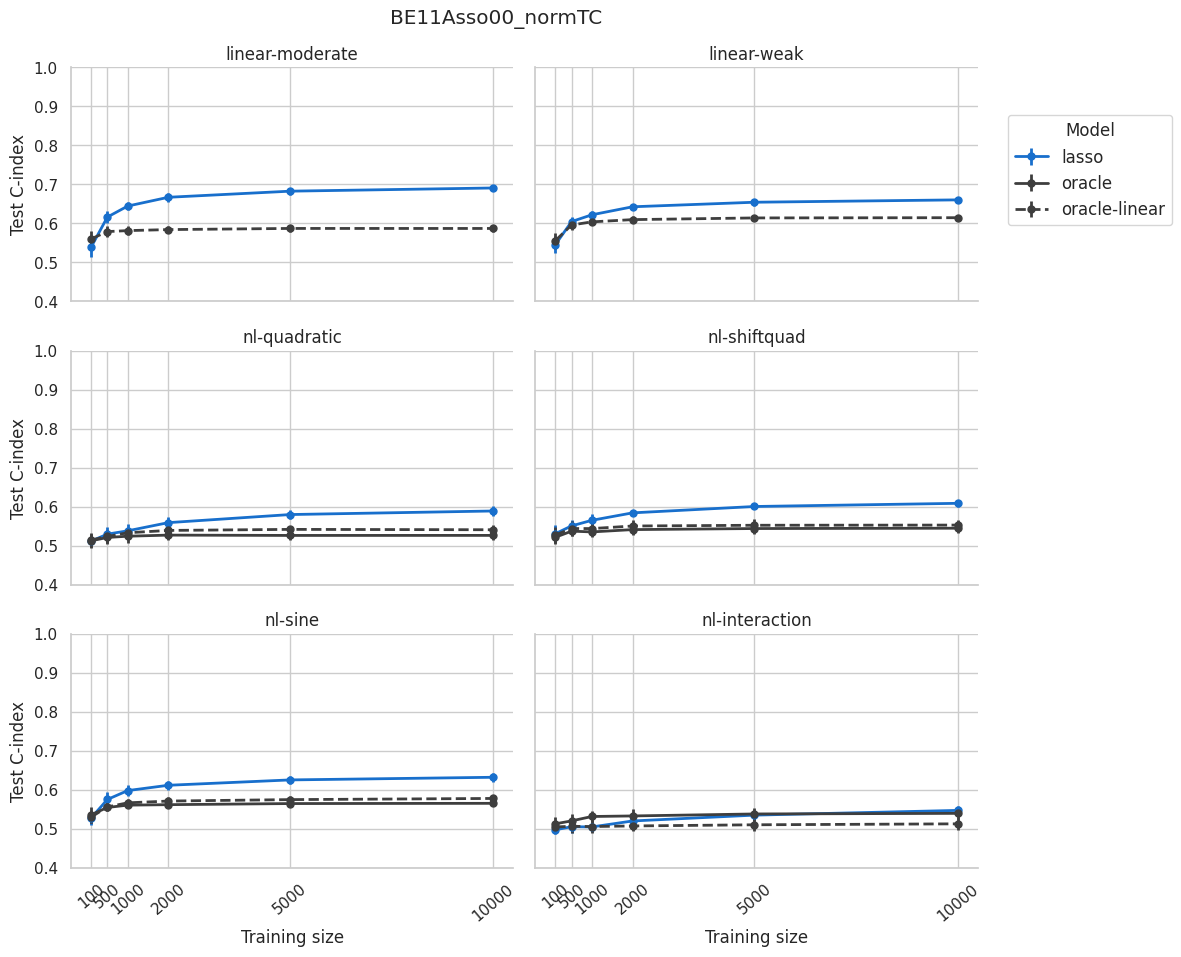

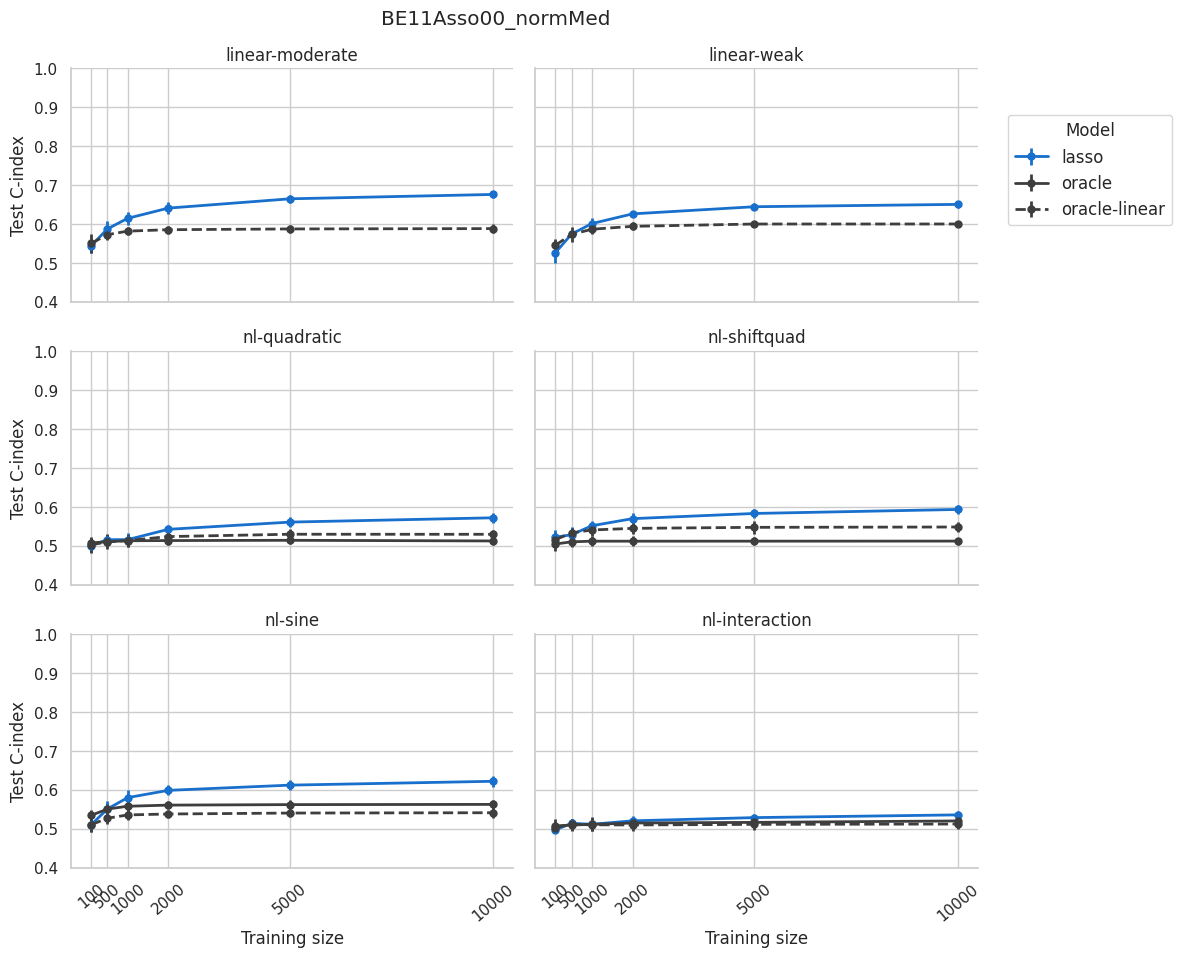

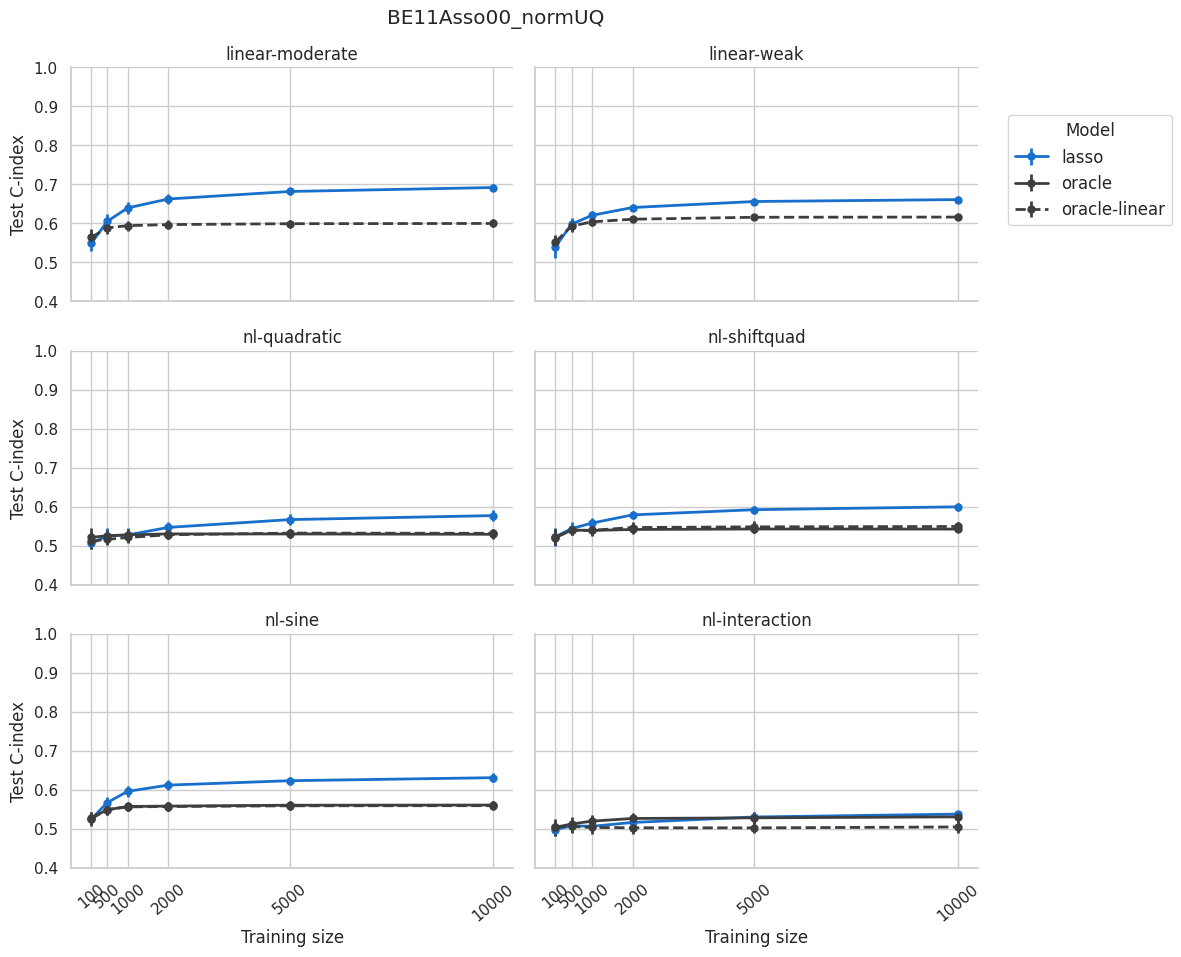

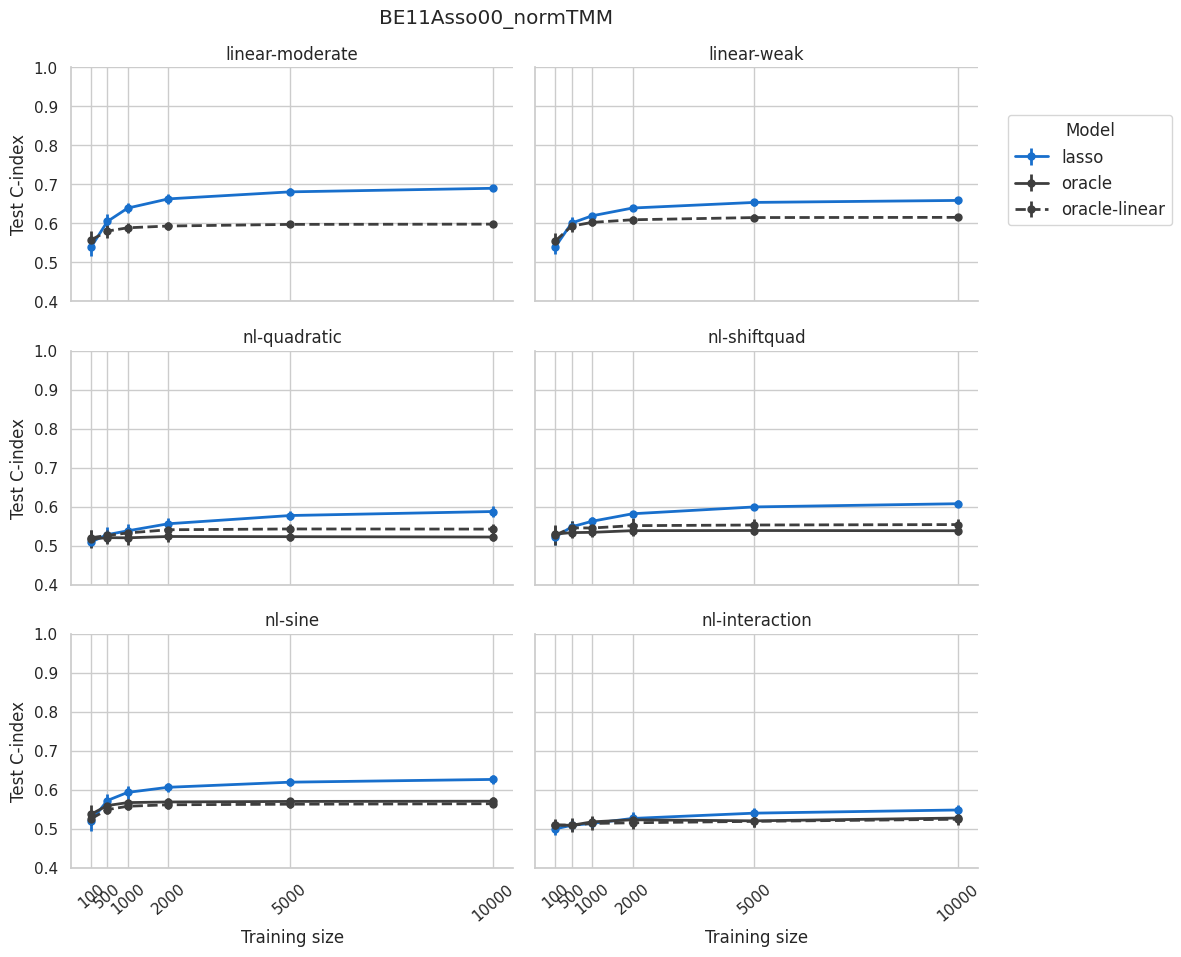

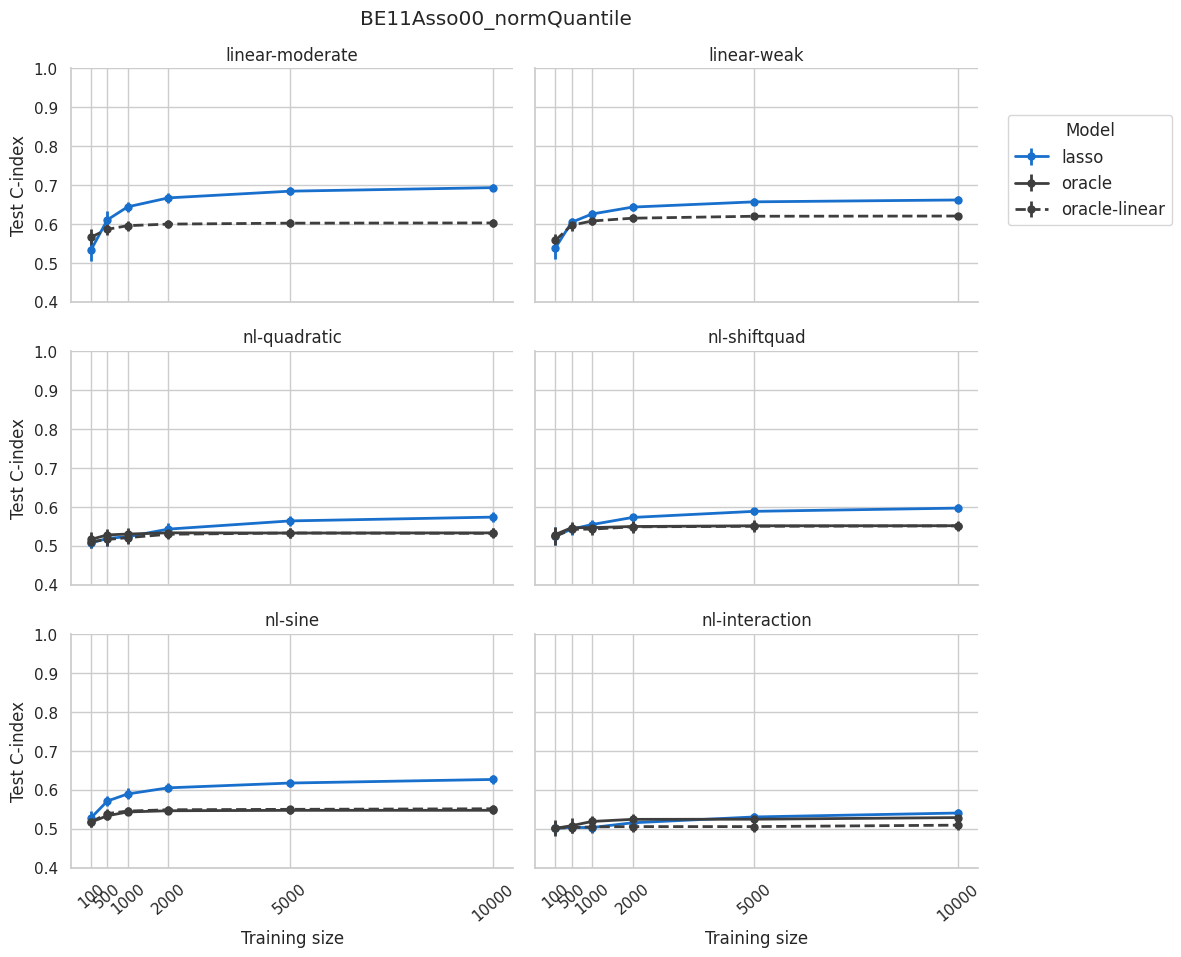

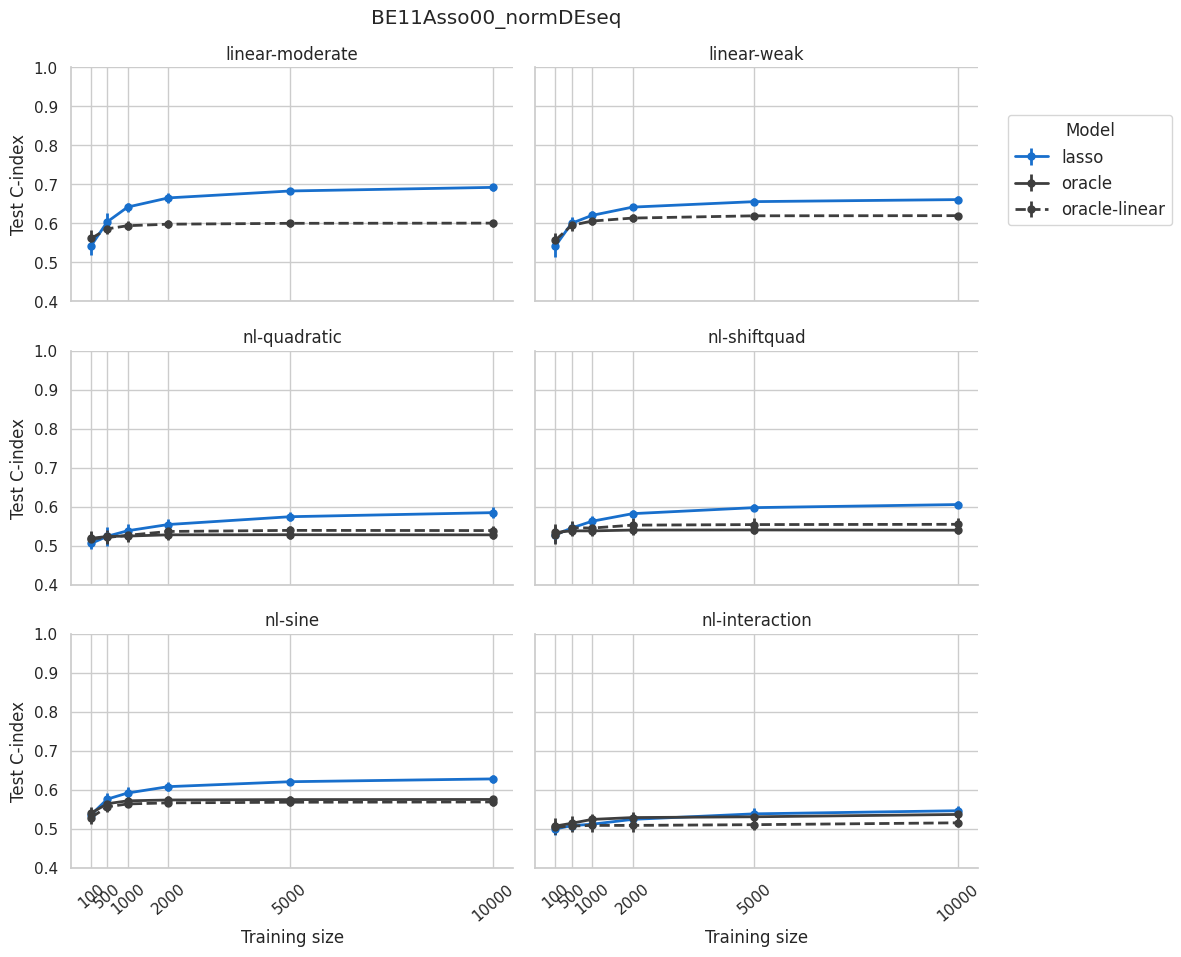

In [17]:
results_none = plot_precisionSeq_results(batchNormType='BE11Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normMed')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE11Asso00_normDEseq')

### Jun12 2025 Shift center quadratic

In [37]:
import seaborn as sns
import glob

def plot_precisionSeq_results(batchType, dataName, ylim=[0.45,0.85]):
    
    results = pd.DataFrame(columns=['n train', 
                                    'train time',
                                    'train C',
                                    'test C',
                                    'train brier',
                                    'test brier',
                                    'model type',
                                    'data type'])
    modelTypes = ['deepsurv-torch', 'lasso', 'oracle-linear', 'oracle-nl']
    benormTypes = [batchType + '_' + str for str in  ['normNone','normTC','normUQ','normTMM','normQuantile','normDEseq']]
    
    # dataNames = ['linear-moderate', 'linear-weak','nl-quadratic', 'nl-shiftquad', 'nl-interaction','nl-sine']
    
    for benorm in benormTypes:
        for model in modelTypes:
            try:
                file_dir = glob.glob(
                    os.path.join('models', benorm, dataName, model, f"model_results_*.csv")
                    )[-1]
                result_df = pd.read_csv(file_dir)
            except: 
                continue
            if model != 'deepsurv-torch':
                result_df.columns = ["n train","train C","test C"]
            
            result_df['model type'] = model
            result_df['data type'] = benorm
            results = pd.concat([results, result_df], axis=0)
            
    results['n train'] = results['n train'].astype(int)
    
    sns.set(style="whitegrid", font_scale=1)
    colors = {
        'deepsurv-torch': "#d01c43",   # Soft red
        'lasso': "#186fcc",            # Muted blue
        'oracle-linear': "#3E3E3E",    # Medium gray
        'oracle-nl':  "#664848"        # Brown
    }
    g = sns.FacetGrid(results, 
                    col="data type", 
                    col_wrap=3, 
                    # palette='Set2',
                    height=4, 
                    aspect=1.4, 
                    sharey=True, 
                    sharex=True
                    )
    # Add mean lines on top of boxplot
    for ax, benorm in zip(g.axes.flat, results['data type'].unique()):
        # means = subset.groupby(['n train', 'model type'])['test C'].mean().reset_index()
        subset = (
            results[results['data type'] == benorm]
            .groupby(['data type', 'n train', 'model type'])
            .agg(mean=('test C', 'mean'),
                sd=('test C', 'std'))
            .reset_index()
        ) 
        # print(subset)
        for model in subset['model type'].unique():
            sub = subset[subset['model type'] == model]
            ax.errorbar(
                sub['n train'], sub['mean'], yerr=sub['sd'], color=colors[model],
                label=model, marker='o', linestyle='--', linewidth=3, markersize=7
            )
            ax.set_ylim(ylim)
            ax.set_title(benorm)
            ax.set_xlabel("Training size")
            ax.set_ylabel("Test C-index")
            ax.set_xticks([100,500,1000,2000,5000,10000])
            ax.set_xticklabels(['100','500','1000','2000','5000','10000'])
            ax.tick_params(axis='x', rotation=40)
            # ax.legend()
            
    g.fig.suptitle(f'{dataName} ({batchType})')
    g.set_titles("{col_name}")
    g.set_axis_labels("Training size", "Test C-index")
    
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(
        handles, labels, 
        loc='lower left', 
        bbox_to_anchor=(1, 0.1),
        ncol=1, frameon=True, fontsize=12, 
        title="Model"
    )
    plt.tight_layout()
    plt.show()
    
    return results

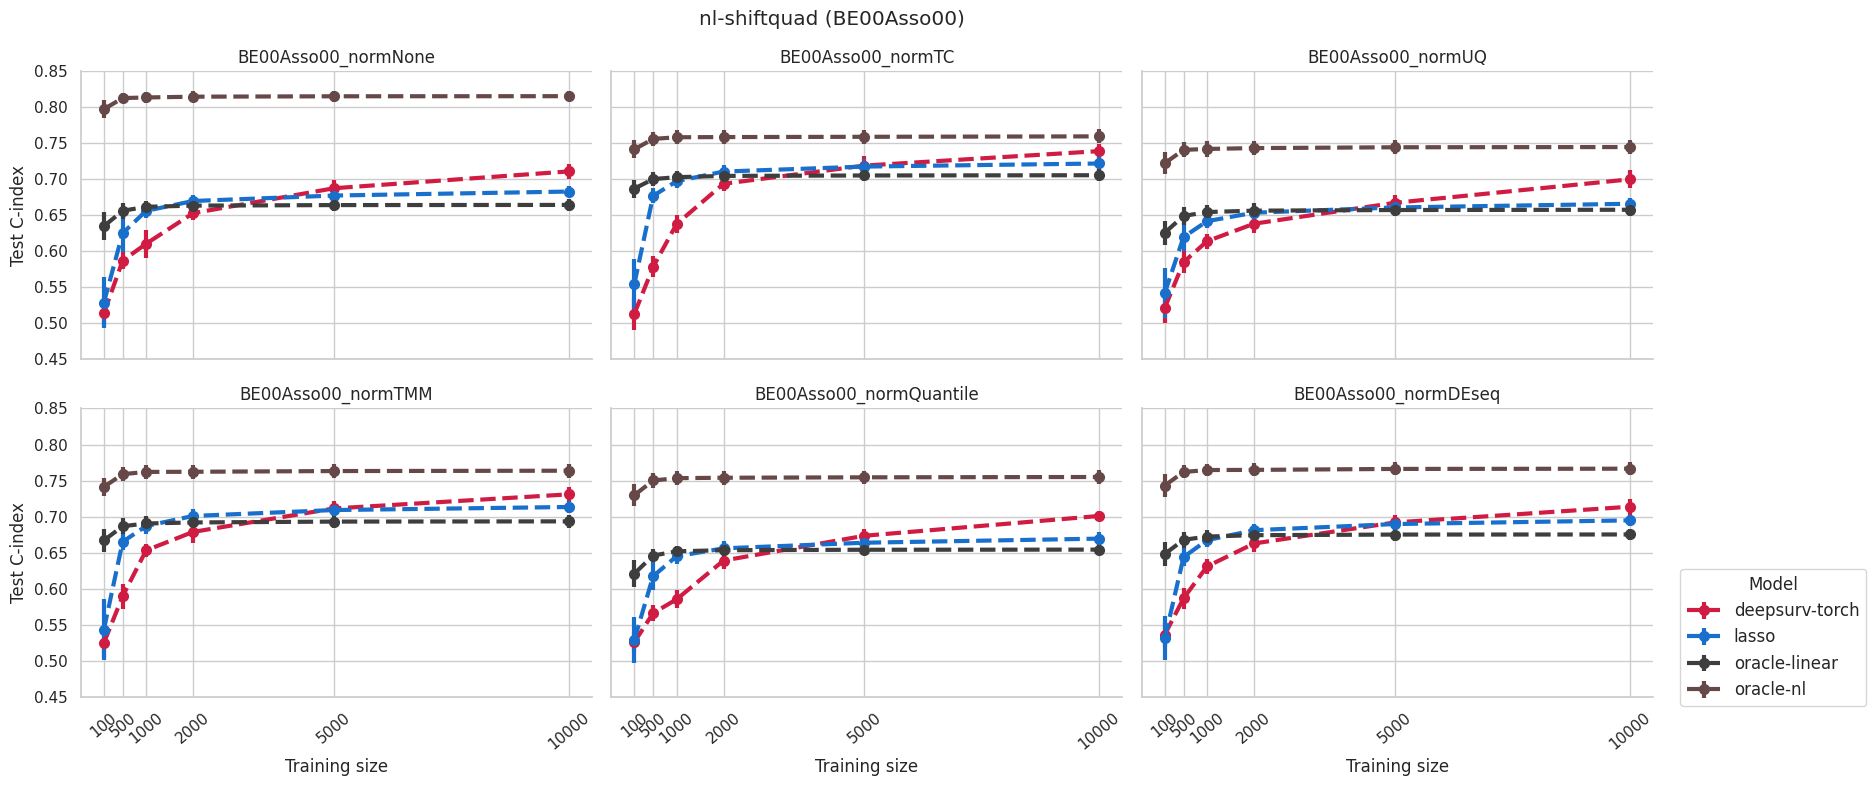

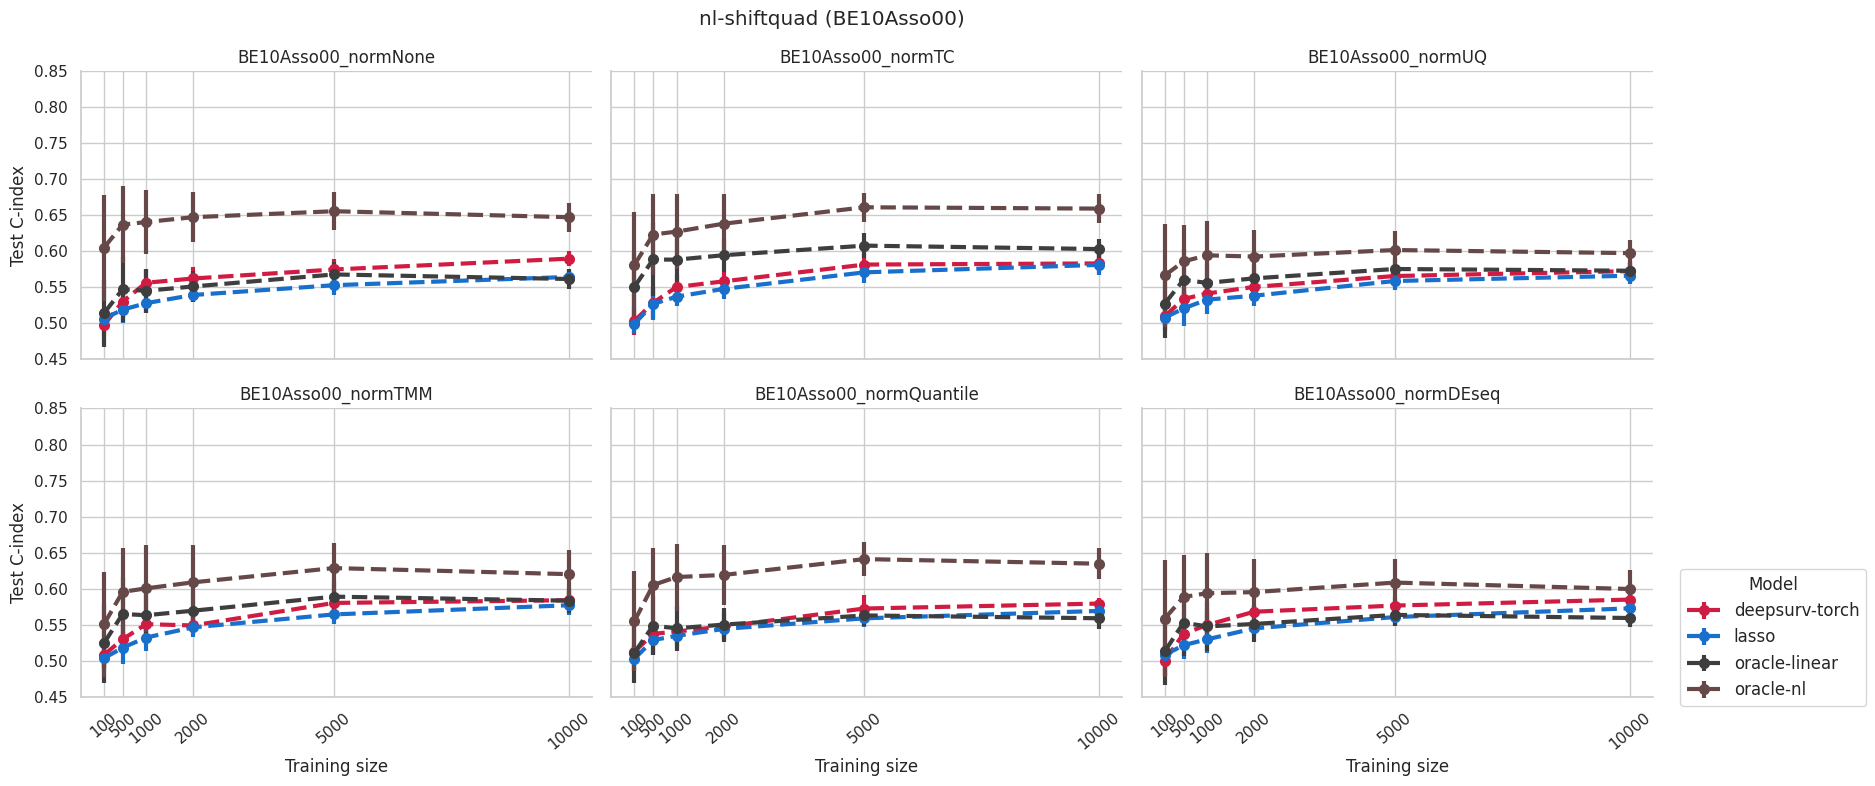

In [38]:
results_be00asso00 = plot_precisionSeq_results(batchType='BE00Asso00', dataName='nl-shiftquad')
results_be10asso00 = plot_precisionSeq_results(batchType='BE10Asso00', dataName='nl-shiftquad')

### Archive (by May30 2025)

In [4]:
import seaborn as sns
import glob

def plot_precisionSeq_results(batchNormType, ylim=[0.5,1]):
    
    results = pd.DataFrame(columns=['n train', 
                                    'train time',
                                    'train C',
                                    'test C',
                                    'train brier',
                                    'test brier',
                                    'model type',
                                    'data type'])
    modelTypes = ['deepsurv-torch', 'lasso', 'oracle']
    dataNames = ['linear-moderate', 'linear-weak','nl-quadratic','nl-interaction','nl-sine']
    # batchNormType = 'BE00Asso00_normNone'
    
    for dataName in dataNames:
        for model in modelTypes:
            try:
                file_dir = glob.glob(
                    os.path.join('models', batchNormType, dataName, model, f"model_results_*.csv")
                    )[-1]
                result_df = pd.read_csv(file_dir)
            except: 
                continue
            if model != 'deepsurv-torch':
                result_df.columns = ["n train","train C","test C"]
            
            result_df['model type'] = model
            result_df['data type'] = dataName
            results = pd.concat([results, result_df], axis=0)
            
    results['n train'] = results['n train'].astype(int)
    
    sns.set(style="whitegrid", font_scale=1)
    colors = {
        'deepsurv-torch': "#d01c43",   # Soft red
        'lasso': "#186fcc",            # Muted blue
        'oracle': "#3E3E3E"            # Medium gray
    }
    g = sns.FacetGrid(results, 
                    col="data type", 
                    col_wrap=3, 
                    # palette='Set2',
                    height=4, 
                    aspect=1.2, 
                    sharey=True, 
                    sharex=True
                    )
    # Add mean lines on top of boxplot
    for ax, dataName in zip(g.axes.flat, results['data type'].unique()):
        # means = subset.groupby(['n train', 'model type'])['test C'].mean().reset_index()
        subset = (
            results[results['data type'] == dataName]
            .groupby(['data type', 'n train', 'model type'])
            .agg(mean=('test C', 'mean'),
                sd=('test C', 'std'))
            .reset_index()
        ) 
        # print(subset)
        for model in subset['model type'].unique():
            sub = subset[subset['model type'] == model]
            
            ax.errorbar(
                sub['n train'], sub['mean'], yerr=sub['sd'], color=colors[model],
                label=model, marker='o', linestyle='--', linewidth=3, markersize=7
            )
            ax.set_ylim(ylim)
            ax.set_title(dataName)
            ax.set_xlabel("Training size")
            ax.set_ylabel("Test C-index")
            ax.set_xticks([100,500,1000,2000,5000])
            ax.set_xticklabels(['100','500','1000','2000','5000'])
            # ax.legend()
            
    g.fig.suptitle(batchNormType)
    g.set_titles("{col_name}")
    g.set_axis_labels("Training size", "Test C-index")
    
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(
        handles, labels, 
        loc='lower left', 
        bbox_to_anchor=(0.82, 0.1),
        ncol=1, frameon=True, fontsize=12, 
        title="Model"
    )
    plt.tight_layout()
    plt.show()
    
    return results

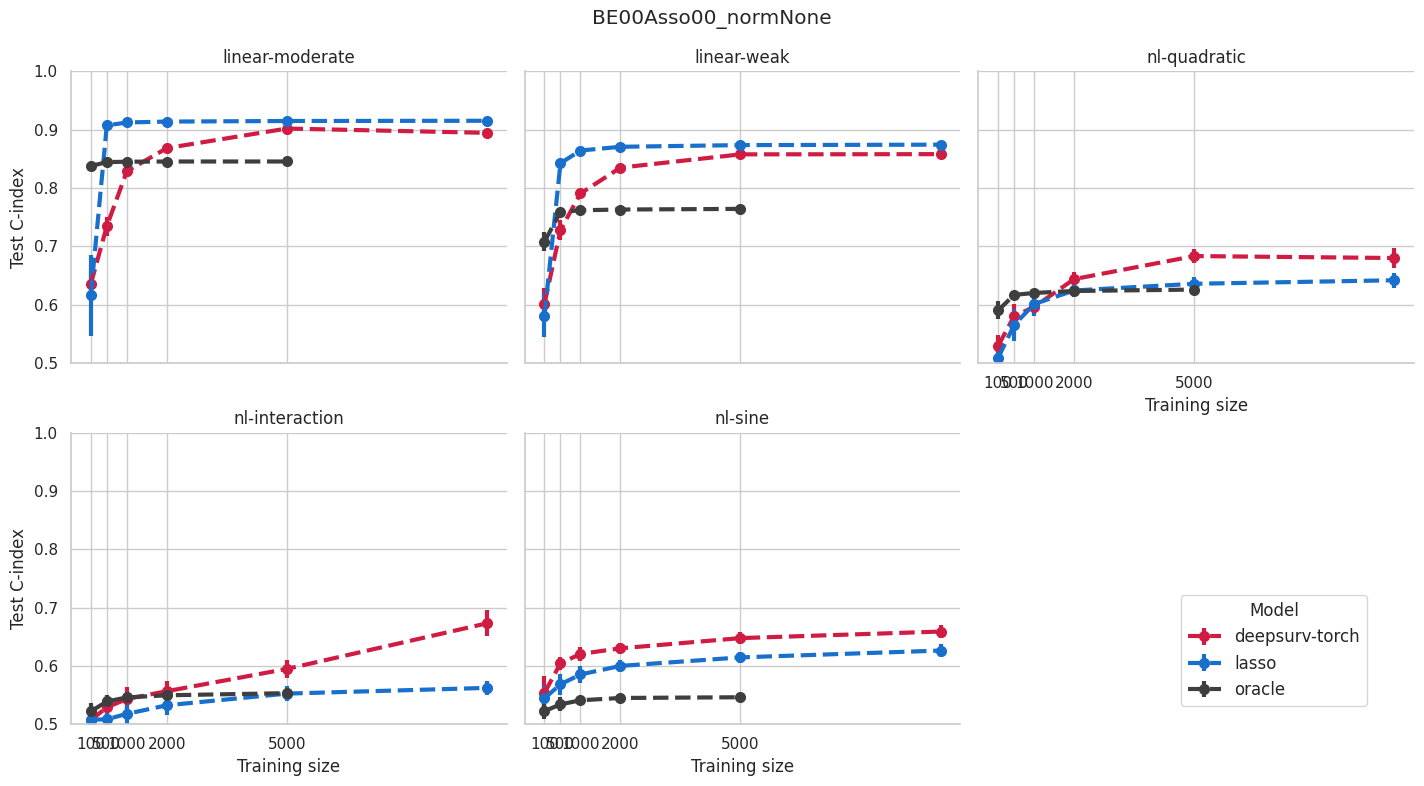

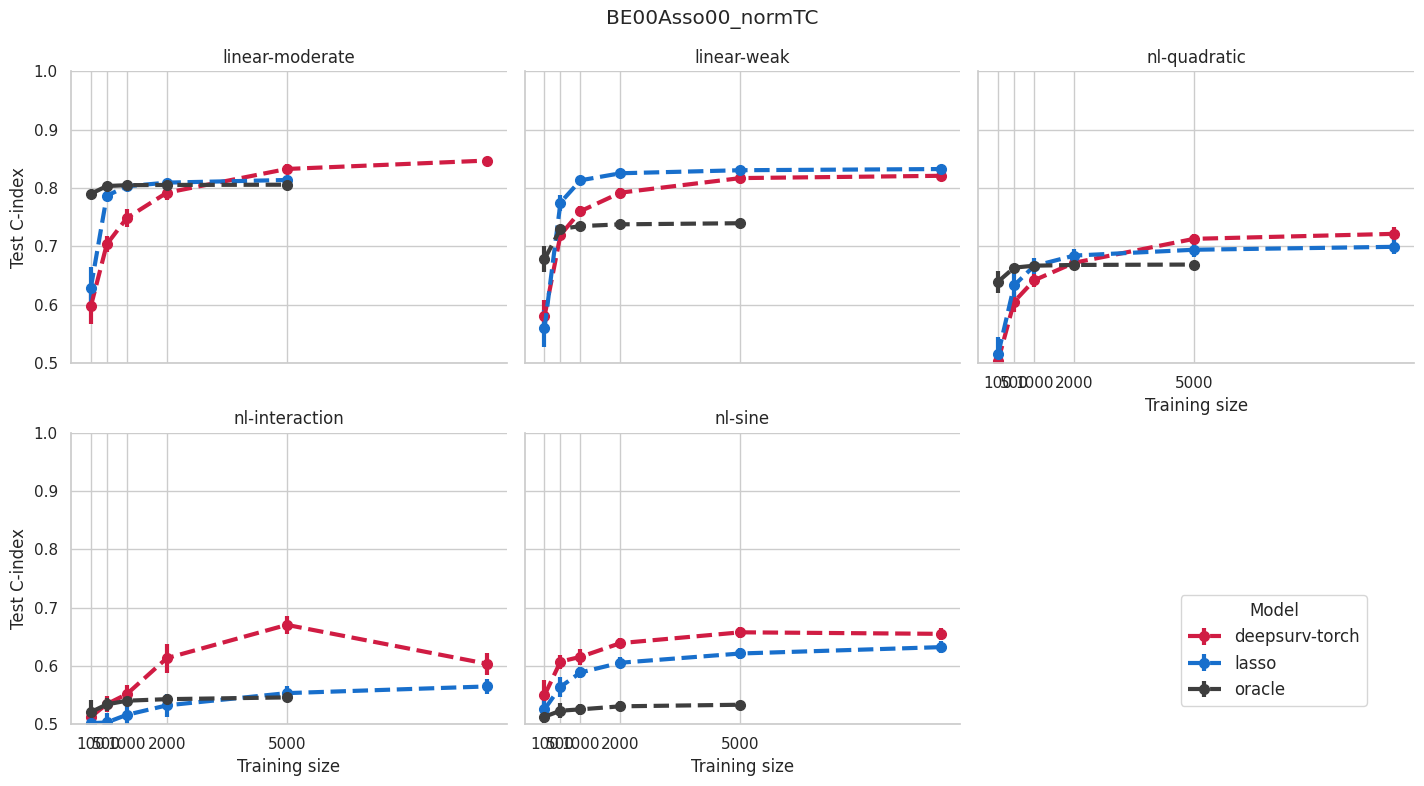

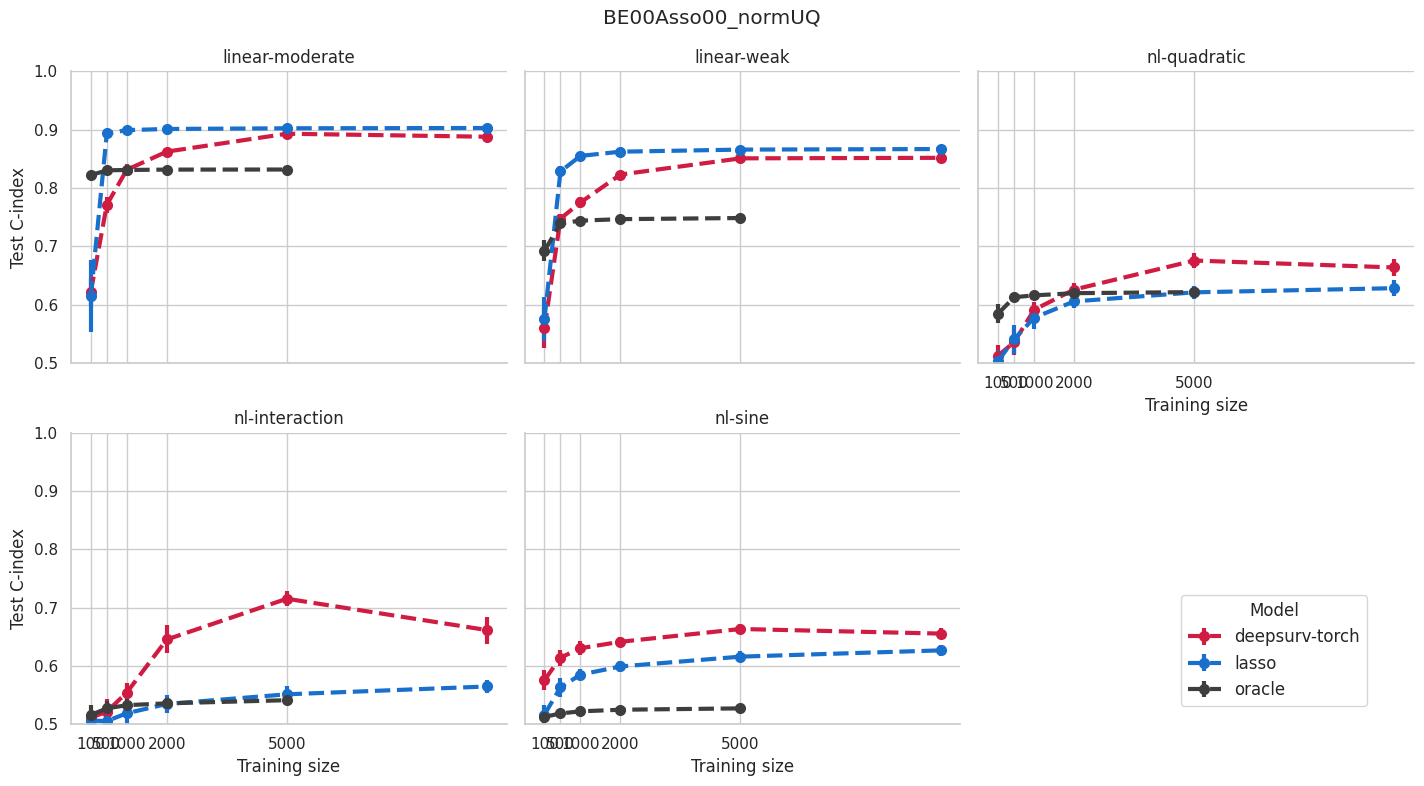

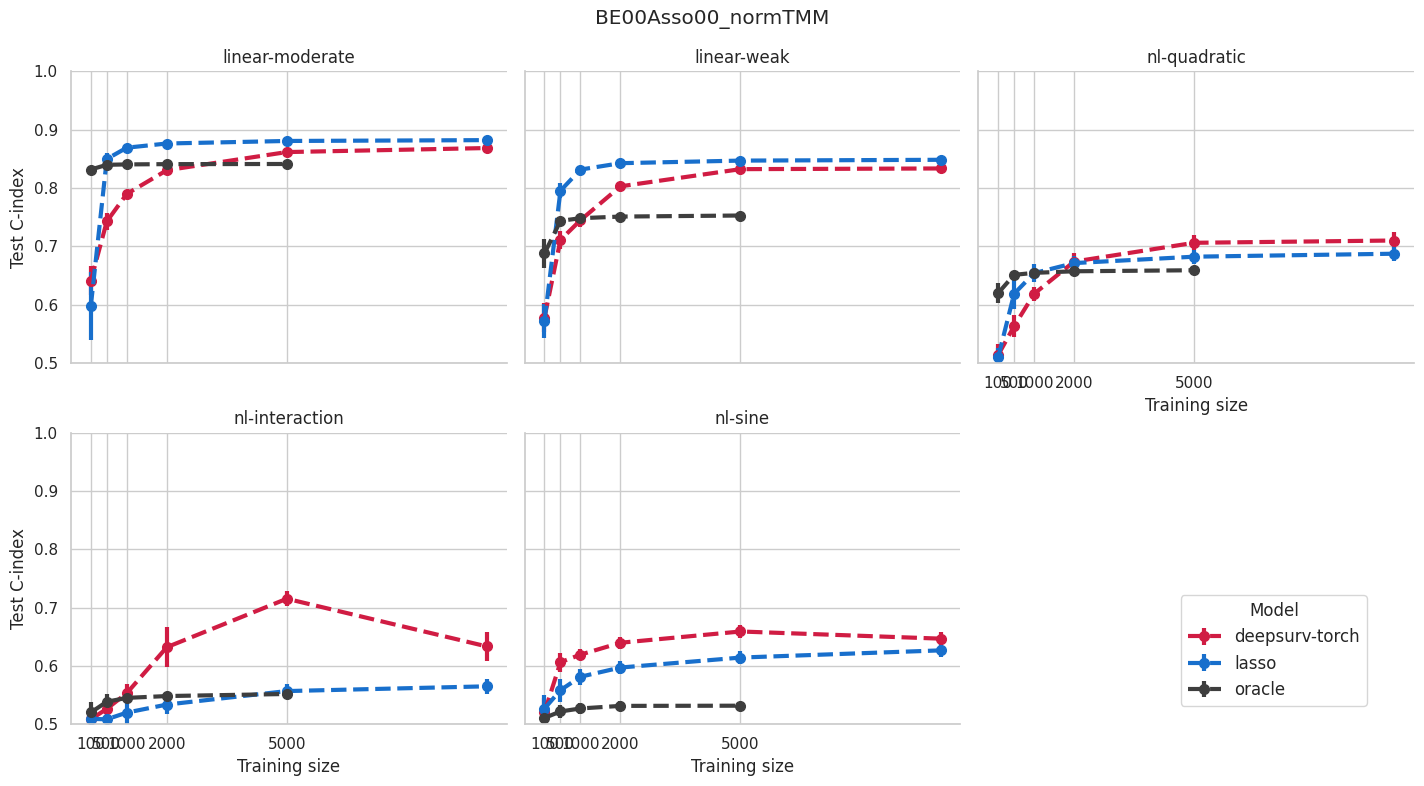

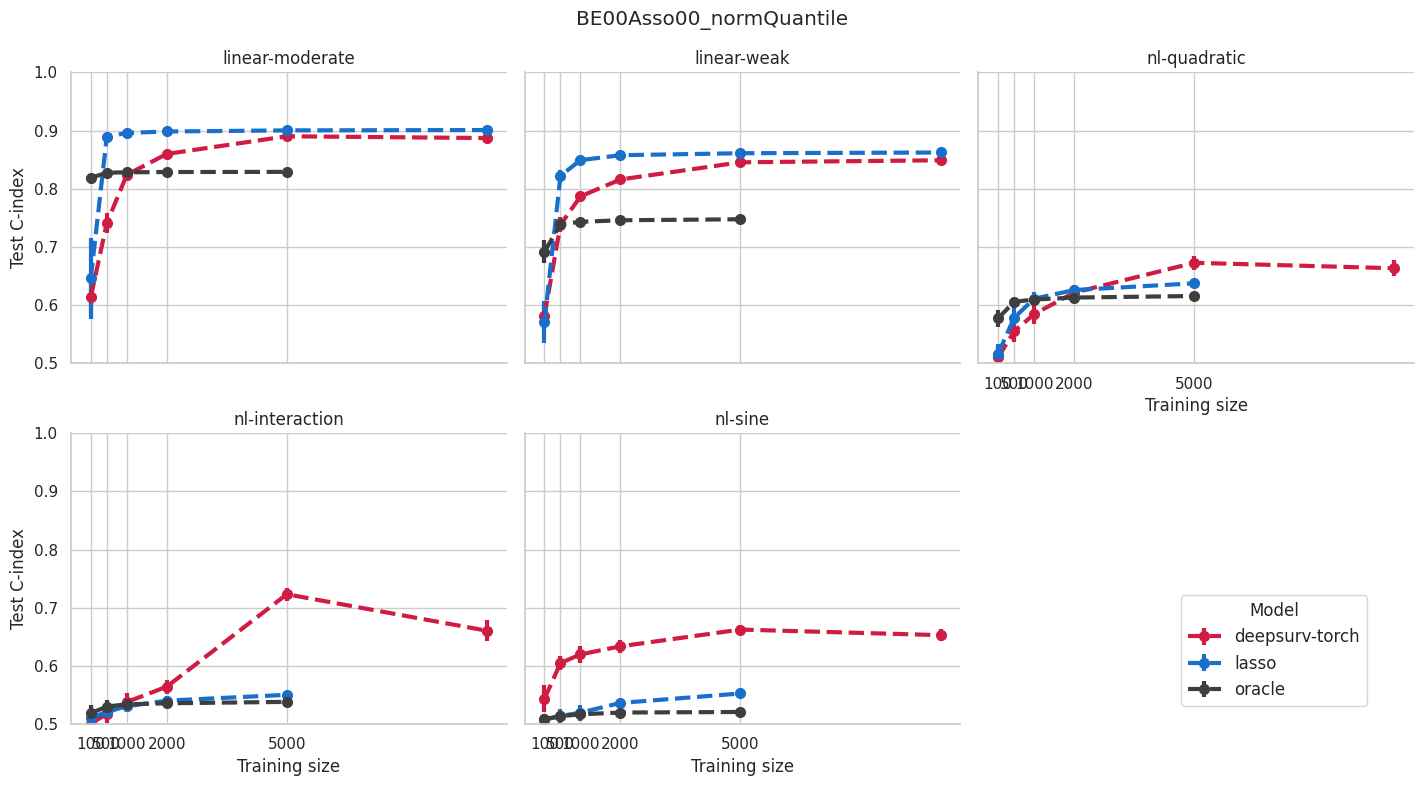

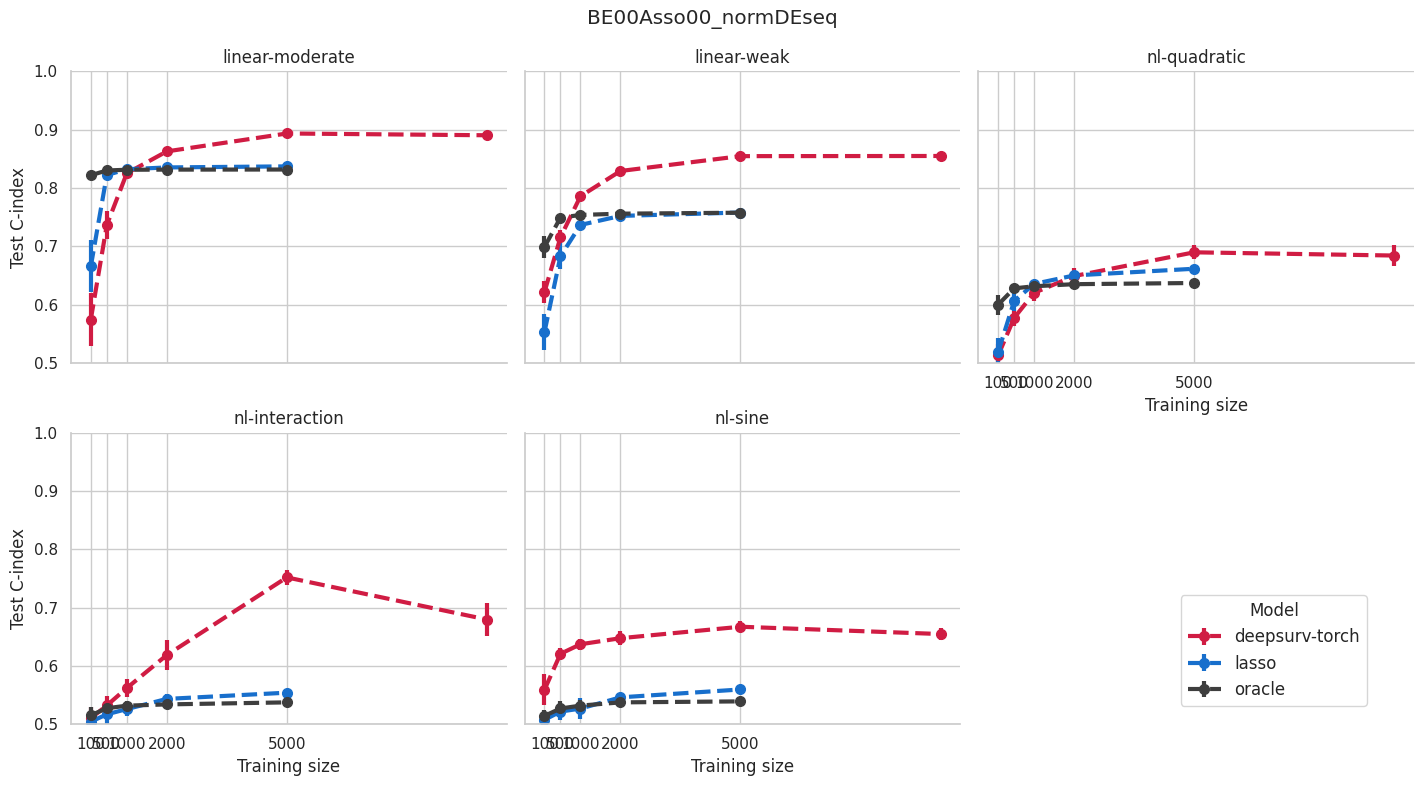

In [ ]:
results_none = plot_precisionSeq_results(batchNormType='BE00Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normDEseq')

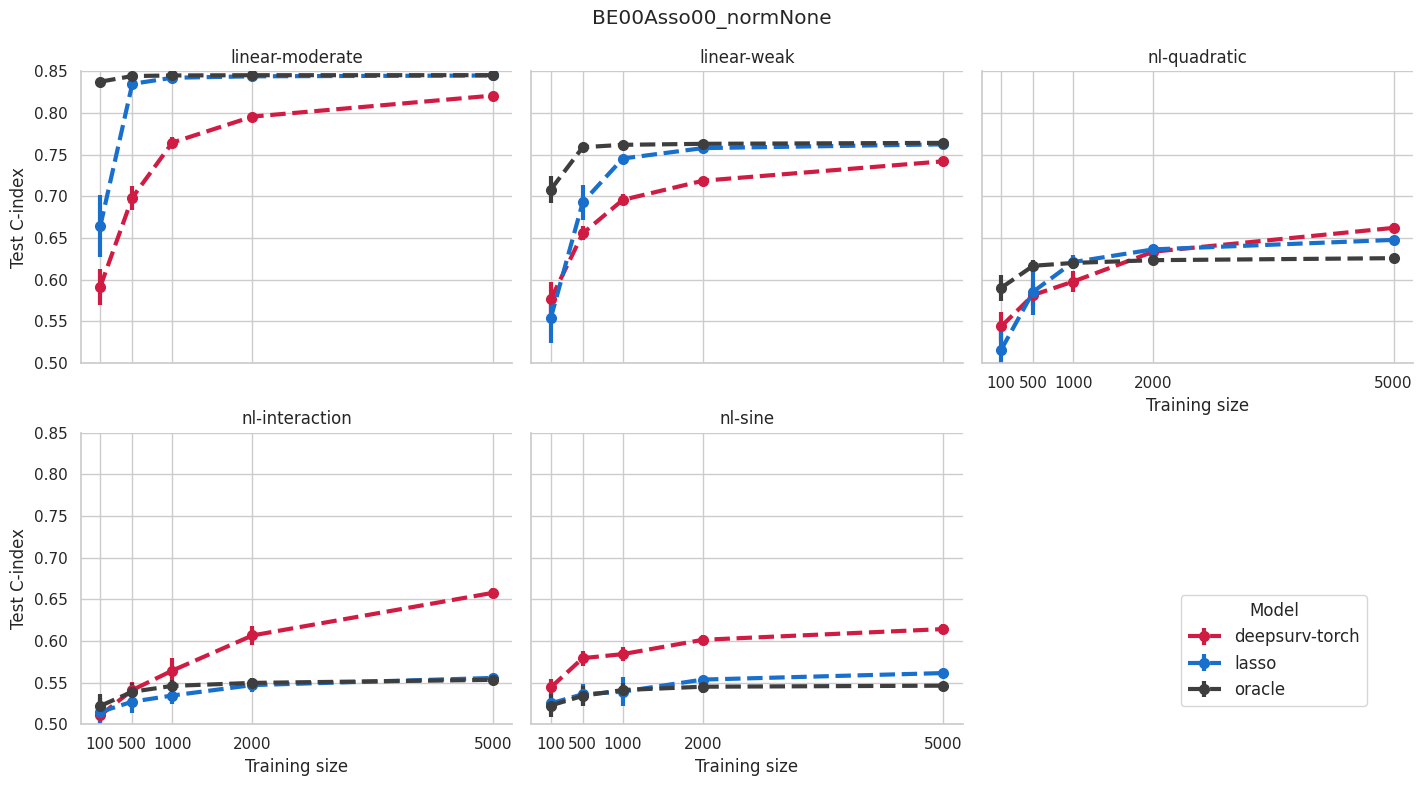

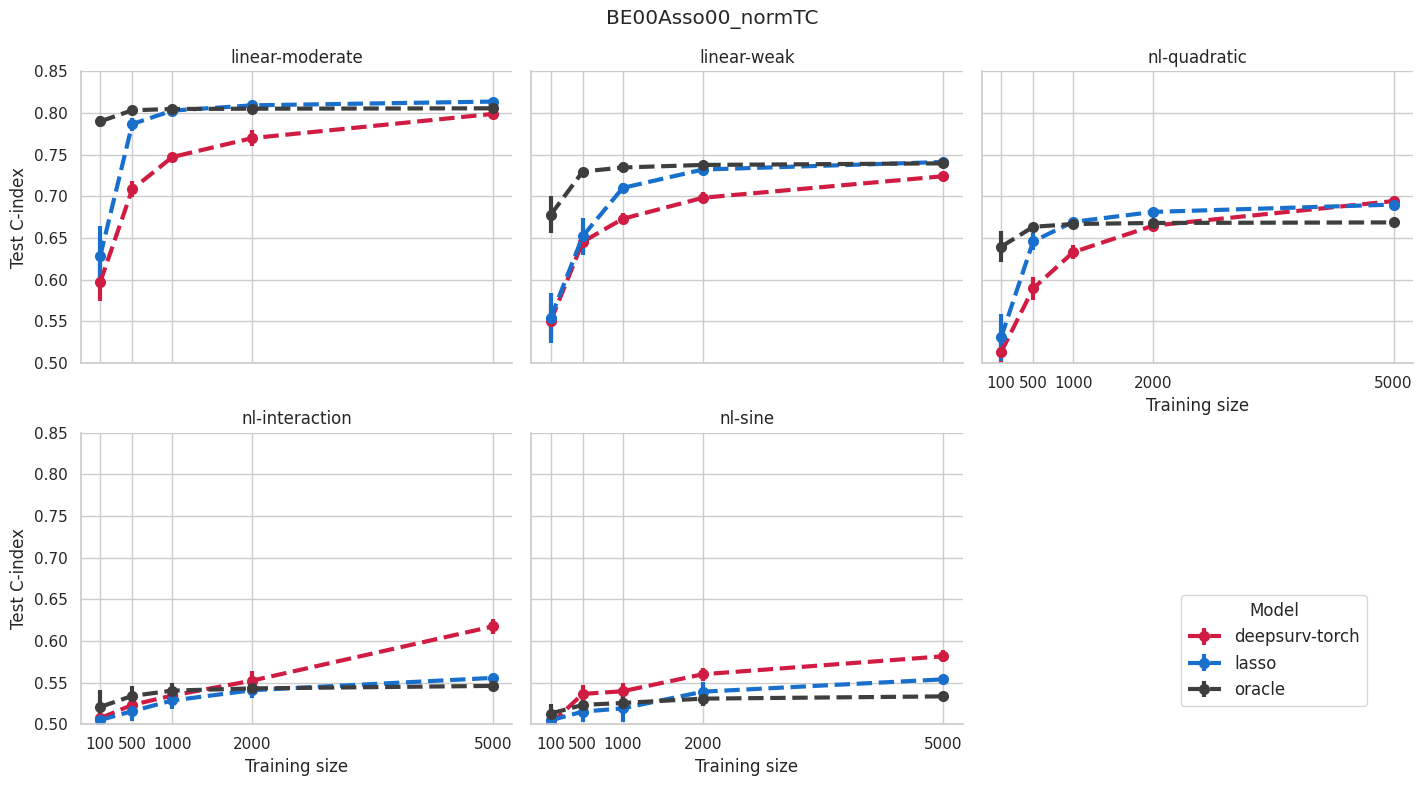

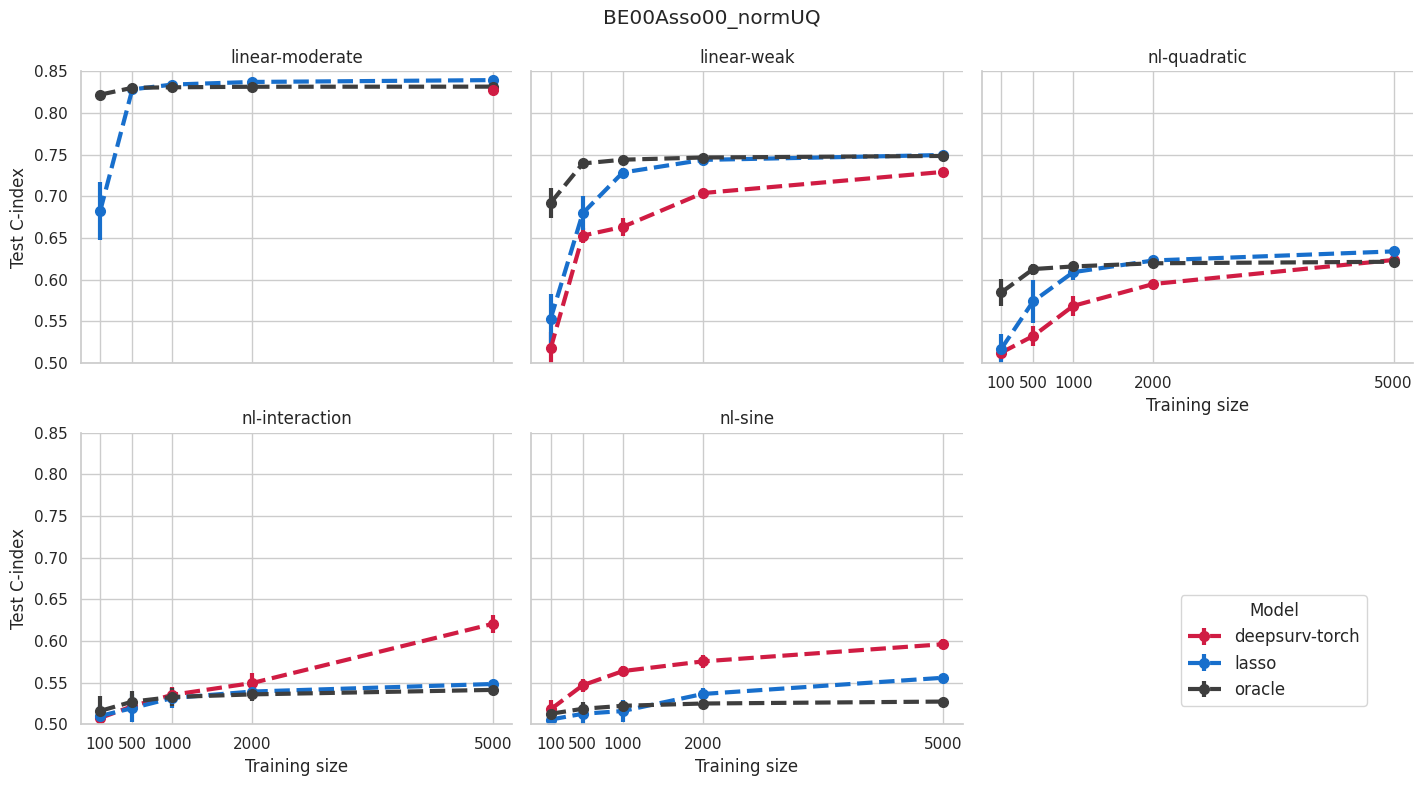

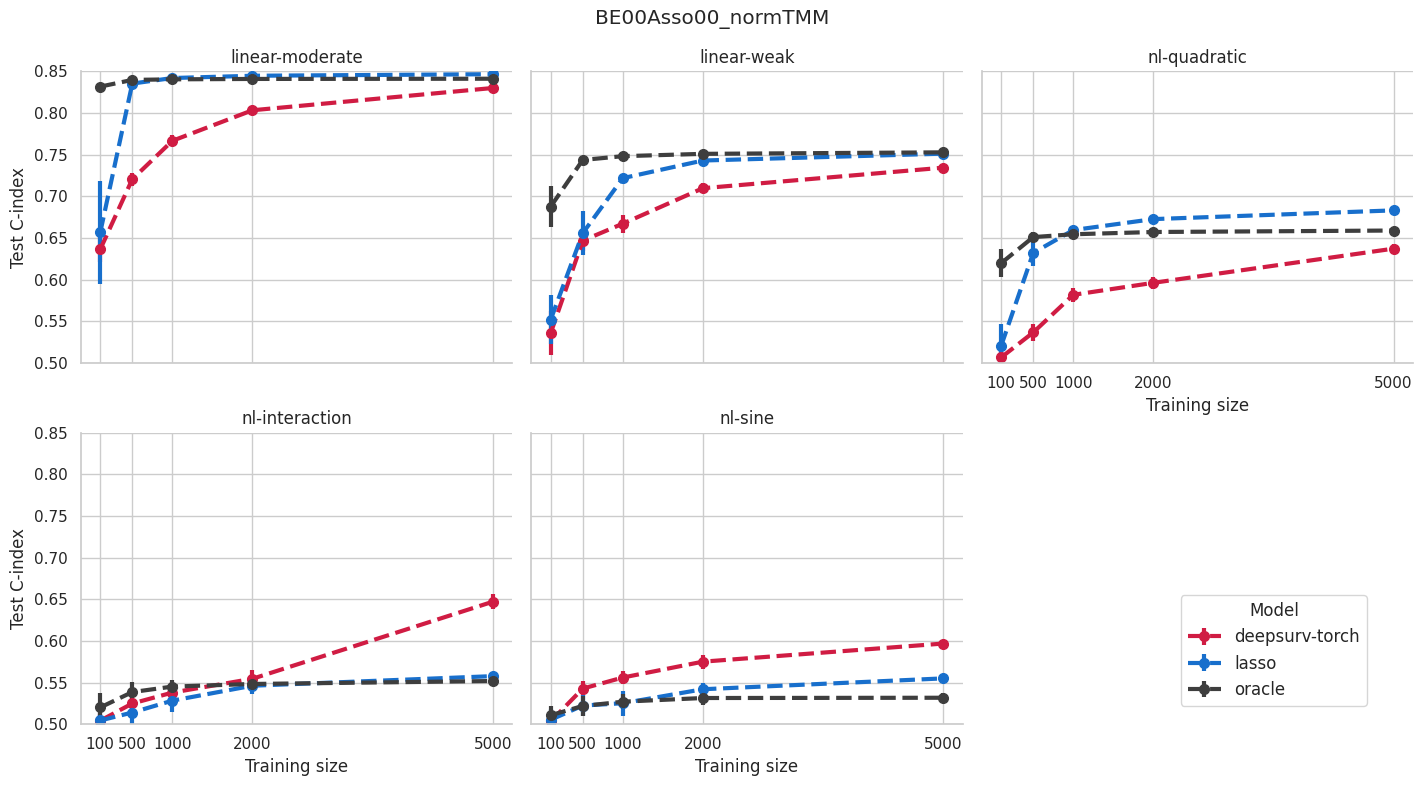

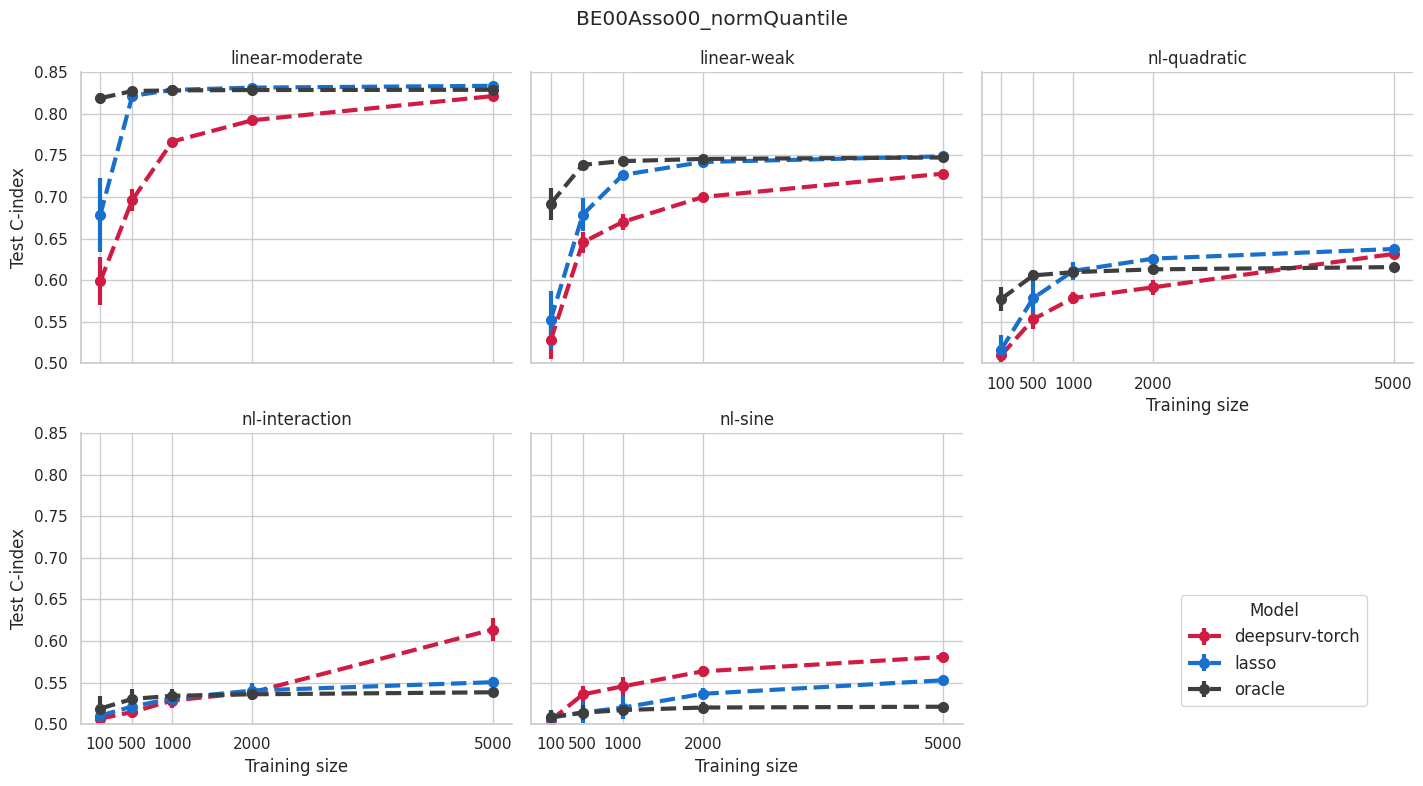

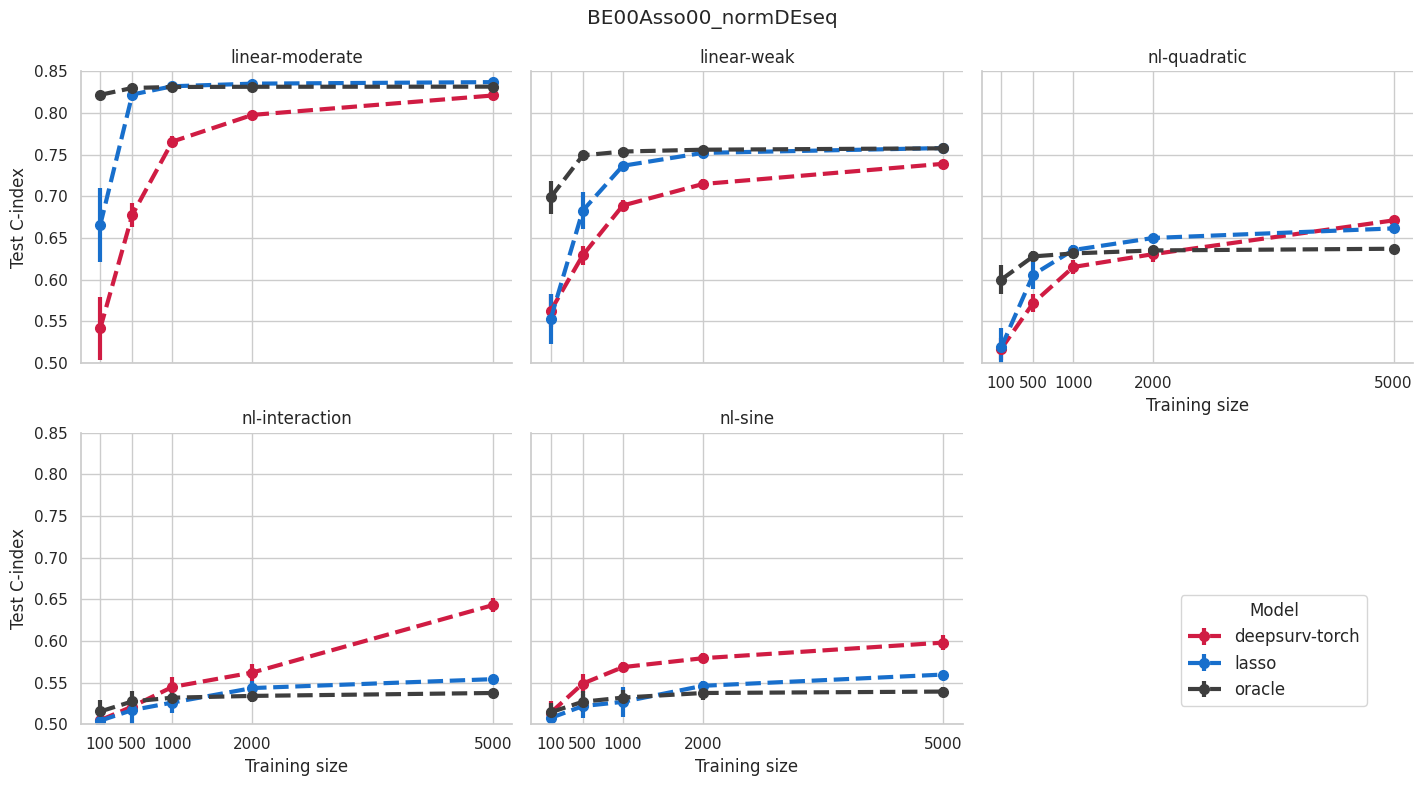

In [4]:
results_none = plot_precisionSeq_results(batchNormType='BE00Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE00Asso00_normDEseq')

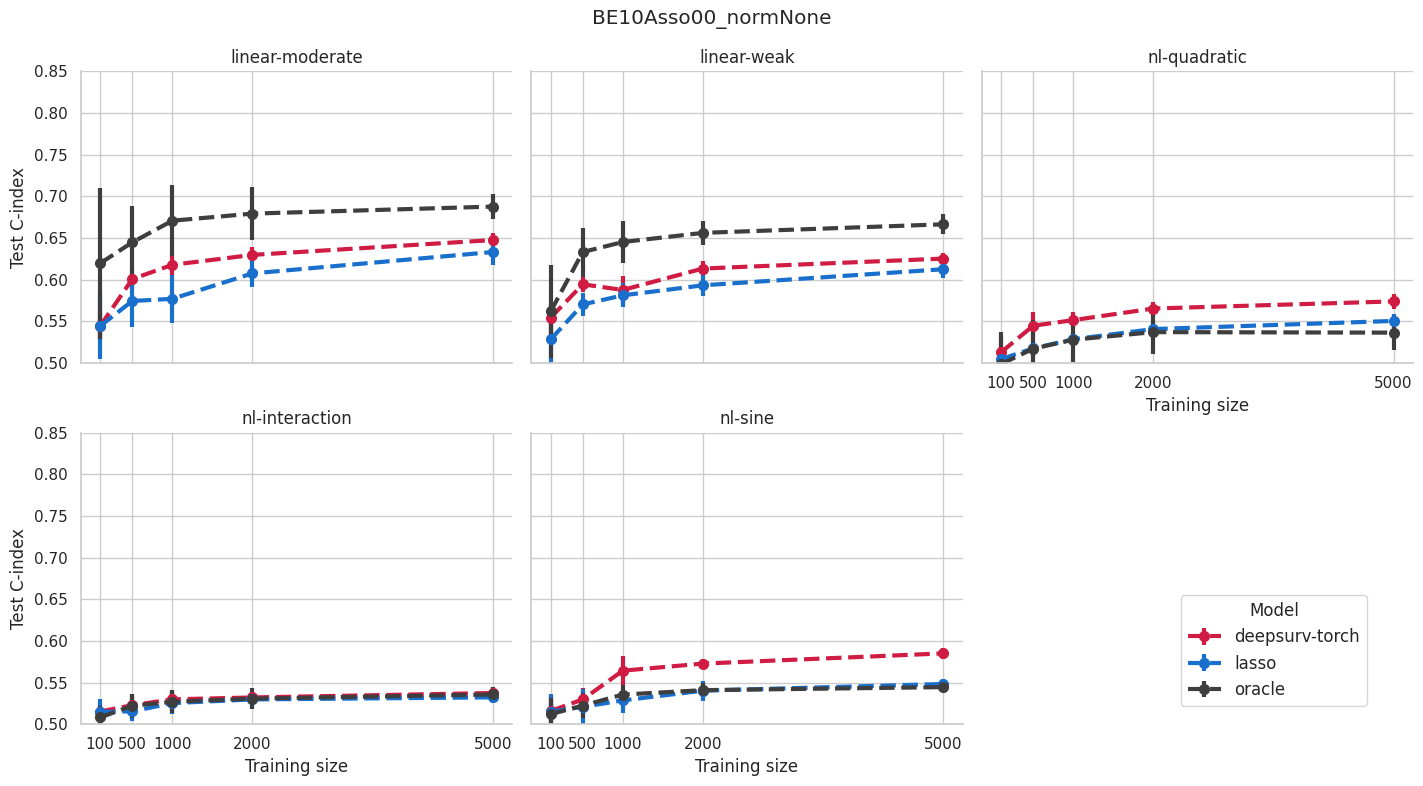

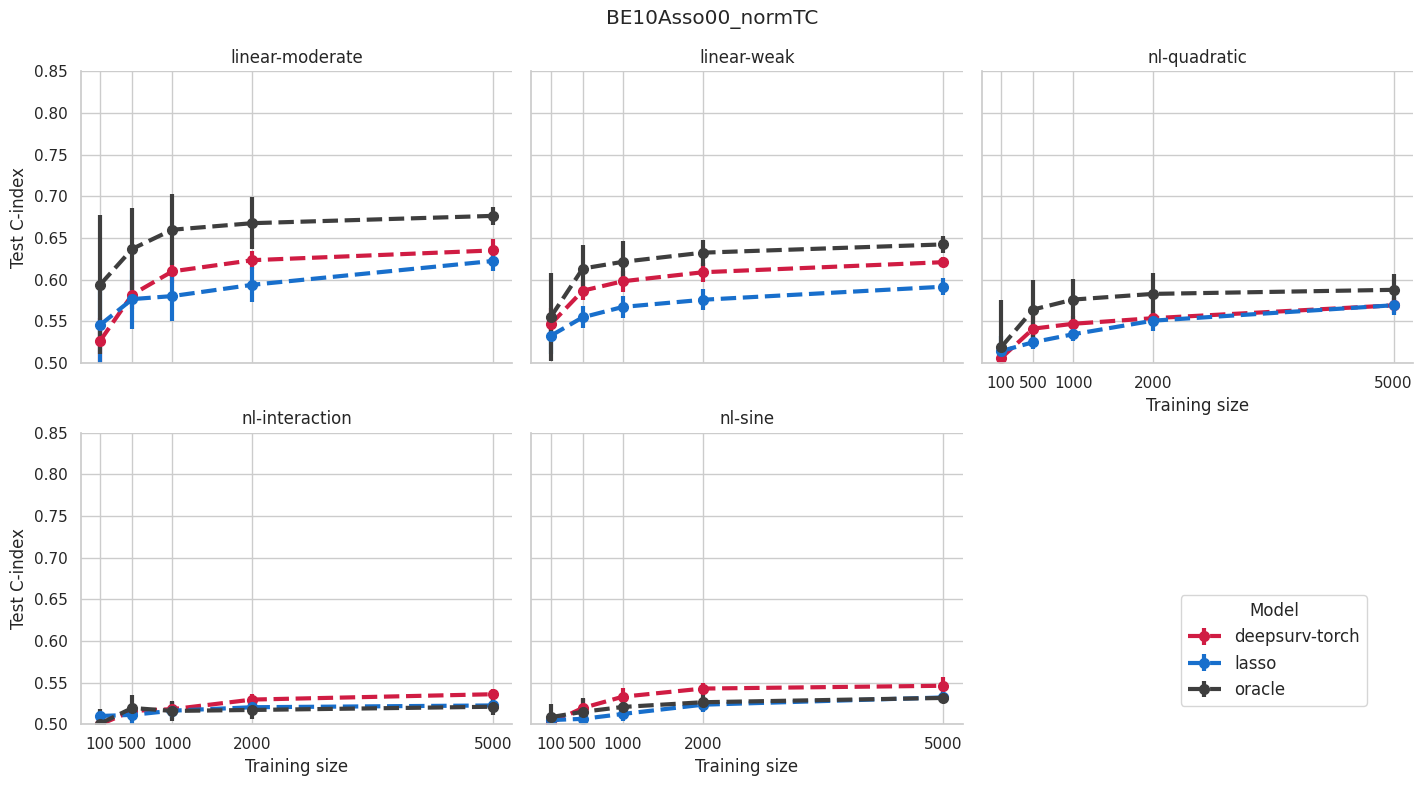

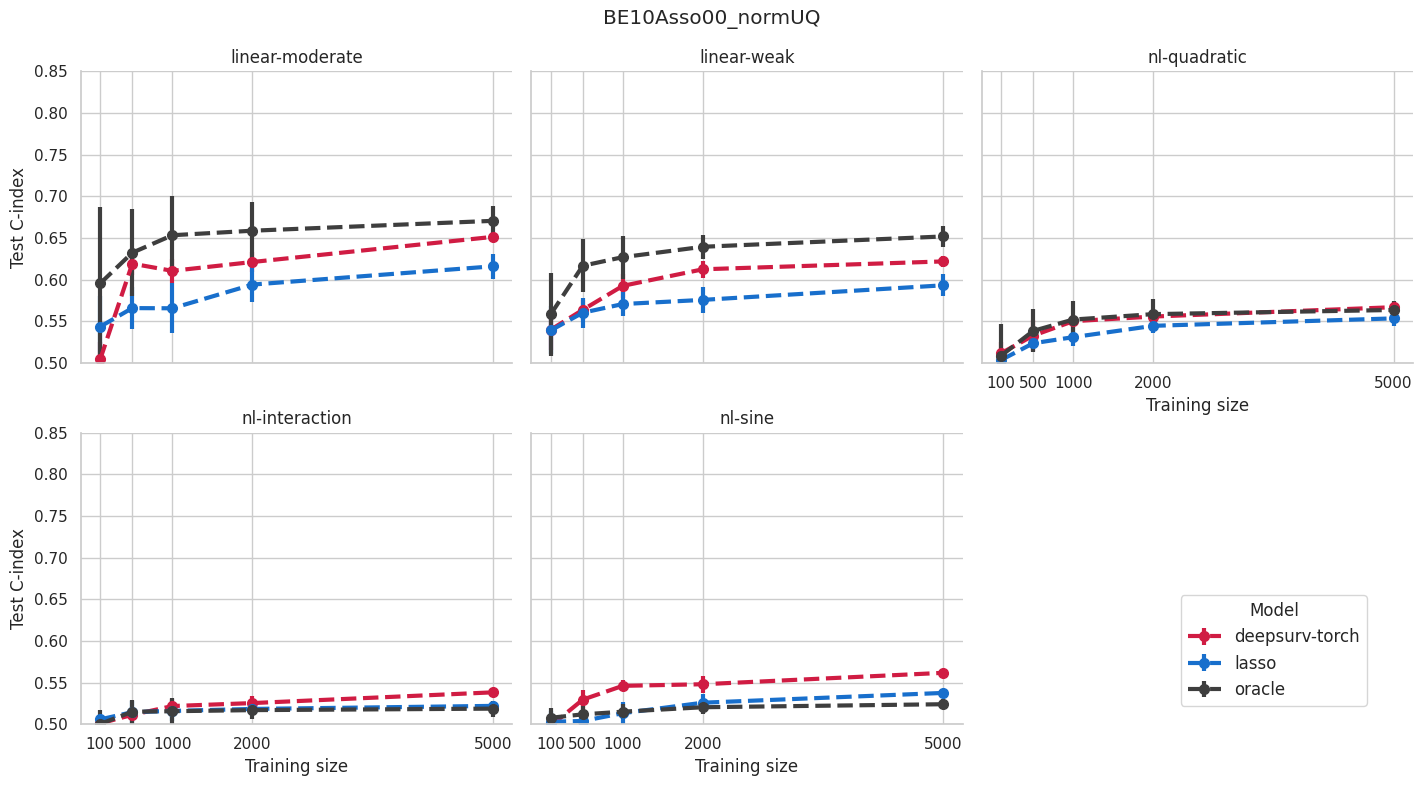

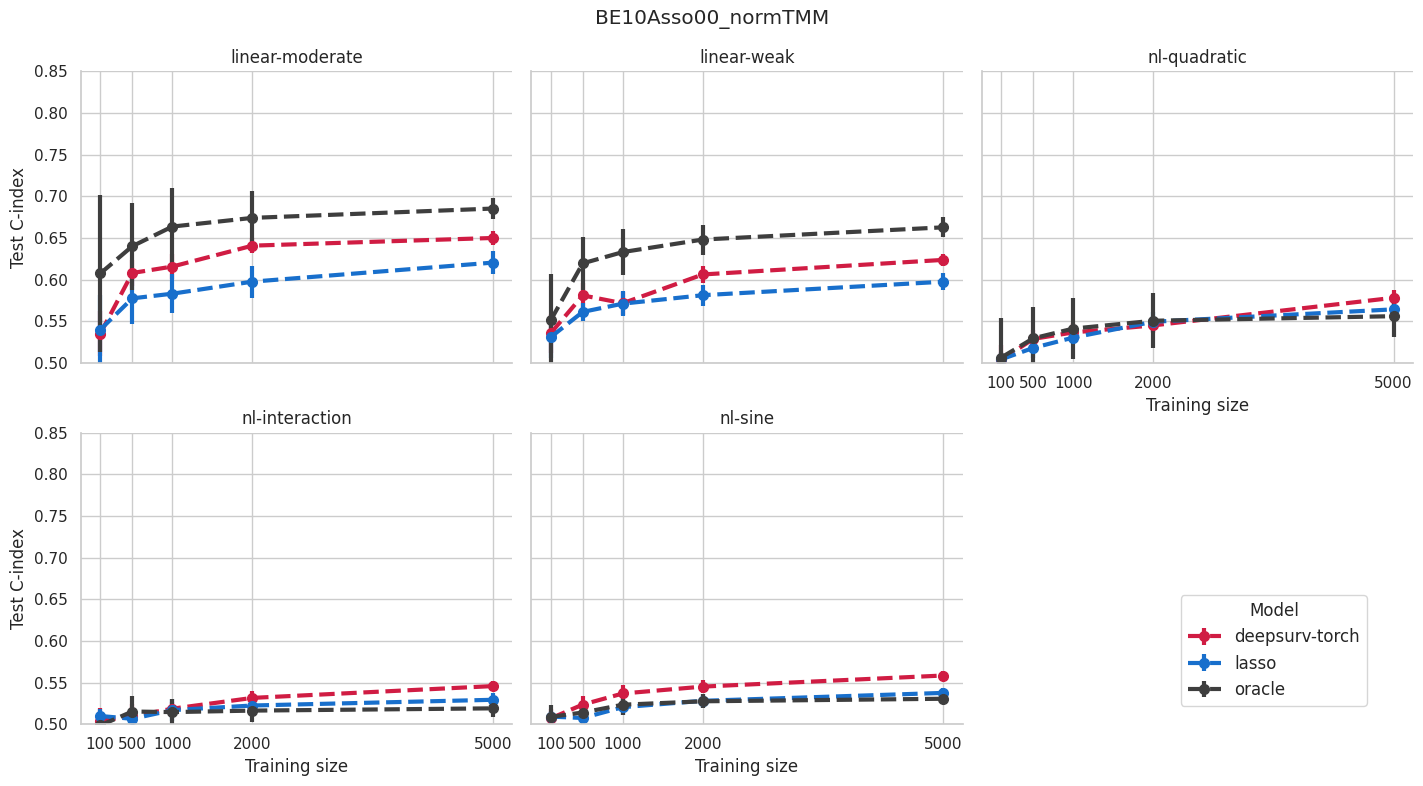

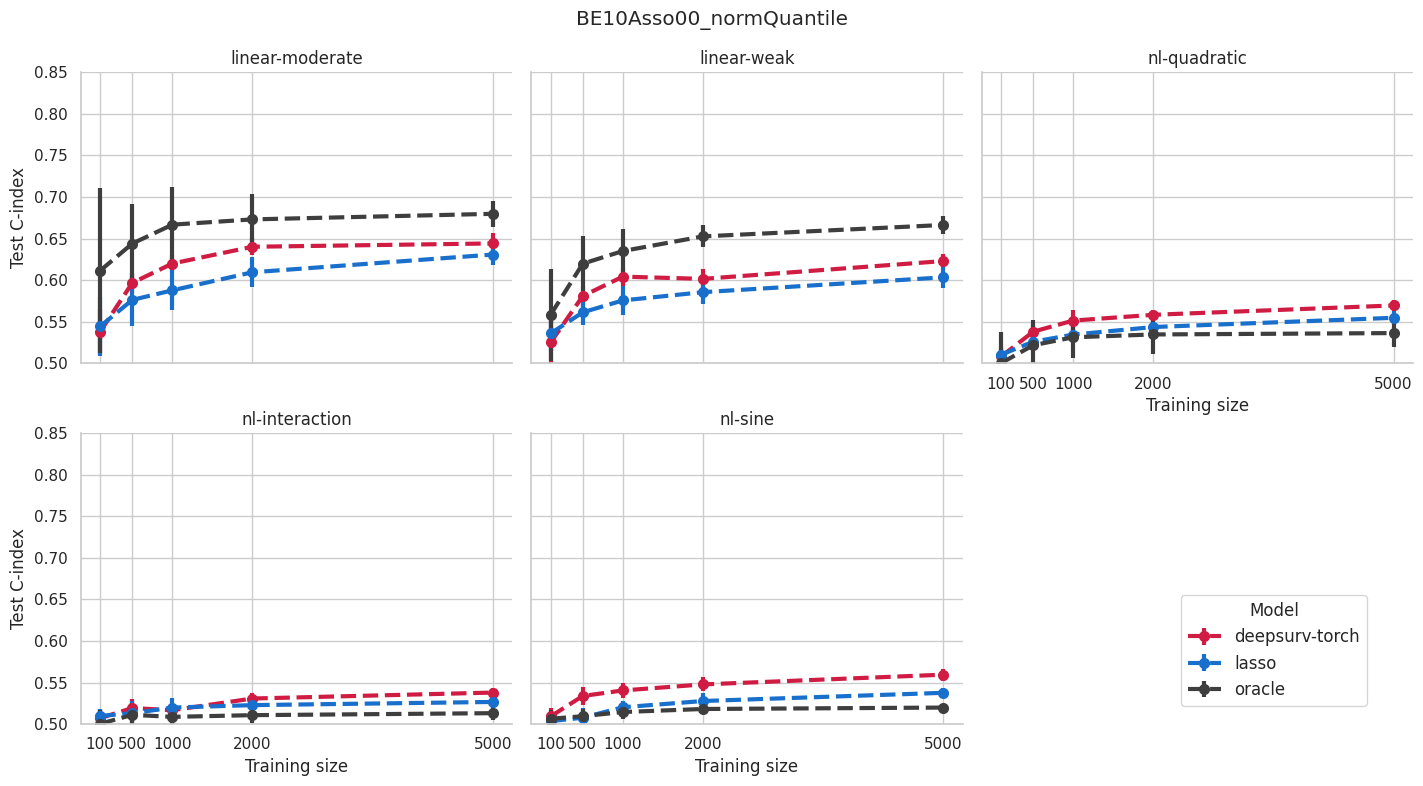

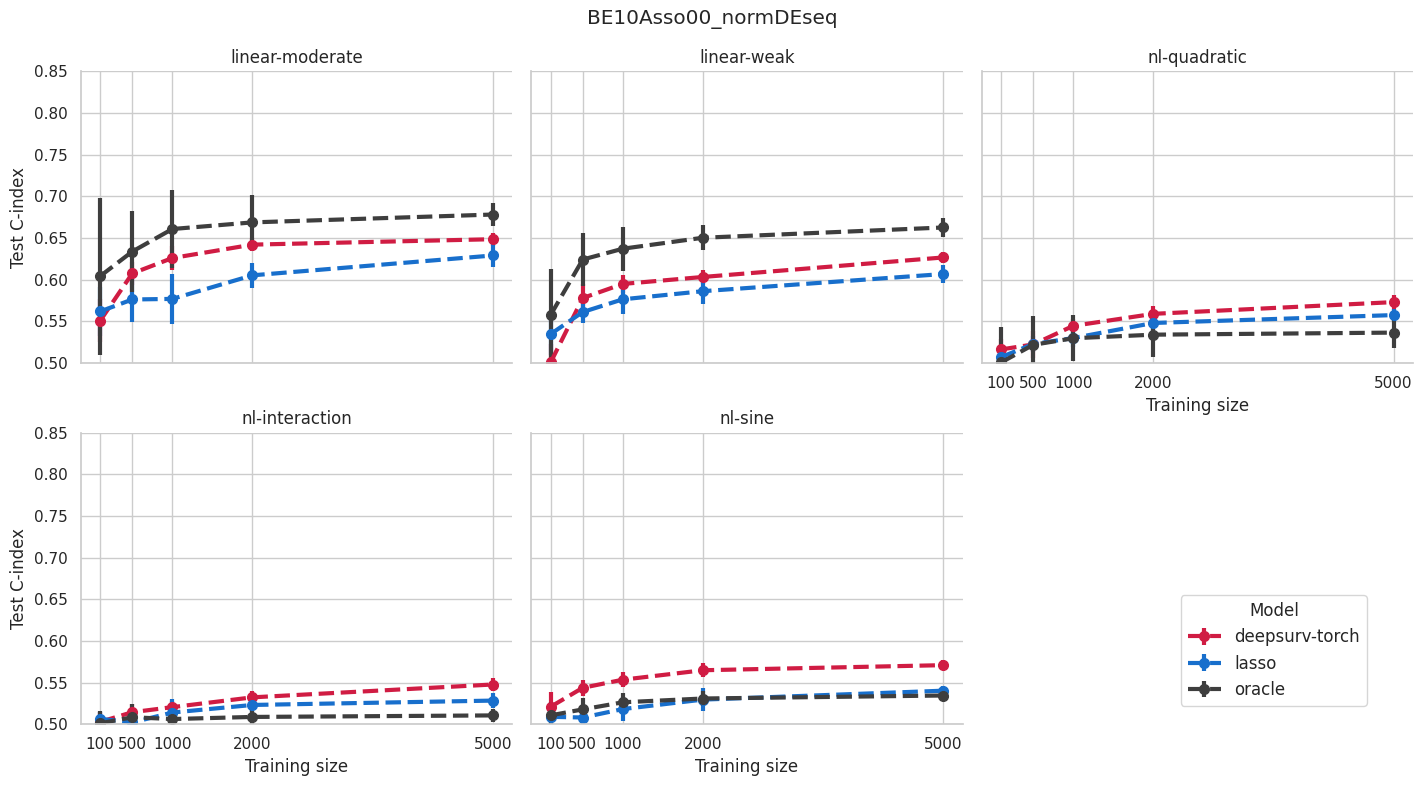

In [7]:
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normNone')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normTC')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normUQ')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normTMM')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normQuantile')
_ = plot_precisionSeq_results(batchNormType='BE10Asso00_normDEseq')

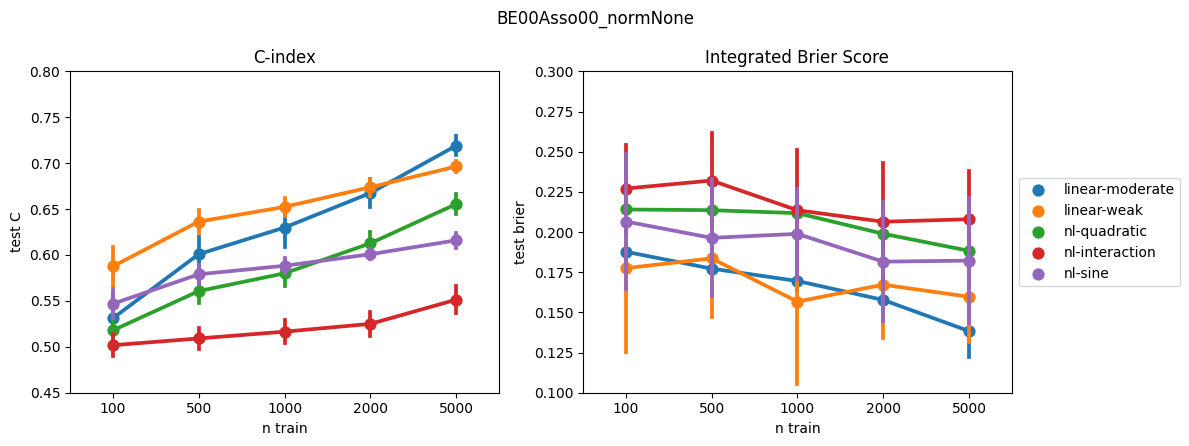

In [ ]:
import seaborn as sns
deepsurv_results = pd.DataFrame(columns=['n train', 
                                        'train time',
                                        'train C',
                                        'test C',
                                        'train brier',
                                        'test brier',
                                        'data type'])
dataNames = ['linear-moderate', 'linear-weak','nl-quadratic','nl-interaction','nl-sine']
fileName="model.results.txt"
for dataName in dataNames:
    file_dir = os.path.join('models', batchNormType, dataName, 'deepsurv-torch', fileName)
    
    result_df = pd.read_table(file_dir, index_col=0)
    result_df['data type'] = dataName
    deepsurv_results = pd.concat([deepsurv_results, result_df], axis=0)
    
deepsurv_results.head()

# Plot train time comparison
fig, ax = plt.subplots(1,2,figsize=(12, 4.5))

sns.pointplot(data=deepsurv_results, x='n train', y='test C', hue='data type', ci='sd', estimator='mean', ax=ax[0])
sns.pointplot(data=deepsurv_results, x='n train', y='test brier', hue='data type', ci='sd', estimator='mean', ax=ax[1])

ax[0].set_ylim(0.45, 0.8)
ax[1].set_ylim(0.1, 0.3)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].legend().set_visible(False)  # Hide legend on the second subplot

fig.suptitle(batchNormType)
ax[0].set_title('C-index')
ax[1].set_title('Integrated Brier Score')
plt.tight_layout()